# 0. Data gathering
From url_filter data extraction process
1. Downloaded html content for staffing and consulting urls
2. Downloaded good manual urls content to file as well
3. Create a tsv (url, cleaned content, binary) (THIS IS OUR ONE DOC PER LINE FILE)
4. Use get_raw_data_good_bad.py script to get one large pool of just the text. (THIS IS OUR CORPUS)

# 1. Import raw text and tokenize

In [3]:
# General Imports
import re
import os

In [4]:
# given a tsv file with a column containing text data, compile that data into one single file for processing
source_file = 'data/urls_all_good_tech_consult.tsv'
text_column = 1
target_file = 'data/content_urls_all_good_tech_consult.txt'

def extract_content_from_tsv(source_file, text_column, target_file):
    print "Opening file {} for content at column {}".format(source_file, text_column)
    print "Save content to {}".format(target_file)
    with open(source_file, 'r') as source, open(target_file, 'w') as target:
        for line in source:
            cols = line.split('\t')
            target.write(cols[text_column])
            target.write('\n')


extract_content_from_tsv(source_file, text_column, target_file)
data_source = target_file
print "DONE!"

Opening file data/urls_all_good_tech_consult.tsv for content at column 1
Save content to data/content_urls_all_good_tech_consult.txt
DONE!


In [5]:
"""
Take a source of text and create a python list of all the words.
The words retain the same sequence and frequence as in original text.
INPUT:
    data_source, text file, Content will be parsed for sentences. This should be a plain text document

OUTPUT:
    tokens, list<list>, list of lists containing a one to one mapping of all the words in the provided text.
"""
view_tokens=False
data_source = target_file
base_name = re.compile(r'\..*').sub('', os.path.basename(data_source))

#open input file and tokenize
tokens = []
with open(data_source, 'r') as source:
    for line in source:
        line = re.sub(r'\W', ' ', line) 
        line_tokens = line.split( )
        line_tokens = [token.strip().lower() for token in line_tokens]
        tokens.append(line_tokens)

if (view_tokens):
    for idx in range(2):
        print tokens[idx]

print "DONE creating tokens, saved in variable 'tokens'"

DONE creating tokens, saved in variable 'tokens'


# 2. Create a word2vec model from tokens

In [6]:
"""
Source: Natural Language Processing in Action, Chapter 6
Section: 6.5.2 Training domain specific word2vec model
INPUT:
    tokens, python list, Tokenized data from previous step.
    model_path, string, path where we will saved trained model from tokens (depends on last steps data_source)
OUTPUT:
    model_path, <File on disk> a word2vec trained model from the original tokens.  (hidden weights only)
"""
from gensim.models import word2vec

model_path  = "models/{}".format(base_name)

model = word2vec.Word2Vec(
    tokens,              # Our array of sentences, each of which is an array of words.
    min_count=3,         # Min number of word count to be considered
    workers=4,           # Number of threads in parallel. (cores on laptop)
    size=300,            # The number of weights in hidden layer, (length of word verctors)
    window=6,            # Context window size
    sample=1e-3          # subsampling rate for frequent terms
)

# Save disk space by saving only hidden neurons.  (We lose output weights)
model.init_sims(replace=True)

model.save(model_path)

print "New model saved to {}".format(model_path)

New model saved to models/content_urls_all_good_tech_consult


# 3. Import model and test it by looking for similar words..

In [8]:
"""
Load a previously saved word2vec model and use vector math to find words deemed 'similar'

INPUT:
    model_path: string, path to file containing previously trained set of word2vec vectors.
OUTPUT:
    positive: list<string>, a list of words to find similar words to.
    negavite: list<string>, a list of words whose vectors get subtracted before finding similarity

Output is displayed to console.
"""
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import word2vec

# INTPUTS: aws, doctor, contenu, 
positive = ['contenu']
negative = []

model = word2vec.Word2Vec.load(model_path)
results = model.most_similar(positive=positive, negative=negative, topn=20)
# print results
data = pd.DataFrame(results)

print "Positive: {}".format(positive)
print "Negative: {}".format(negative)
print data.head(20)

Positive: ['contenu']
Negative: []
                 0         1
0          portail  0.707237
1         contenus  0.691070
2       traduction  0.686309
3    referencement  0.675429
4         publicit  0.673506
5   positionnement  0.673102
6      rfrencement  0.671112
7     documentaire  0.663818
8           fermer  0.661137
9             pied  0.655297
10      changement  0.654413
11  fonctionnalits  0.654344
12        statique  0.652699
13      chargement  0.650910
14    gestionnaire  0.650819
15          adifco  0.650442
16      paramtrage  0.649577
17    comportement  0.645746
18           outil  0.642198
19       potentiel  0.641502


# 4. Create a 2D map from the vectors in the saved model.  (Retina)

In [9]:
"""
This section creates the semantic map from the hidden layer vectors.
	1. Open a pretrained vector set 'data_for_classification_model'
	2. collect all vectors into one single 2d numpy array
	3. pass 2d array to minisom and train a map
	4. Save the map to som_map
    
INPUTS:
    model_path, string, path to file for previously trained model from raw text
    vectors_path, string, path to file where only numerical vectors will be saved to pass to minisom
    weights_path, string, path to map weights defining the trained 2d minisom
    b_collect_new_vectors, boolean, recollect the vector file (if we updated the model)
    b_save_new_som_weights, boolean, recalculate and overwrite the weights for the 2d map.
    training inputs:
    _sigma: float
    _learning_rate: float
    _train_iterations: int
OUTPUT:
    Depending on the booleans, the files at vectors_path and weights_path will be overwritten or created.
"""
from minisom import MiniSom
from gensim.models import KeyedVectors
from gensim.models import word2vec
import numpy as np 

#INPUTS
b_collect_new_vectors = True
b_save_new_som_weights = True 
vectors_path = 'models/vectors_array'
weights_path = 'models/som_weights_3'
x_width = 64
y_width = 64
# TRAINING INPUTS
_sigma = 4.5
_learning_rate = 0.8
_train_iterations = 200
_random_seed = 5641
#ENDINPUTS


print "Loading model {}".format(model_path)
word_vectors = KeyedVectors.load(model_path)
model = word2vec.Word2Vec.load(model_path)

if (b_collect_new_vectors):
    print "Saving 2d numpy array from word_vectors to {}".format(vectors_path)
    varrs = np.array([word_vectors[word] for word in word_vectors.wv.vocab.keys()])
    np.save(vectors_path, varrs)
else:
    print "Loading {}.py word vectors from disk".format(vectors_path)
    varrs = np.load("{}.npy".format(vectors_path))

print varrs.shape
som = MiniSom(x=x_width, y=y_width, input_len=300, sigma=_sigma, learning_rate=_learning_rate, random_seed=_random_seed)
som.random_weights_init(varrs)
if (b_save_new_som_weights):
    print "Training:"
    print "sigma:", _sigma, "learning_rate:", _learning_rate, "train_iterations:",_train_iterations
    som.train_random(varrs, _train_iterations) # random training

    print "Saving {}".format(weights_path)
    np.save(weights_path, som.weights)


            
print "DONE"

Loading model models/content_urls_all_good_tech_consult
Saving 2d numpy array from word_vectors to models/vectors_array
(413283, 300)
Training:
sigma: 4.5 learning_rate: 0.8 train_iterations: 200
Saving models/som_weights_3
DONE


# 5. Get list of words in our vocabulary

In [10]:
# Get the list of words in vocab
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load(model_path)
unique_words = word_vectors.wv.vocab.keys()
print "Length of words in vocabulary is", len(unique_words)

Length of words in vocabulary is 413283


In [27]:
import concurrent.futures
from collections import defaultdict
"""
INPUTS:
    map_path: string, directory to save generated map files
    map_name: string, name to use for this map (usually just base_name which came from data file)
OUTPUTS:
    generates a file located a map_path with one word-tuple pair per line.  The format is 
        'acme,(12,24)' for example where the word acme is located at x = 12, y = 24 on the map. 
"""
# INPUTS
map_path = 'mapfiles'
base_name = base_name

map_path_file = "{}/{}.wdc".format(map_path, base_name)
map_path_loc_file = "{}/{}.ldc".format(map_path, base_name)

def set_xy_for_word(word):
    return som.winner(word_vectors[word])

length = len(unique_words)
word_dict = {}
loc_dict = defaultdict(list)
count = 0
with open(map_path_file, 'w') as target:
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for w, xy, in zip(unique_words[:length], executor.map(set_xy_for_word, unique_words[:length])):
            if count % 10000 == 0:
                print count
            count += 1
            tup = "{}\t{}\n".format(w, str(xy))
            word_dict[w] = xy
            target.write(tup)
            loc_dict[xy].append(w)

with open(map_path_loc_file, 'w') as target:
    for key, val in loc_dict.iteritems():
        target.write("{}\t{}\n".format(key, " ".join(val)))
        
print len(word_dict)
print "DONE!"

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
413283
DONE!


# 6. Generate a word to location lookup list and fingerprint list

## PHASE 2 FROM HERE WE SHOULD BUILD UP EVERYTHING FROM SAVED TRAINED FILES

In [25]:
%%time
# Helper functions to reconstruct retina class from disk

def load_word_location_dict_from_file(map_path_file):
    word_location_dict = {}
    with open(map_path_file, 'r') as source:
        for line in source:
            elems = line.split('\t')
            word = elems[0].strip()
            tup = eval(elems[1].strip())
            word_location_dict[word] = tup
    return word_location_dict


def load_location_words_dict_from_file(map_path_loc_file):
    location_words_dict = {}
    with open(map_path_loc_file, 'r') as source:
        for line in source:
            elems = line.split('\t')
            tup = eval(elems[0].strip())
            words = elems[1].strip().split(' ')
            location_words_dict[tup] = words
    return location_words_dict



CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [30]:
%%time
# Load word dict and location dict from disk to avoid retraining
map_path = 'mapfiles'
base_name = 'content_urls_all_good_tech_consult'

map_path_file = "{}/{}.wdc".format(map_path, base_name)
map_path_loc_file = "{}/{}.ldc".format(map_path, base_name)

word_dict = load_word_location_dict_from_file(map_path_file)
word_vectors = load_location_words_dict_from_file(map_path_loc_file)

print len(word_dict)
print len(word_vectors)

model_path  = "models/{}".format(base_name)
word_vectors = KeyedVectors.load(model_path)
model = word2vec.Word2Vec.load(model_path)

class Retina:
    def __init__(self, _unique_words, _word_location_dict, _word_vectors, _model):
        self.unique_words = _unique_words
        self.word_loc = _word_location_dict
        self.word_vectors = _word_vectors
        self.model = _model

         
    def location(self, word):
        return self.word_loc[word]

    def fingerprint(self, item, density=20):
        if type(item) == type('word'):
            try:
                fingerprint = [self.location(item)]
            except:
                return []
            if density == 0:
                return fingerprint
            similar_words = self.model.most_similar(positive=[item], negative=[], topn=density)
            [fingerprint.append(self.location(tup[0])) for tup in similar_words]
            return fingerprint
        elif type(item) == type([]):
            tups = []
            for word in item:
                for tup in self.fingerprint(word, density):
                    tups.append(tup)

            return tups
            

    def fingerprint_x_y(self, word, density=20):
        xarr = []
        yarr = []
        for tup in self.fingerprint(word, density):
            xarr.append(tup[0])
            yarr.append(tup[1])

        return (xarr, yarr)
    
    def document_fingerprint_x_y(self, word_list, density=20):
        fingerprints = []
        for word in word_list:
            fingerprints.append(self.fingerprint(self, word, density))
        
        

retina = Retina(unique_words, word_dict, word_vectors, model)

413283
4007
CPU times: user 8.1 s, sys: 2.1 s, total: 10.2 s
Wall time: 11.7 s


In [31]:
print "Location for medical", retina.location('medical')
print "---------"
print "Fingerprint for medical", retina.fingerprint('medical',0)
print "---------"
print "Fingerprint for array medical", retina.fingerprint(['medical'],0)
print "---------"
print "XY Fingerprint for medical", retina.fingerprint_x_y('medical',0)
print "---------"
print "XY Fingerprint for array medical", retina.fingerprint_x_y(['medical', 'staffing'],0)

Location for medical (27, 16)
---------
Fingerprint for medical [(27, 16)]
---------
Fingerprint for array medical [(27, 16)]
---------
XY Fingerprint for medical ([27], [16])
---------
XY Fingerprint for array medical ([27, 28], [16, 9])


               0         1
0  colaboradores  0.656725
1    consultores  0.596756
2        aliados  0.591162
3   consumidores  0.567880
4   competidores  0.566603
5     visitantes  0.557228
6     vendedores  0.551678
7      objetivos  0.551453
8         nmeros  0.547284
9         socios  0.546336
[59, 58, 59, 63, 59, 58, 59, 58, 59, 58, 63, 63, 63, 63, 63, 63, 55, 59, 63, 63, 63]
[3, 5, 4, 56, 4, 62, 4, 5, 3, 7, 57, 59, 58, 56, 58, 57, 10, 3, 56, 58, 56]


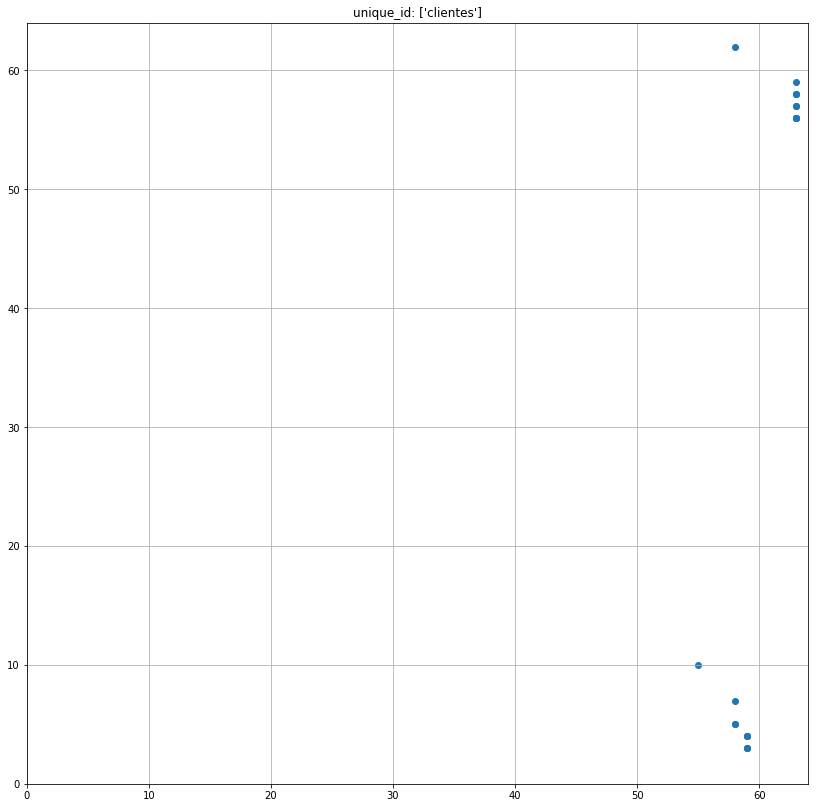

In [32]:
# PLOT SINGLE OR SMALL GROUP Of WORDS
import matplotlib.pyplot as plt
%matplotlib inline

#wrd = ['logiciel']
wrd = ['clientes']
#wrd = ['staffing']
#wrd = ['consulting']
#wrd = ['aws']
print pd.DataFrame(model.most_similar(positive=wrd, negative=[], topn=20)).head(10)

arrx, arry = retina.fingerprint_x_y(wrd, 20)
print arrx
print arry
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.scatter(arrx,arry)
plt.axis([0,x_width,0,y_width])
plt.grid()
plt.title("unique_id: {}".format(wrd))

plt.show()

# Convert table of word content to table of fingerprints

In [37]:
%%time
def create_fingerprint_from_line_file(sourcepath, targetpath, retina, density):
    with open(sourcepath, 'r') as source, open(targetpath, 'w') as target:
        count = 0
        for row in source.readlines():
            if count % 10000 == 0:
                print count
            count += 1
            elems = row.split('\t')
            url = elems[0].strip()
            words = elems[1].split(' ')
            binary = elems[2].strip()
            arr = retina.fingerprint(words, density=density)
            target.write("{}\t{}\t{}\n".format(binary, url, str(arr)))

fprintfile = 'data/fingerprint_all_good_tech_consult.tsv'
create_fingerprint_from_line_file('data/urls_all_good_tech_consult.tsv', fprintfile, retina, 0)


0
10000
20000
30000
40000
50000
60000
70000
80000
CPU times: user 1min 5s, sys: 879 ms, total: 1min 6s
Wall time: 1min 6s


# Apply a filter to a table of fingeprints

In [29]:
%%time
import operator
# Apply a filter and return score per fingerprint to a table of fingerprints
fprintfile = 'data/fingerprint_all_good_tech_consult.tsv'
targetpath = 'data/filterscore_all_good_tech_consult.tsv'
         #x_0, y_0, x_1, y_1
filters = [
    [56,61,19,27],
    [55,60,2,9],
    [22,29,55,63], 
    [40,50,0,10], 
    [60,64,48,60] 
]
filter_names = [
    "turkish",
    "brazilian",
    "german",
    "french",
    "spanish"
]

def apply_filter(sourcepath, targetpath, filters, filter_names):
    with open(sourcepath, 'r') as source, open(targetpath, 'w') as target:
        count = 0
        for line in source:
            if count % 10000 == 0:
                print count
            count += 1
            cols = line.split('\t')
            
            binary = int(cols[0].strip())
            url = str(cols[1].strip())
            fingerprint = eval(cols[2])
            length = len(fingerprint)
            scores = []
            for filt in filters:
                scores.append(get_count_in_box(fingerprint, filt))
            index, value = max(enumerate(scores), key=operator.itemgetter(1))
            if value > 0.2:
                name = filter_names[index]
            else:
                name = 'z_none'
            target.write("{}\t{}\t{}\t{}\t{}\n".format(str(binary), url, length, name,  str("\t".join(map(lambda x: str(x), scores)))))
            

            
def get_count_in_box(fingerprint, filter):
    count = 0
    total = len(fingerprint)
    if total < 1:
        return 0
    for x, y in fingerprint:
        if x > filter[0] and x < filter[1] and y > filter[2] and y < filter[3]:
                    count += 1
    return count/float(total)

apply_filter(fprintfile, targetpath, filters, filter_names)

0
10000
20000
30000
40000
50000
60000
70000
80000
CPU times: user 2min 17s, sys: 2.7 s, total: 2min 19s
Wall time: 2min 20s


# Create png images from table of fingerprints

0


/Users/efrainolivares/envnltk/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

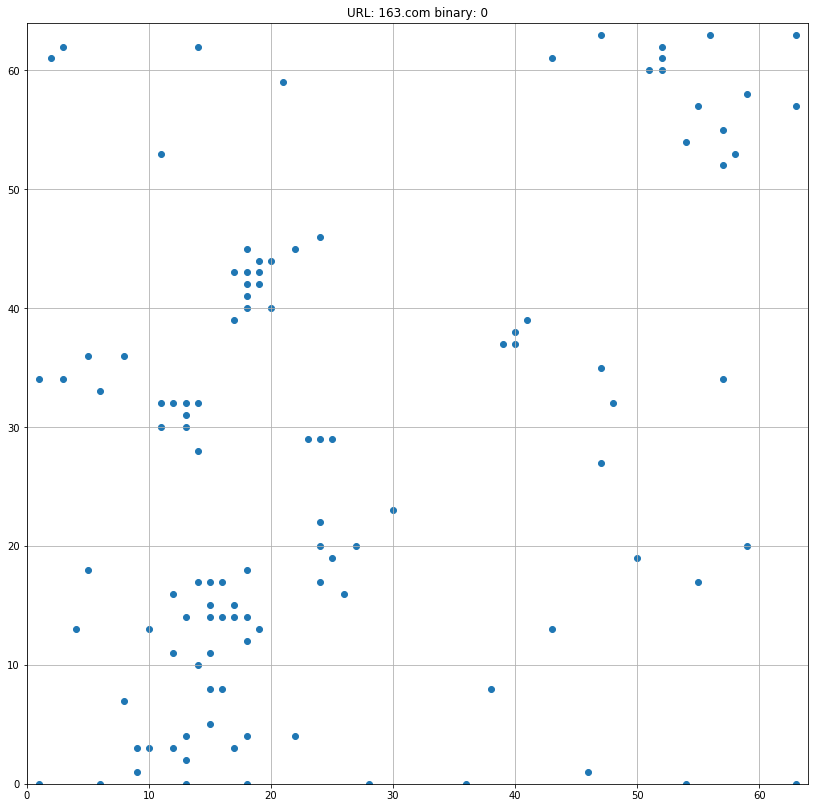

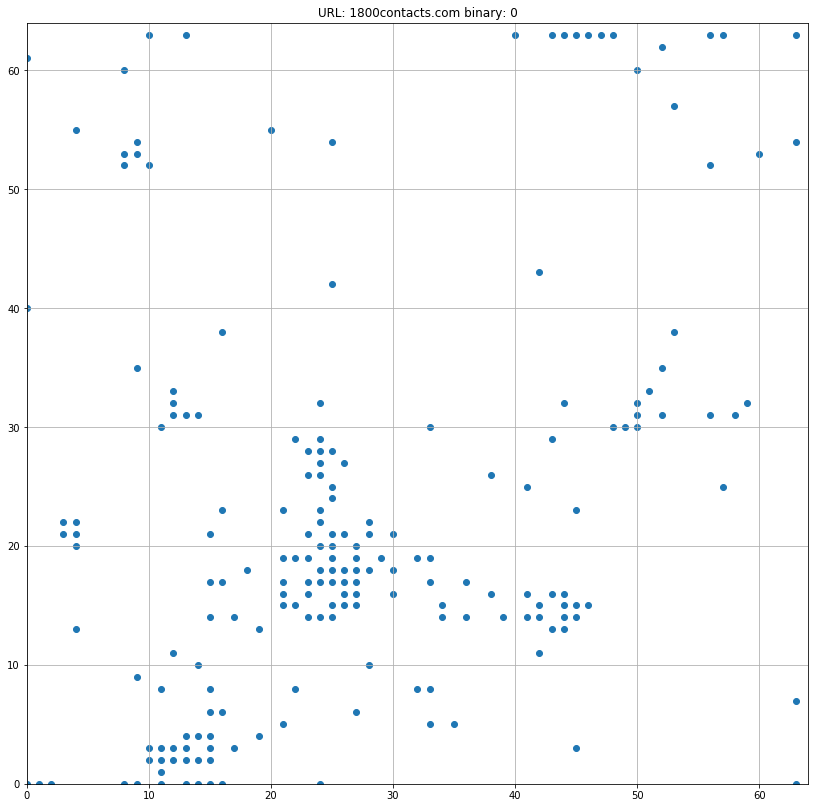

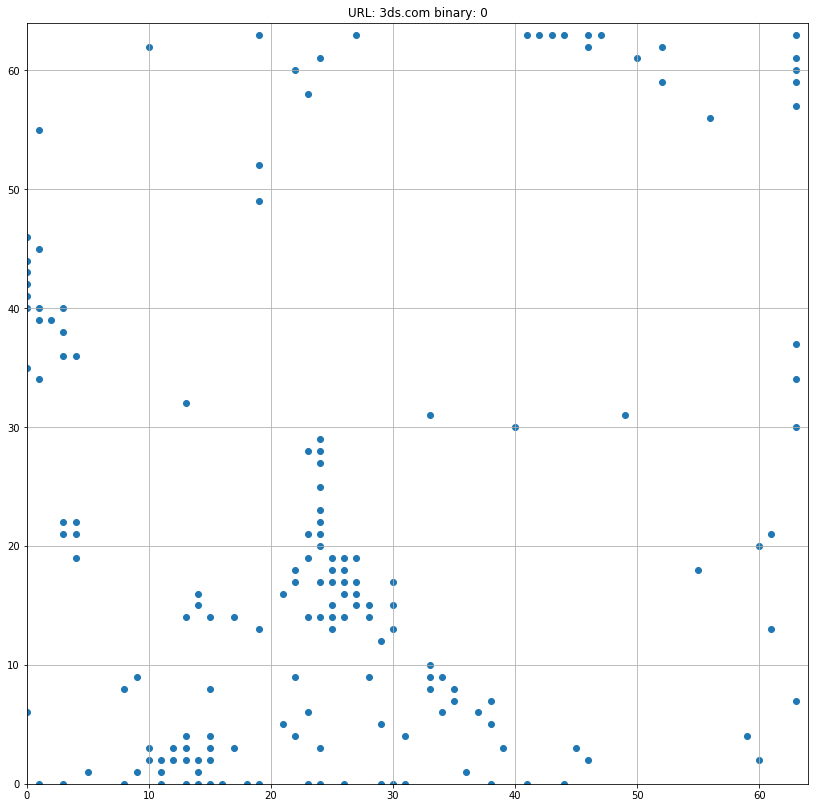

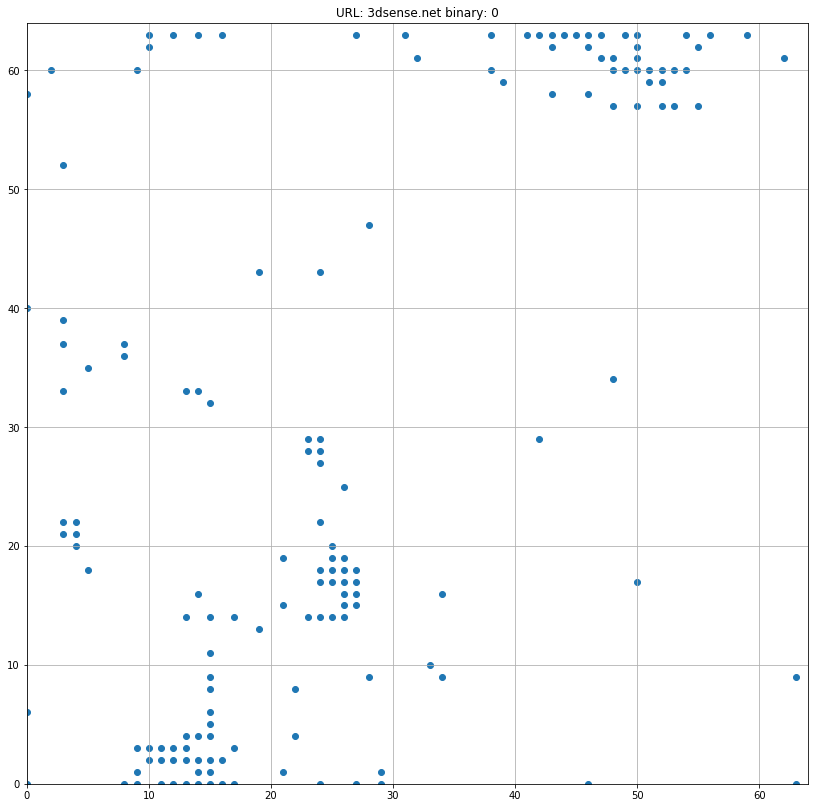

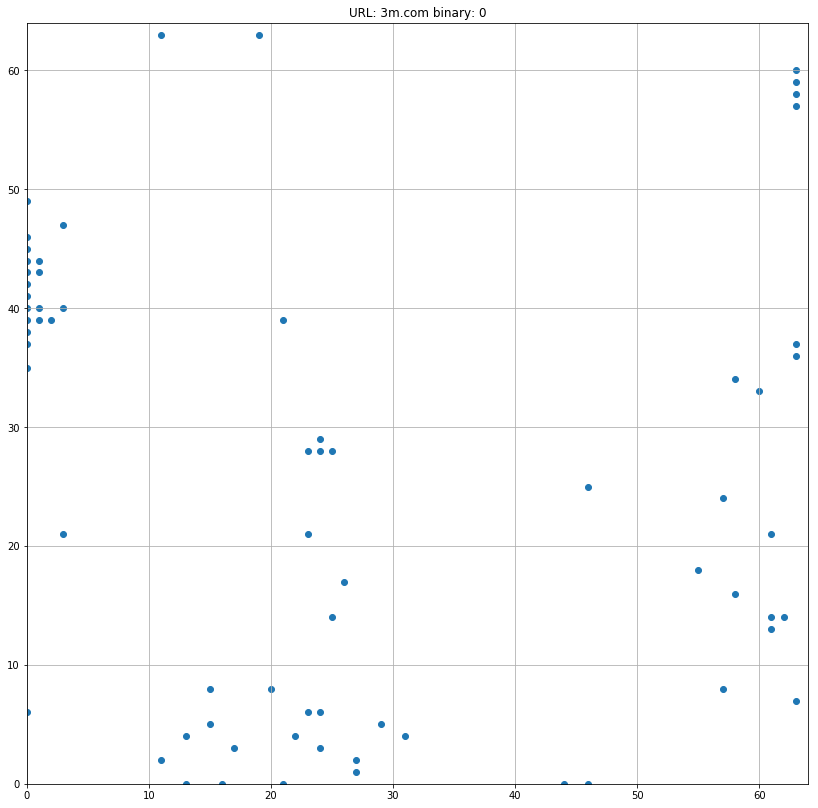

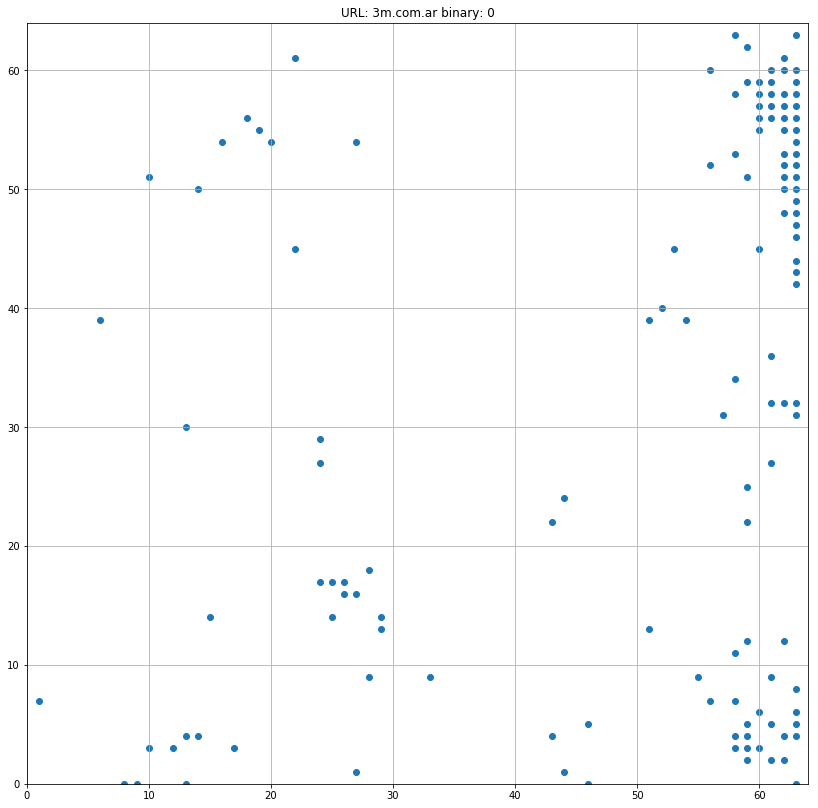

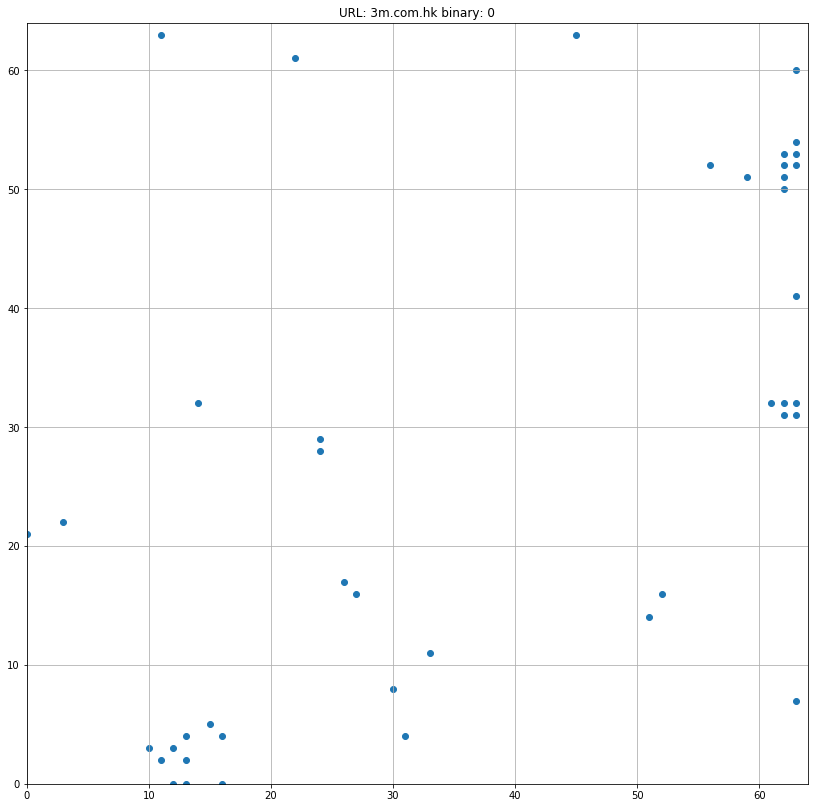

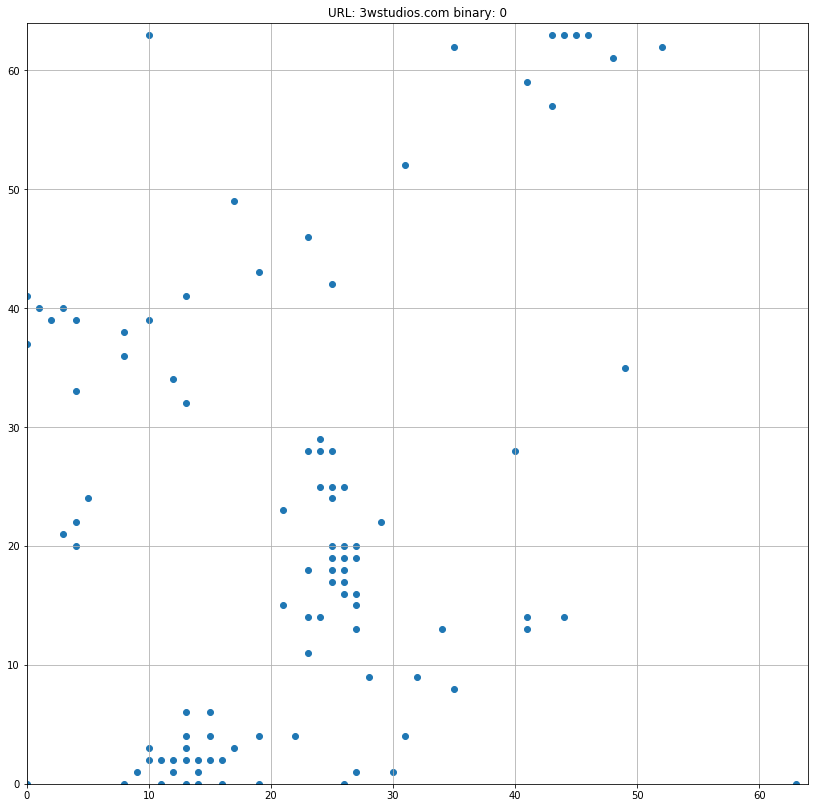

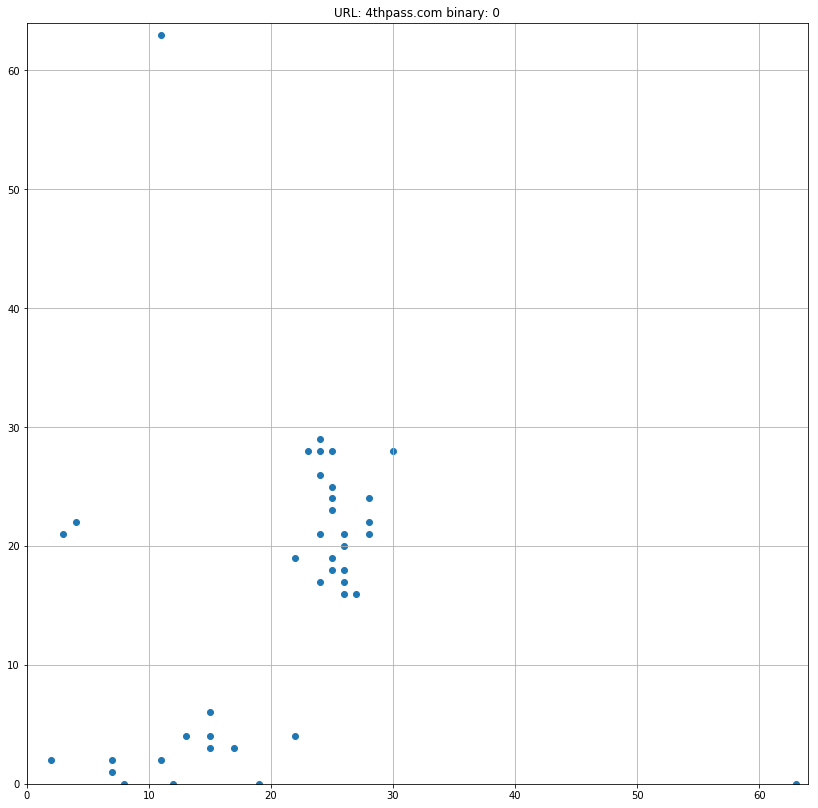

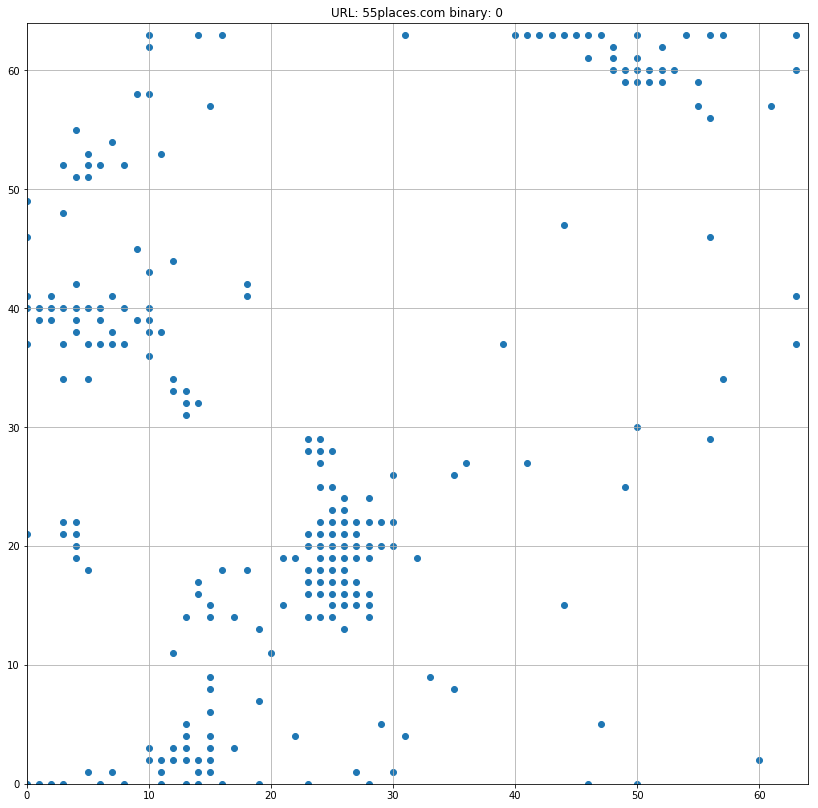

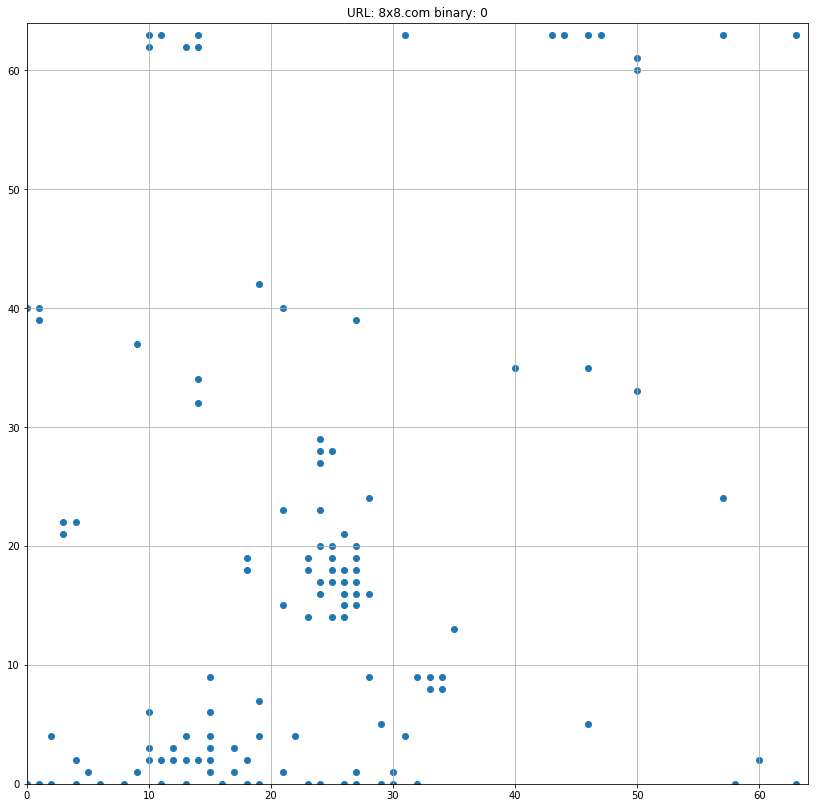

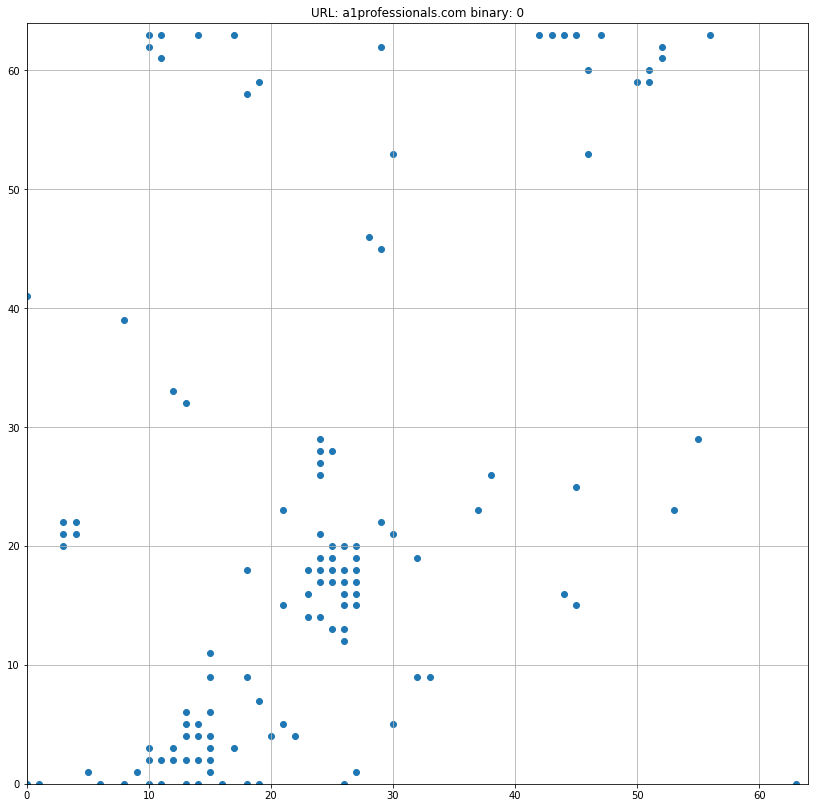

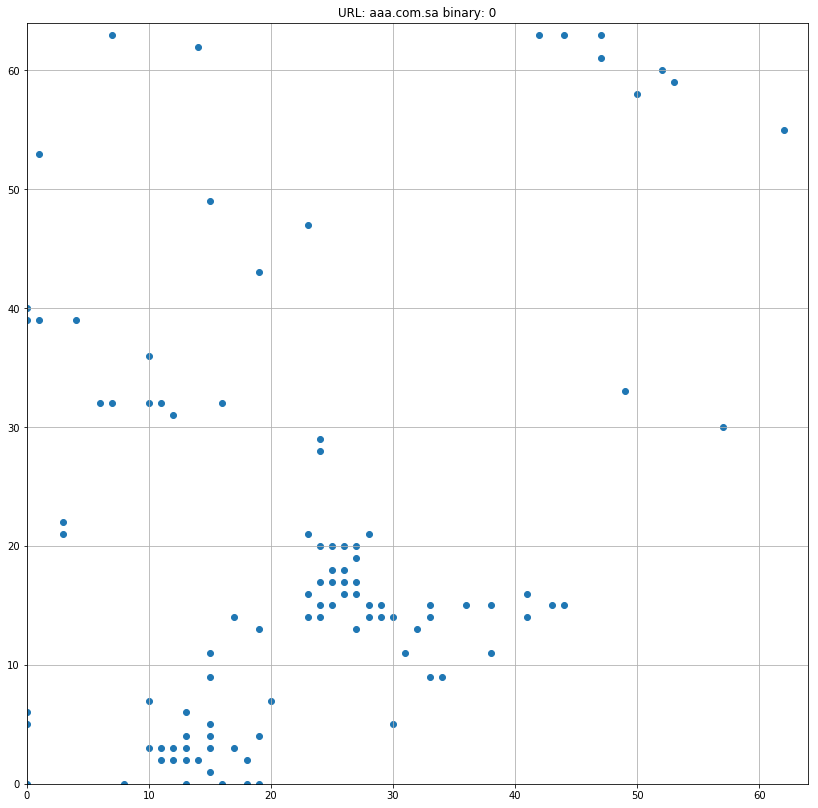

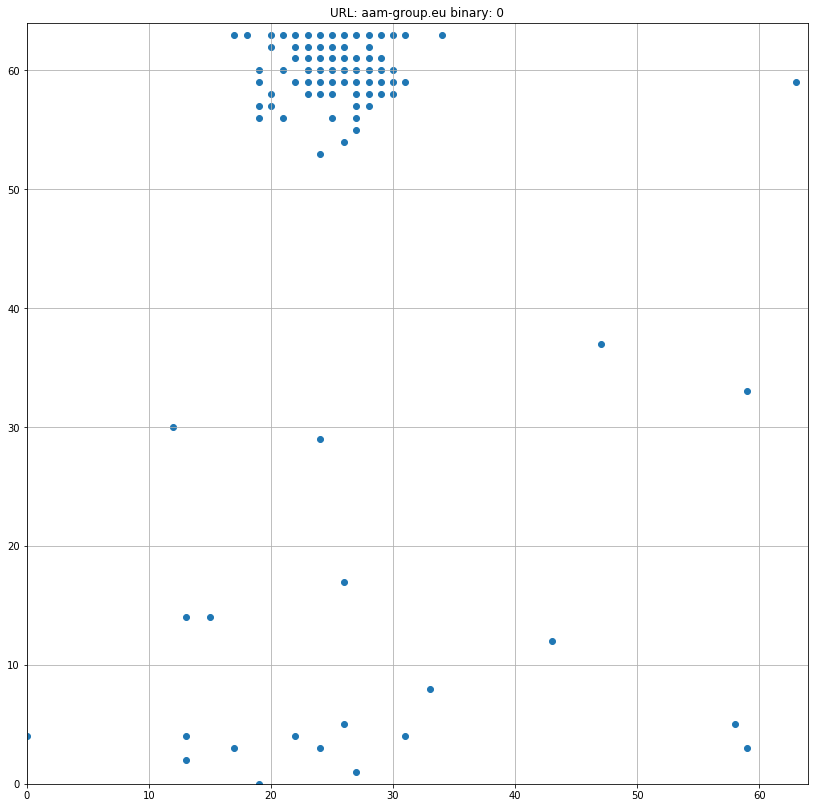

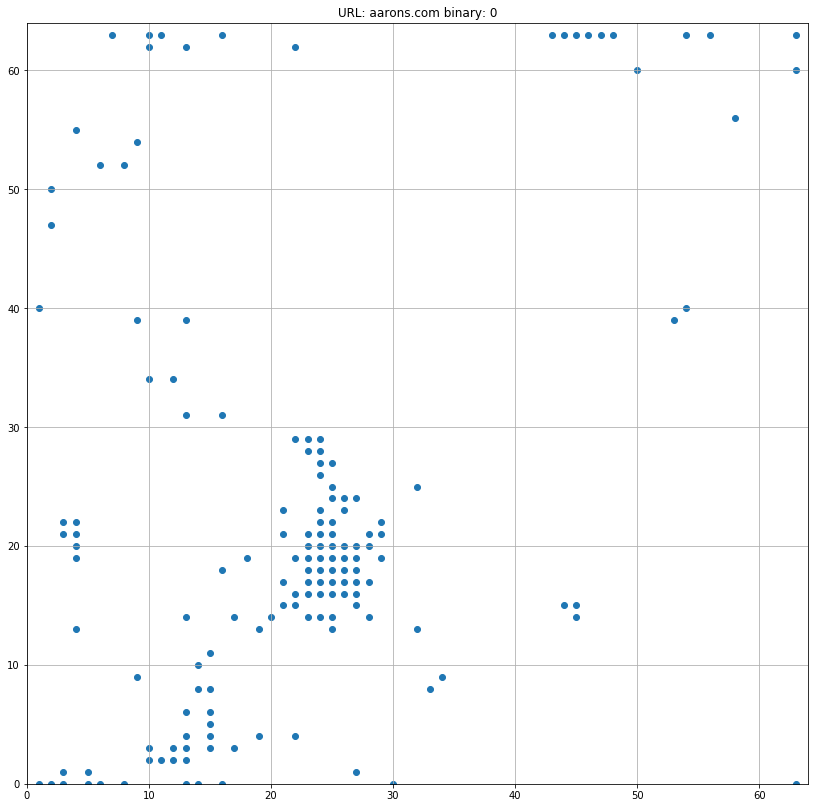

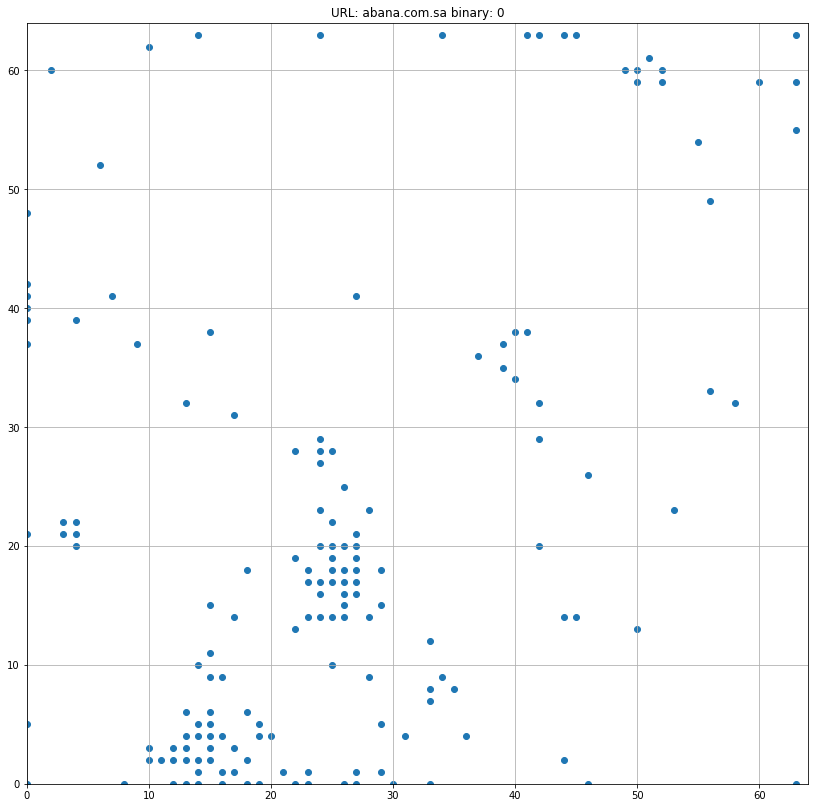

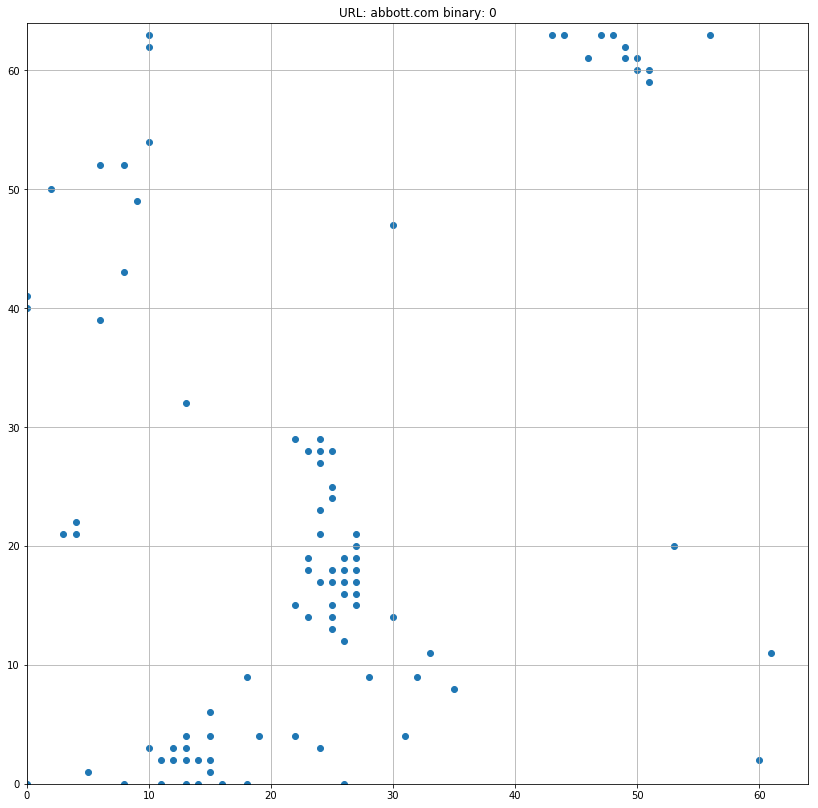

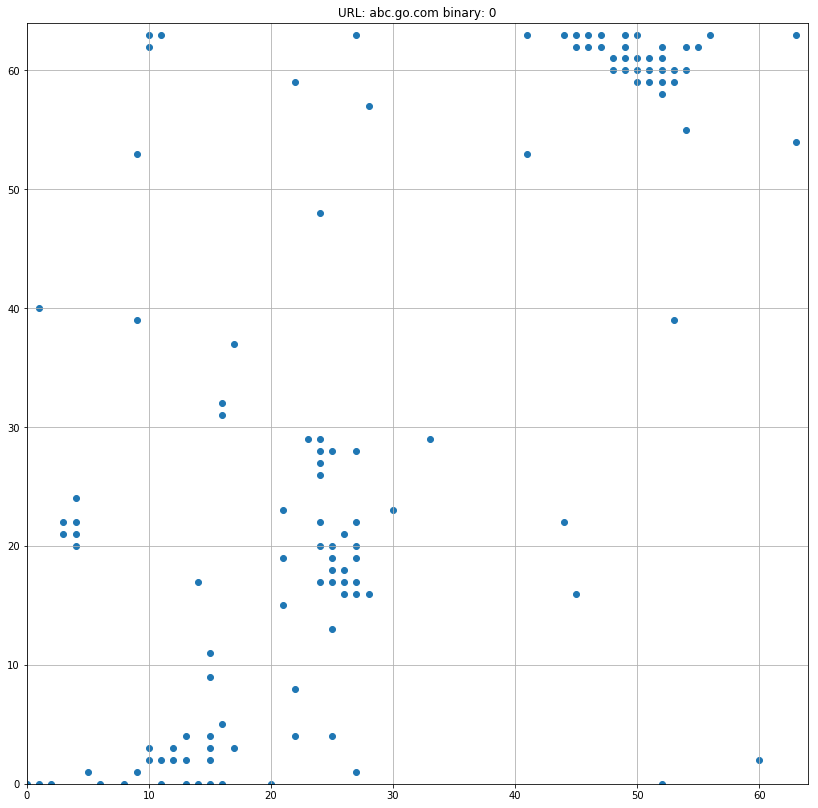

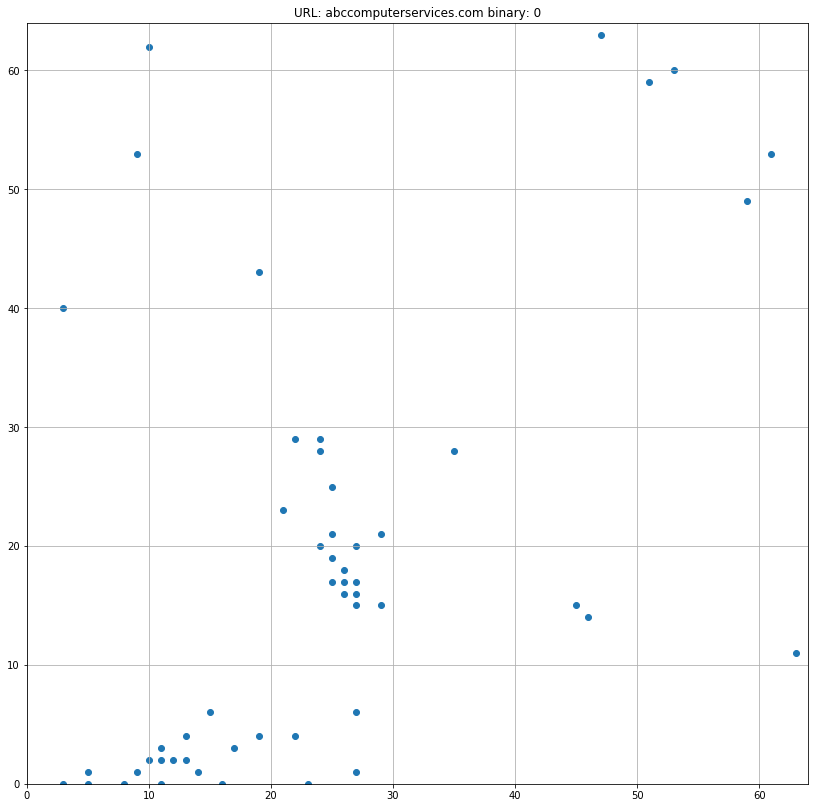

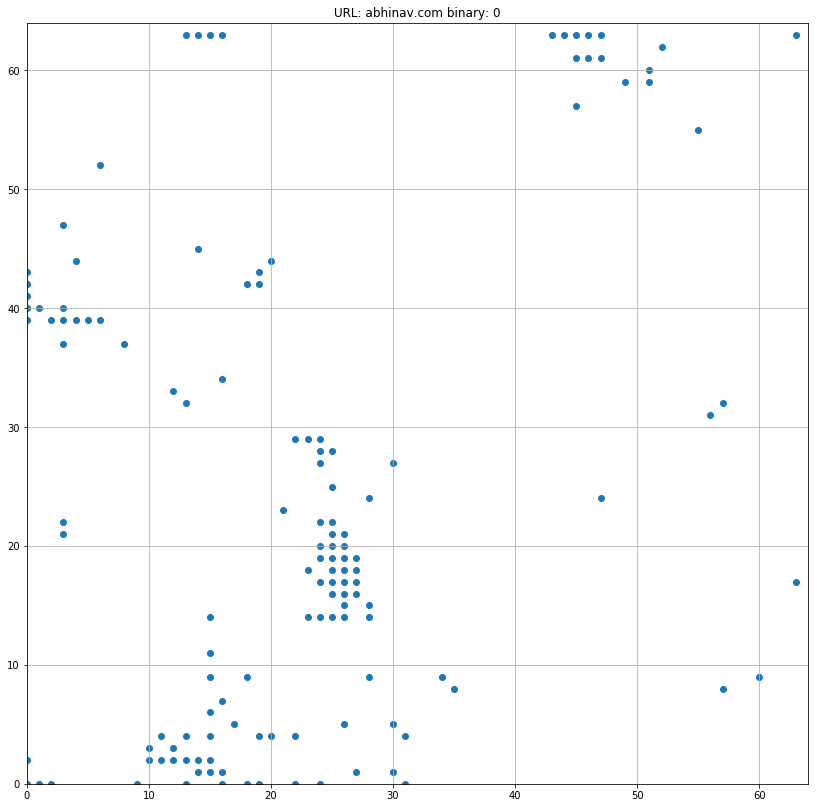

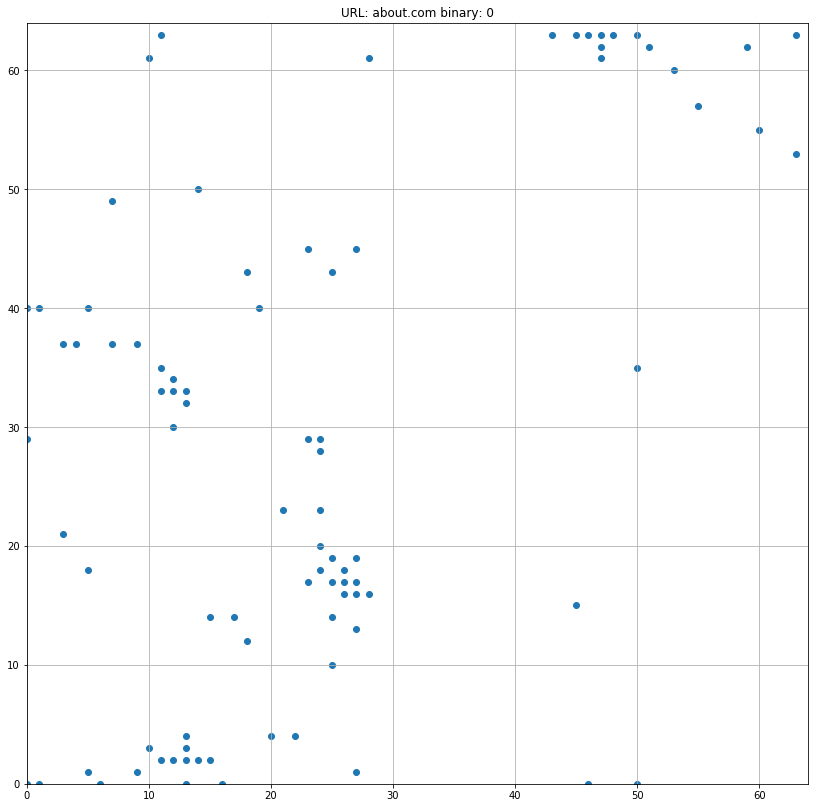

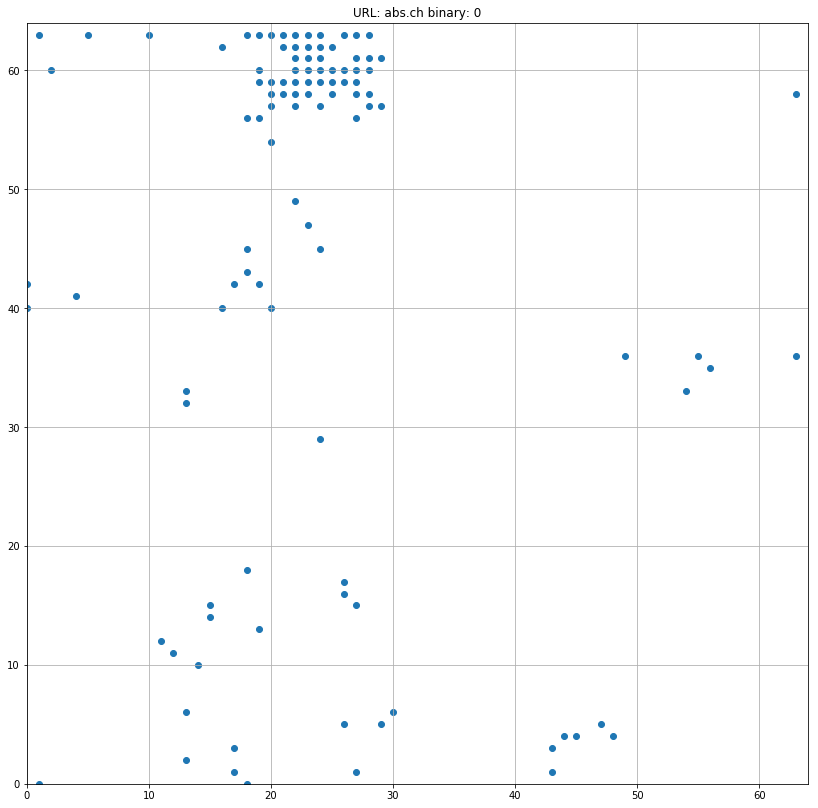

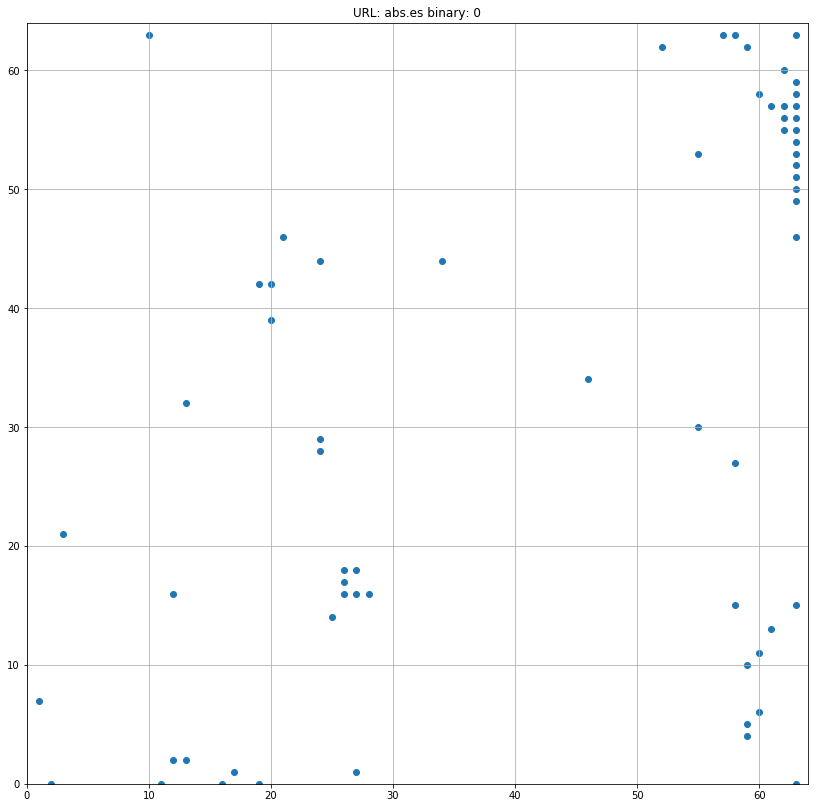

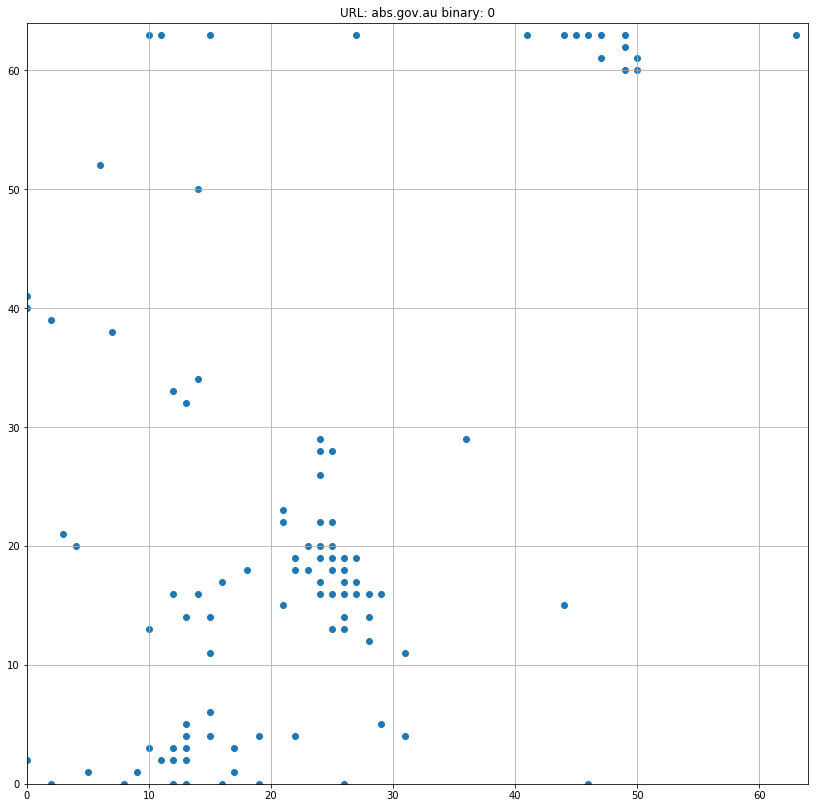

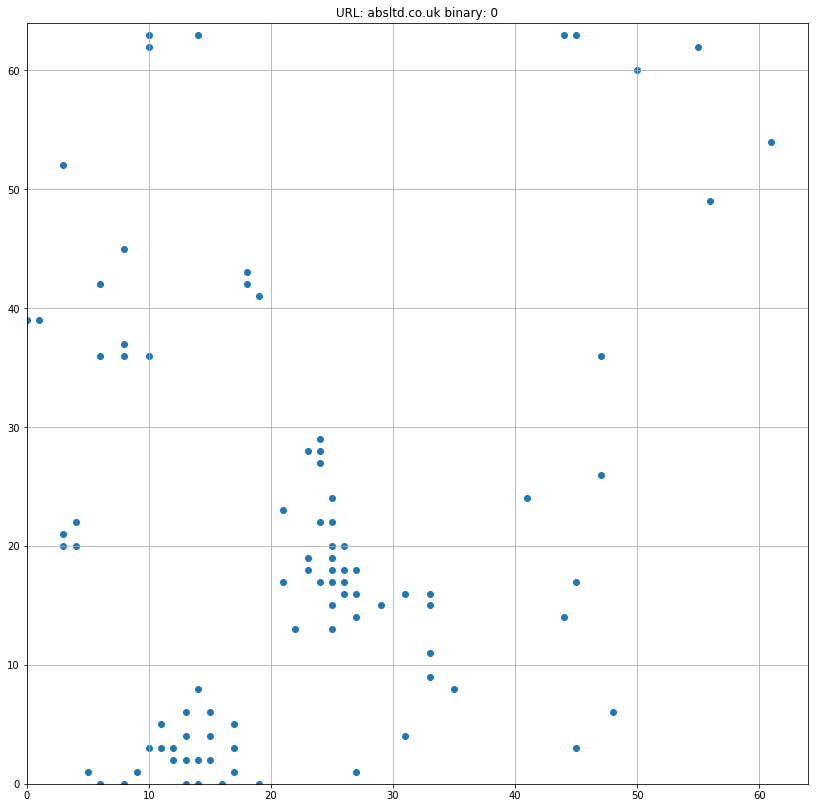

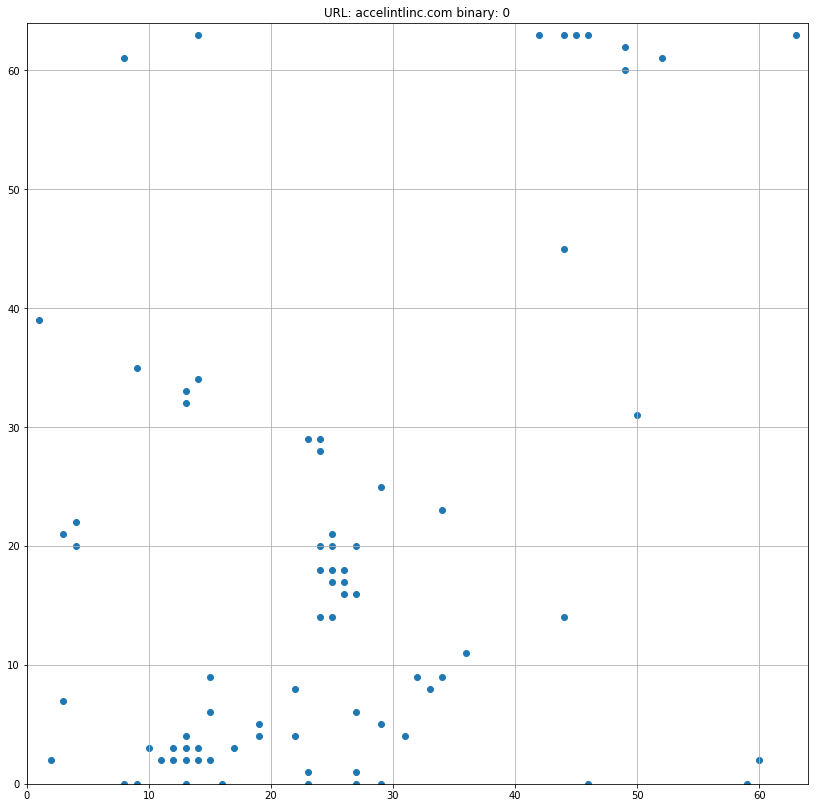

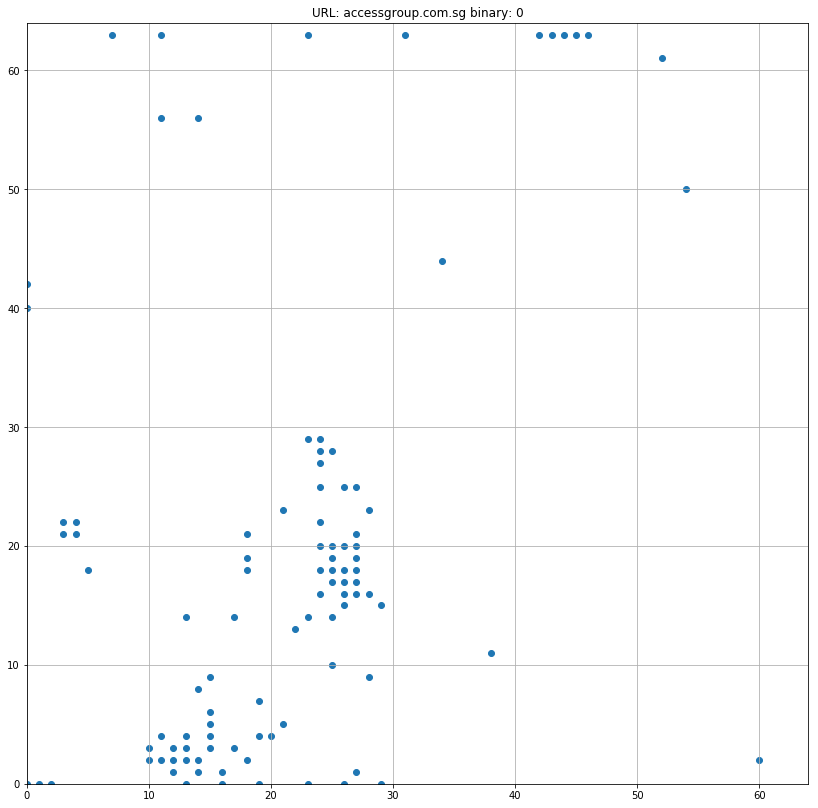

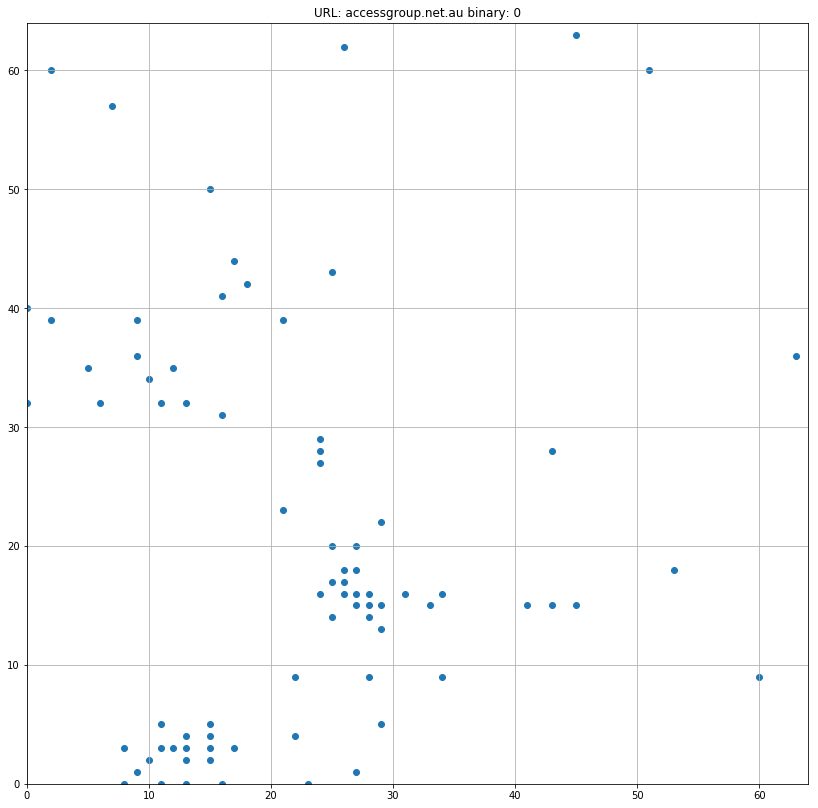

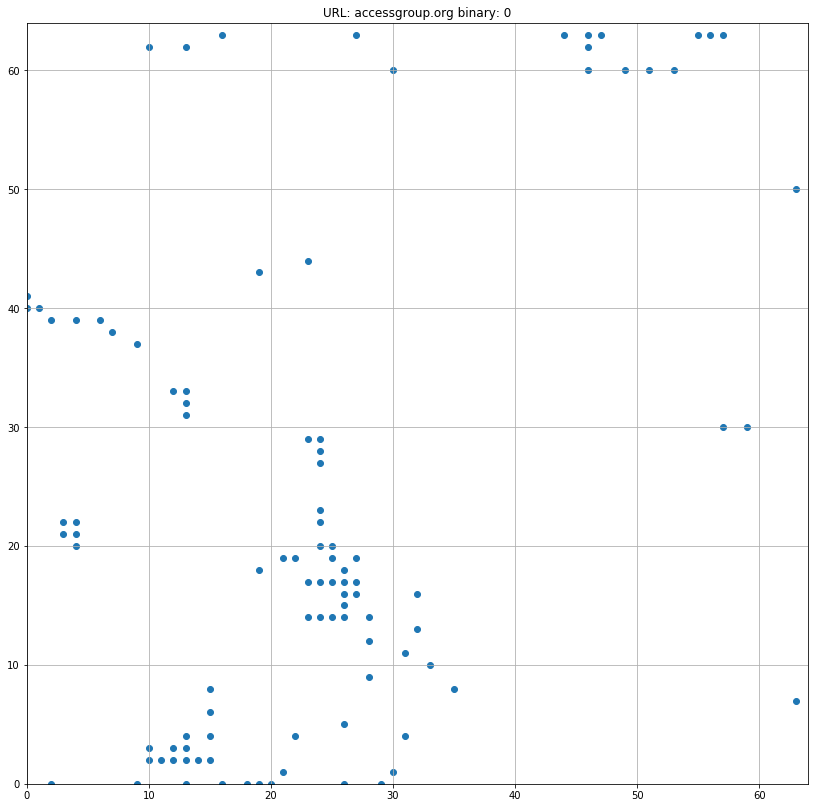

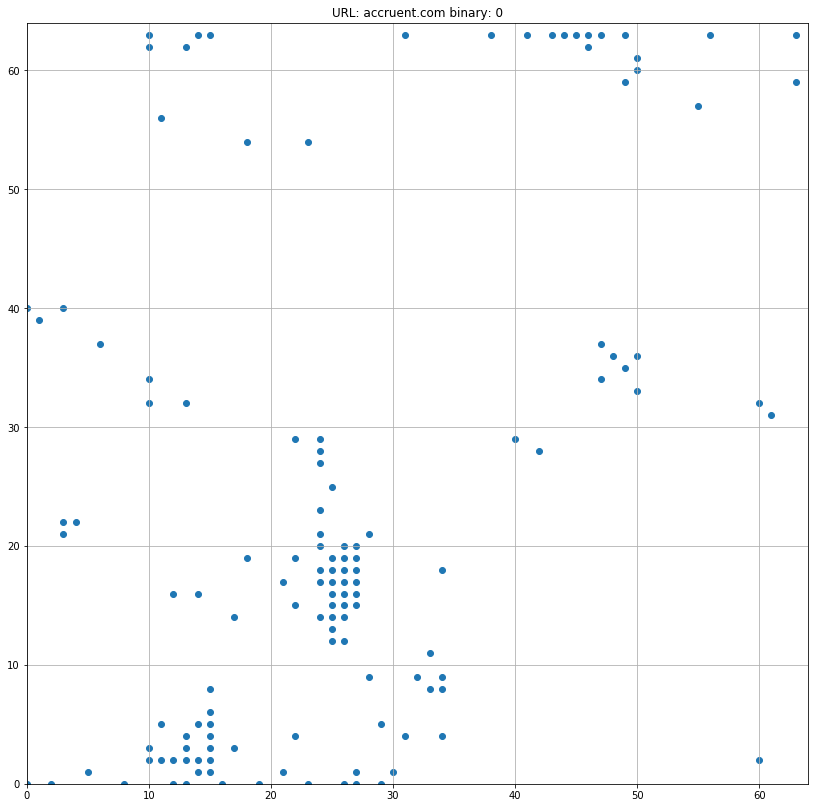

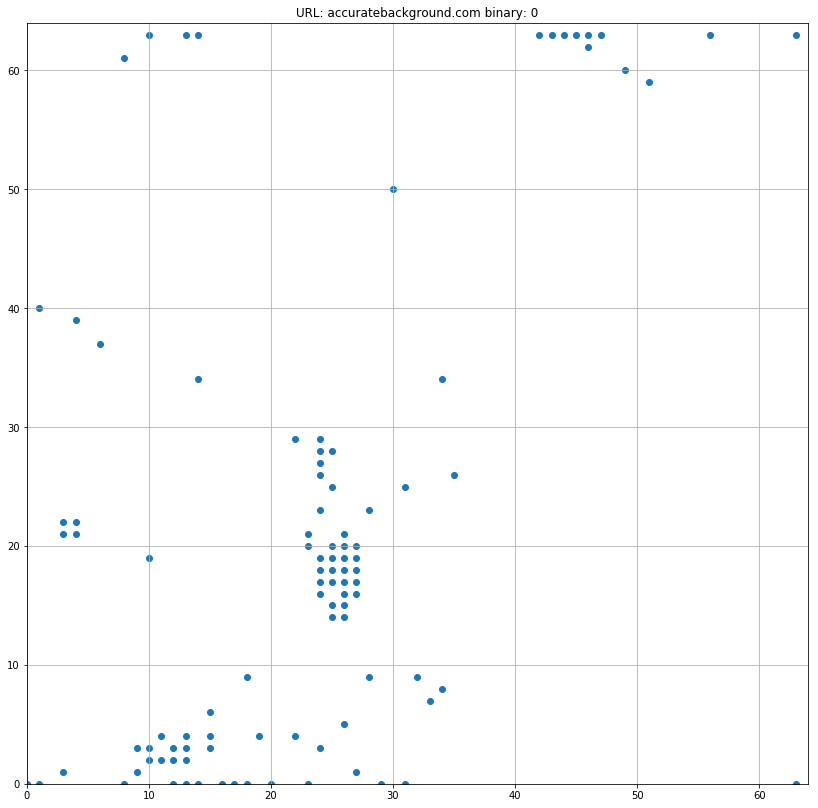

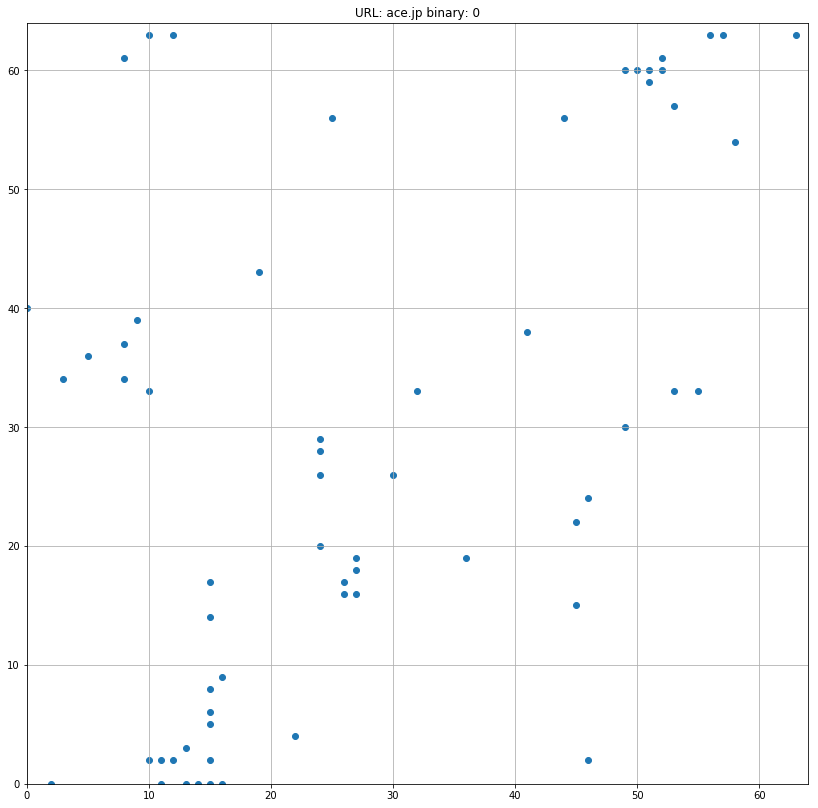

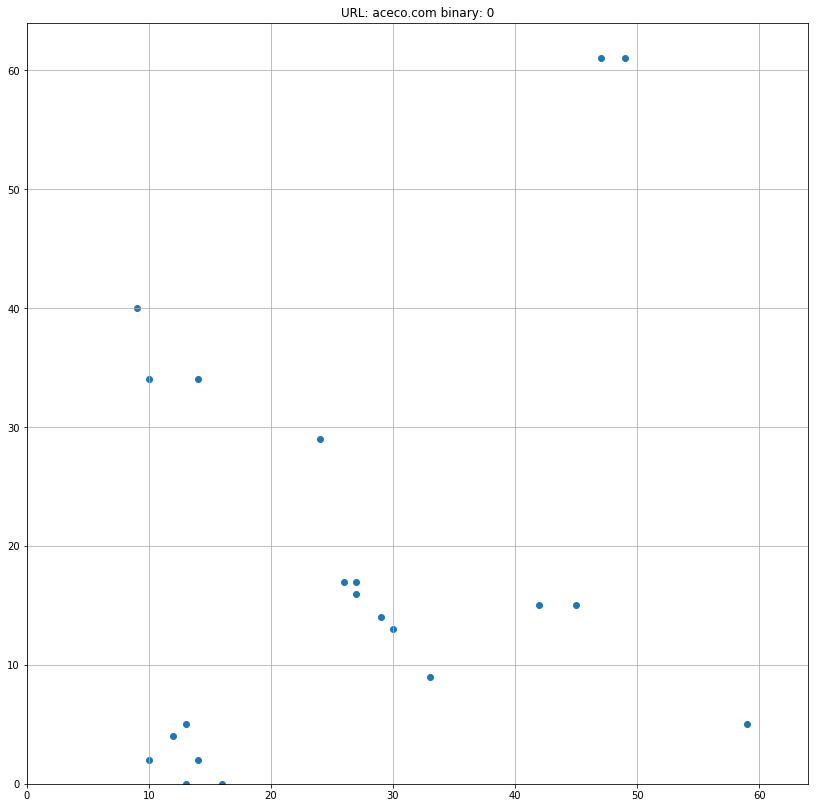

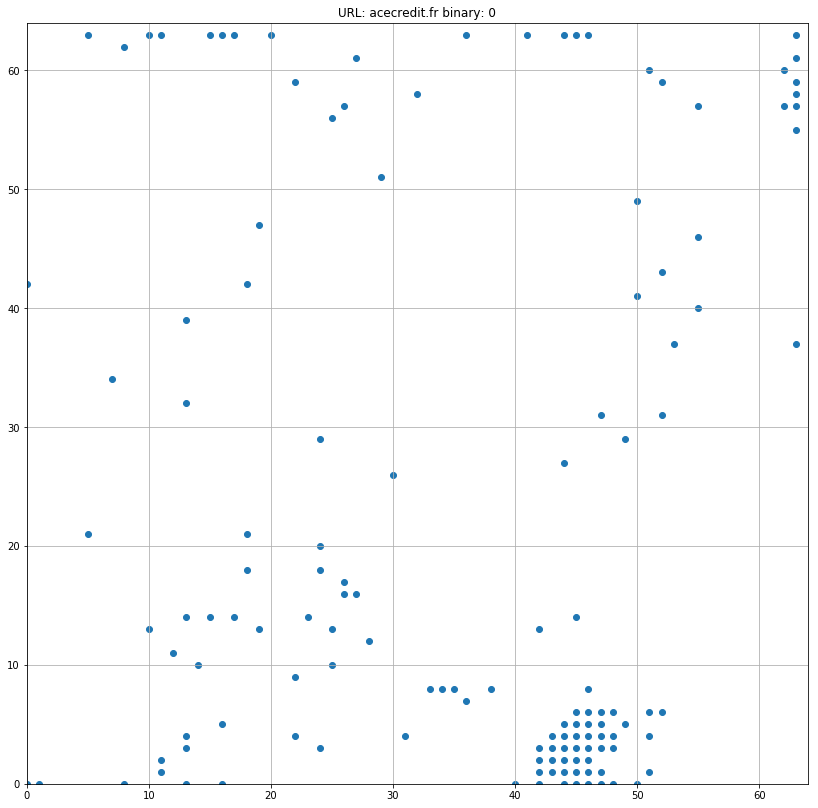

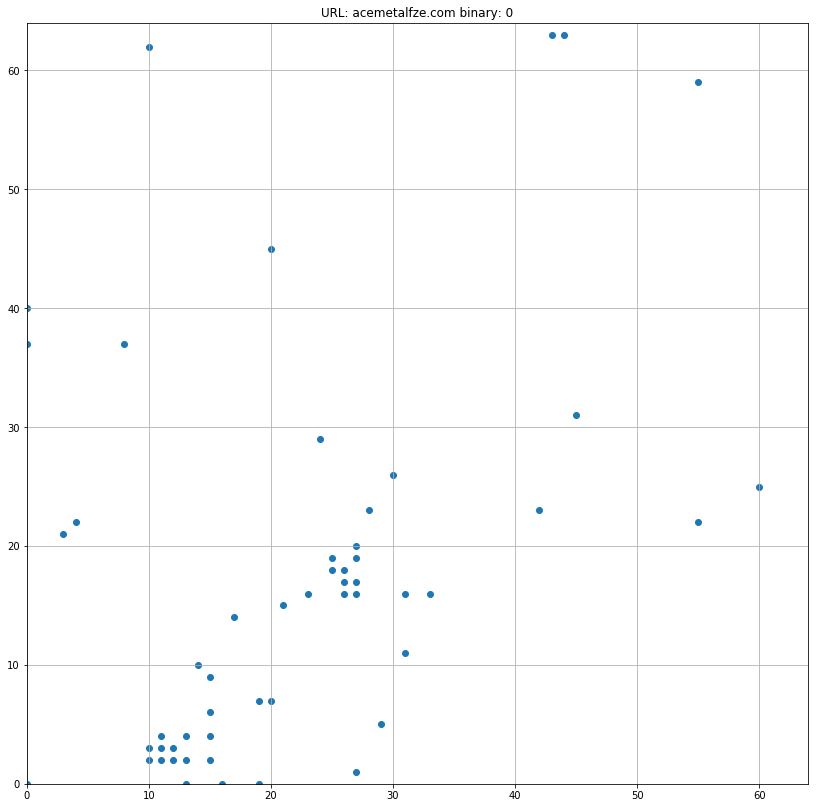

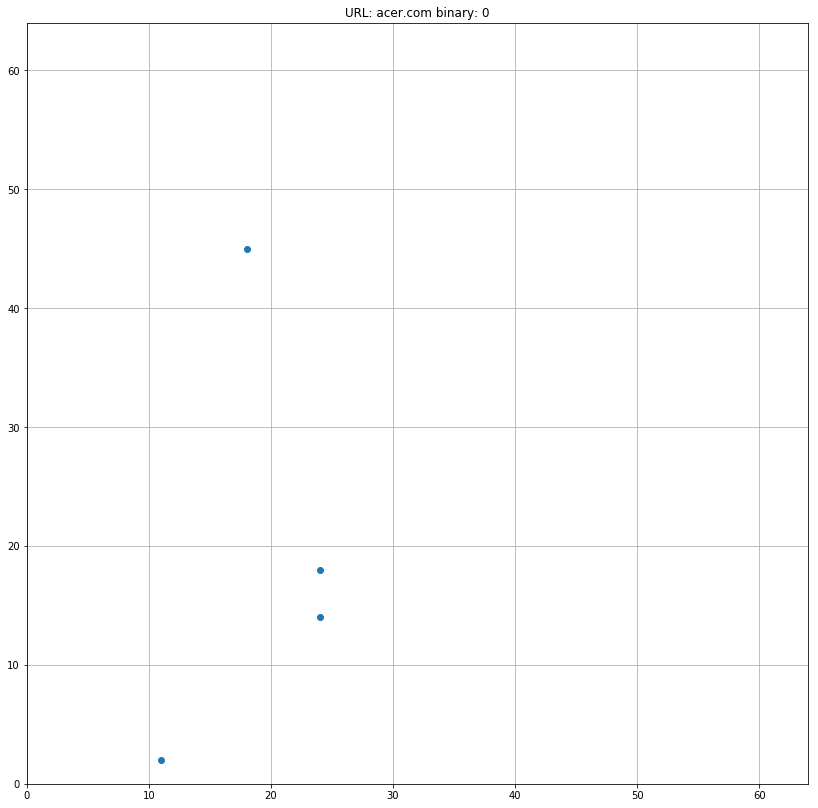

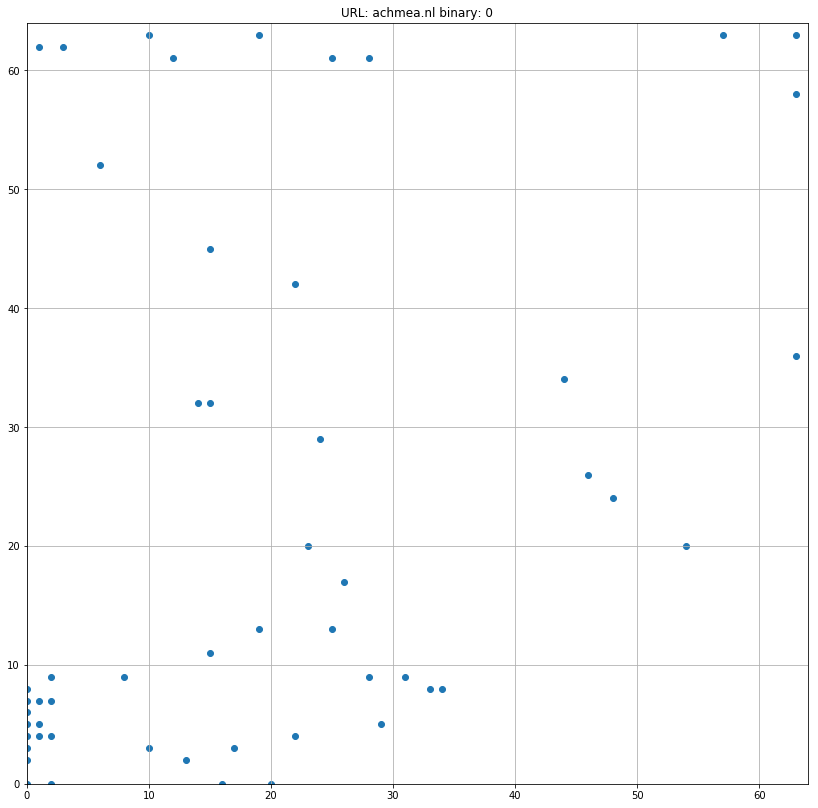

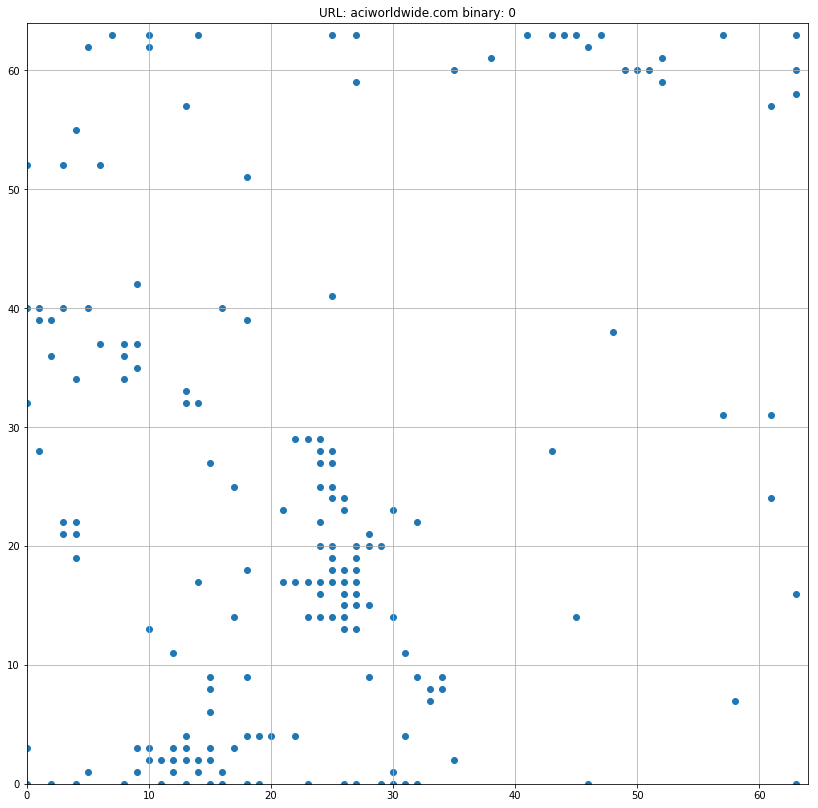

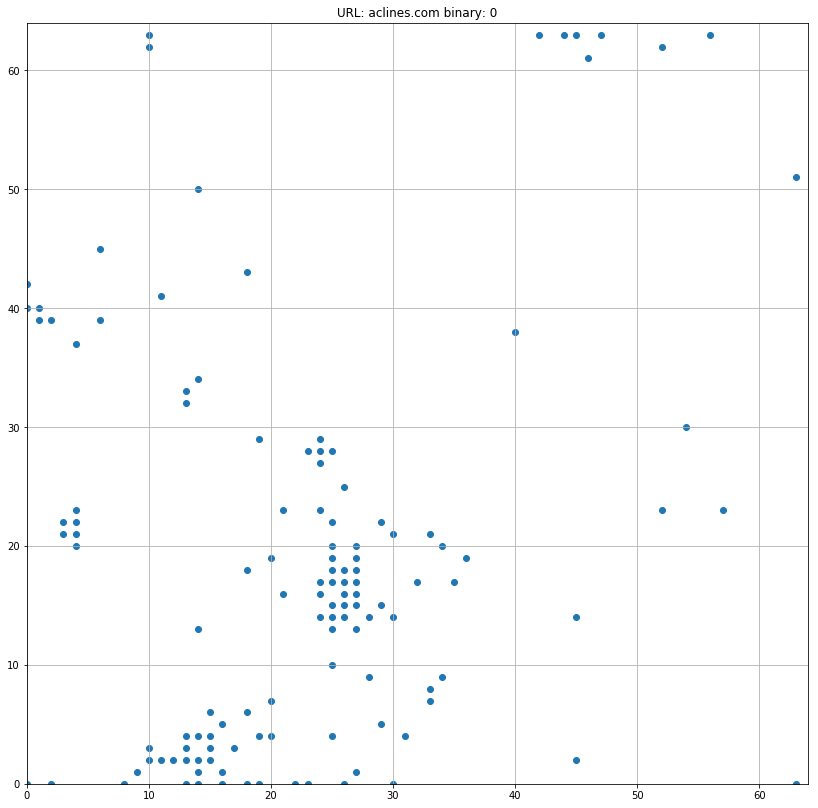

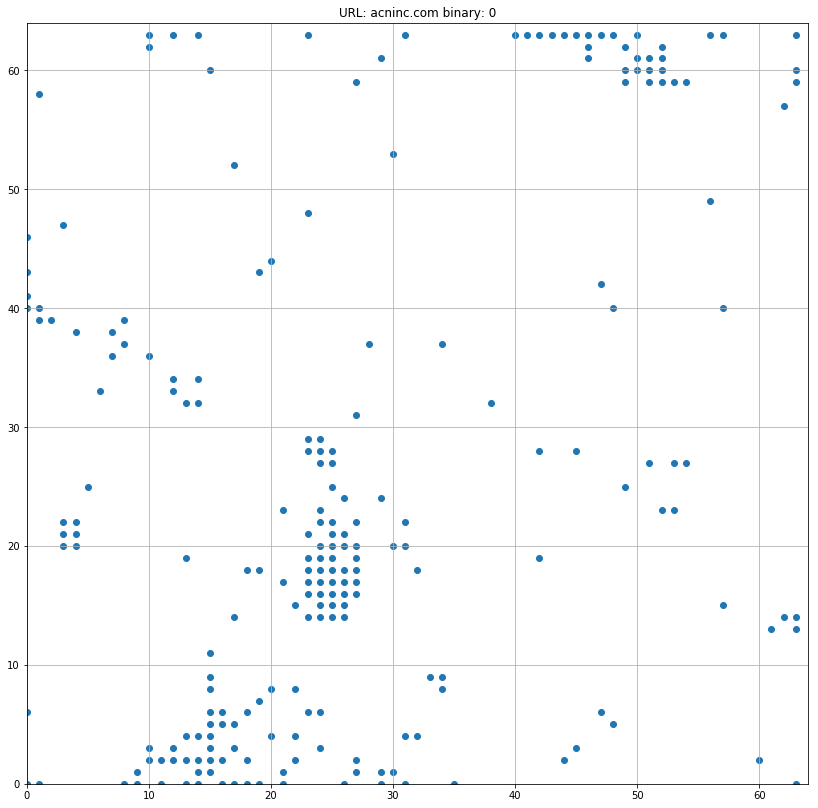

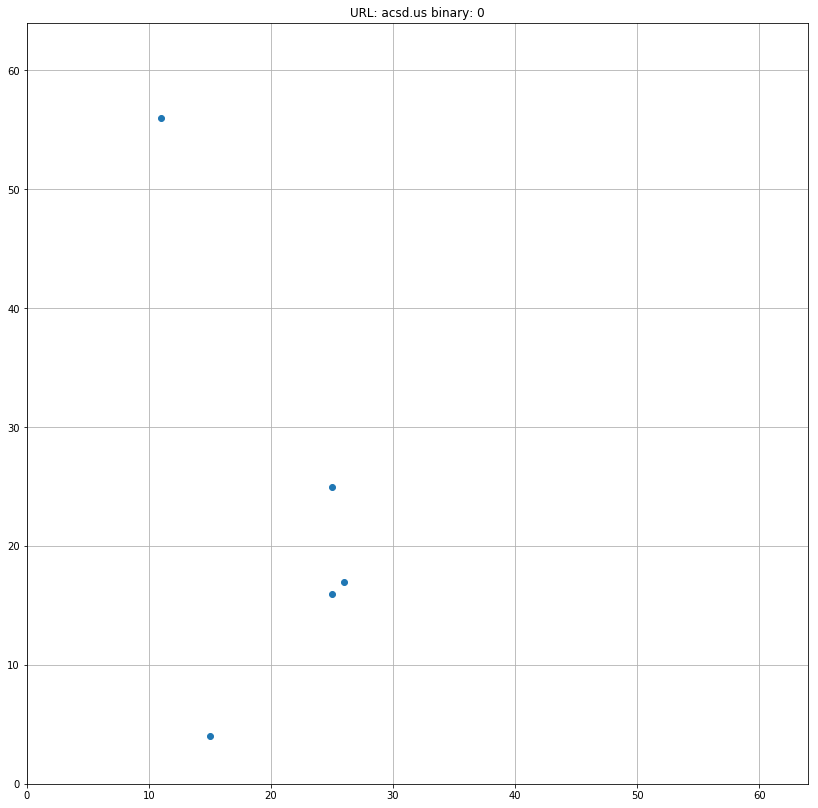

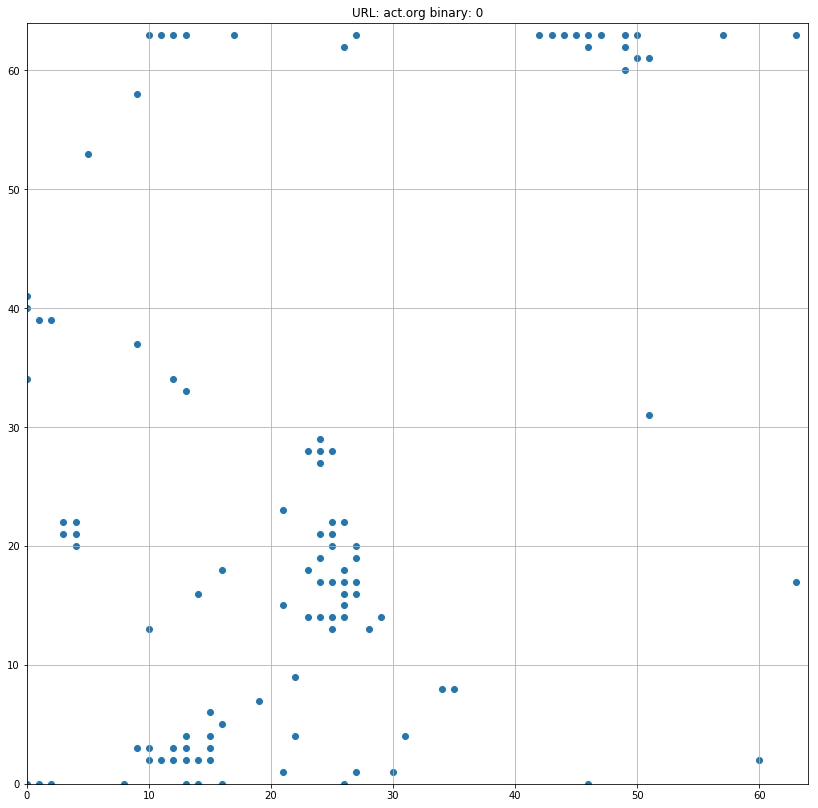

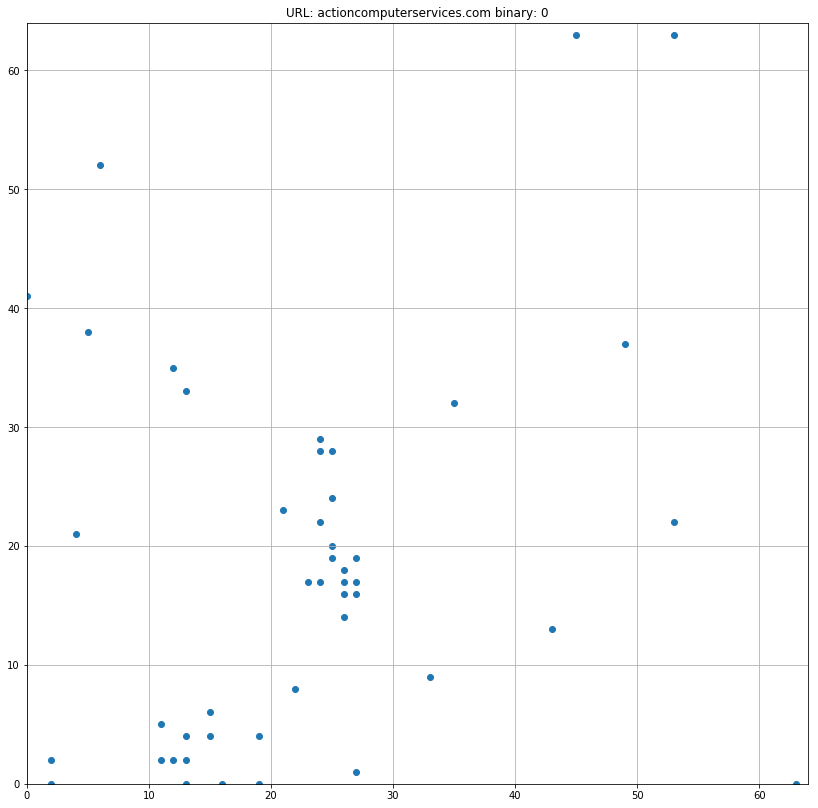

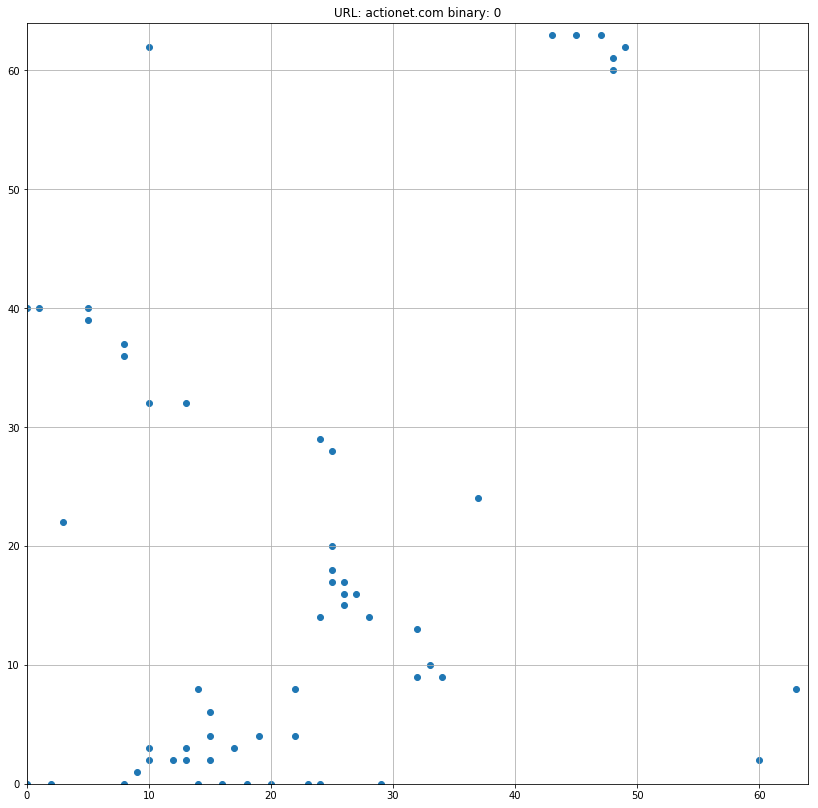

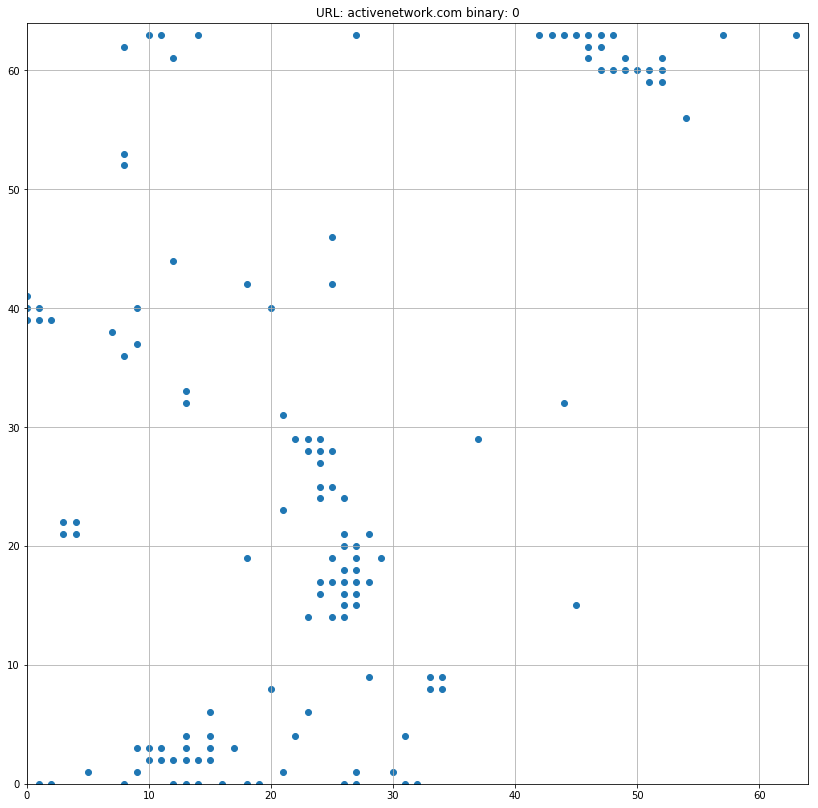

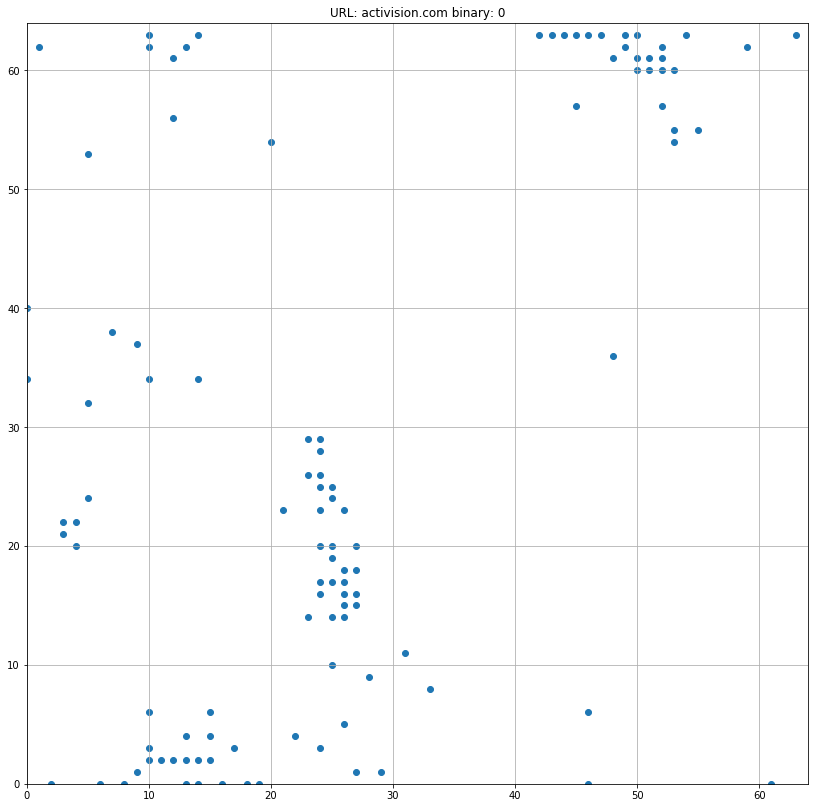

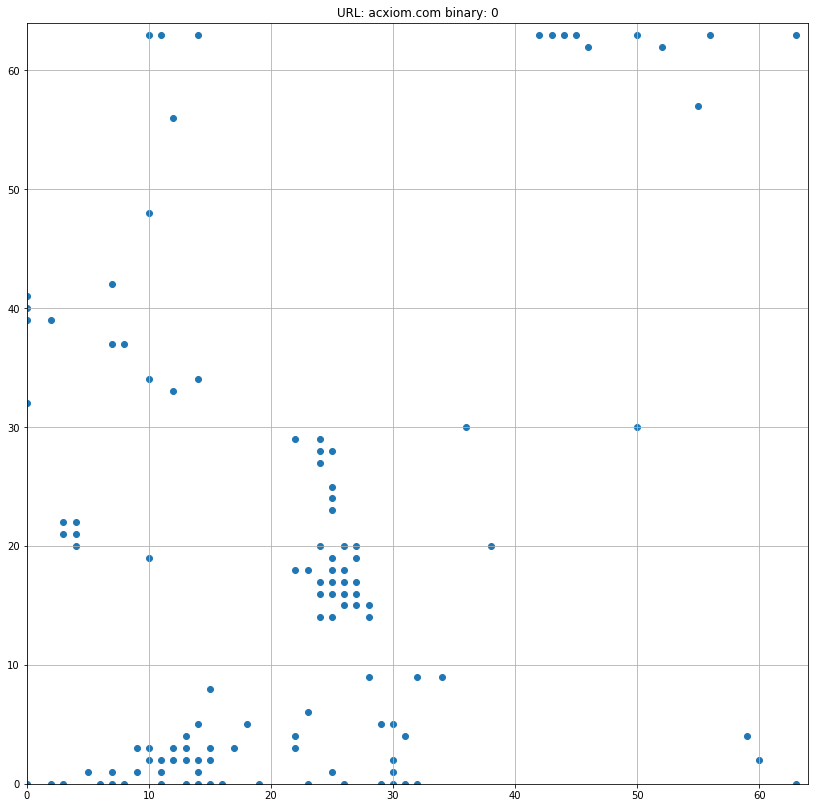

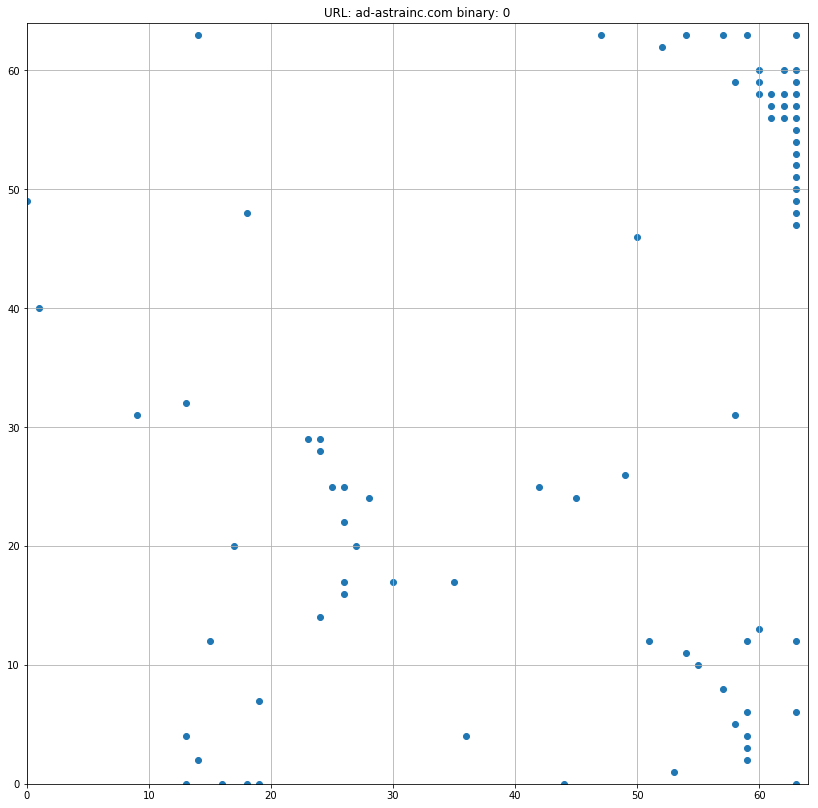

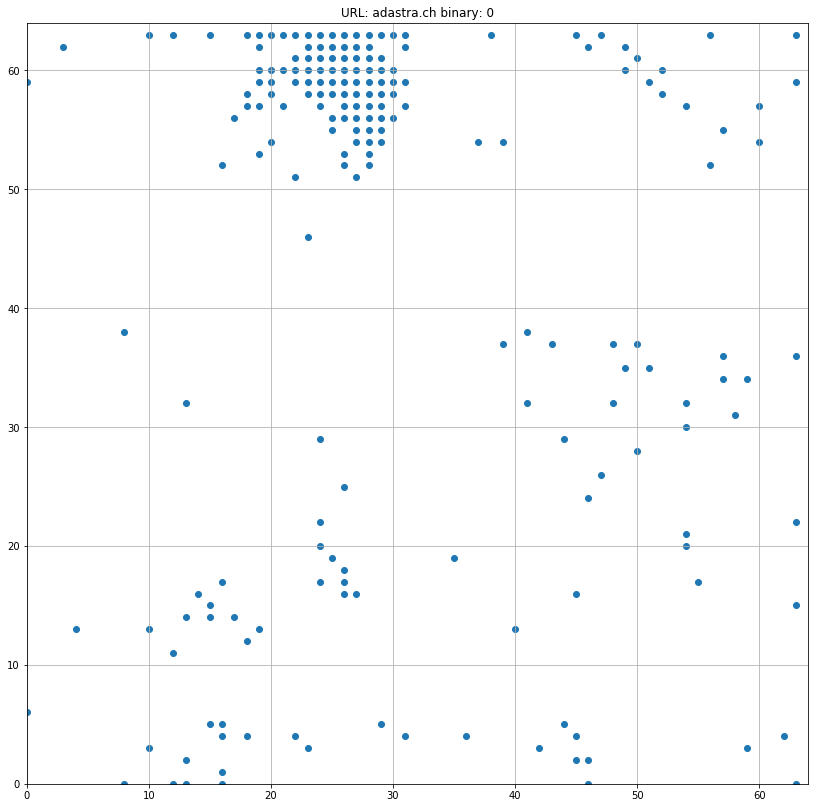

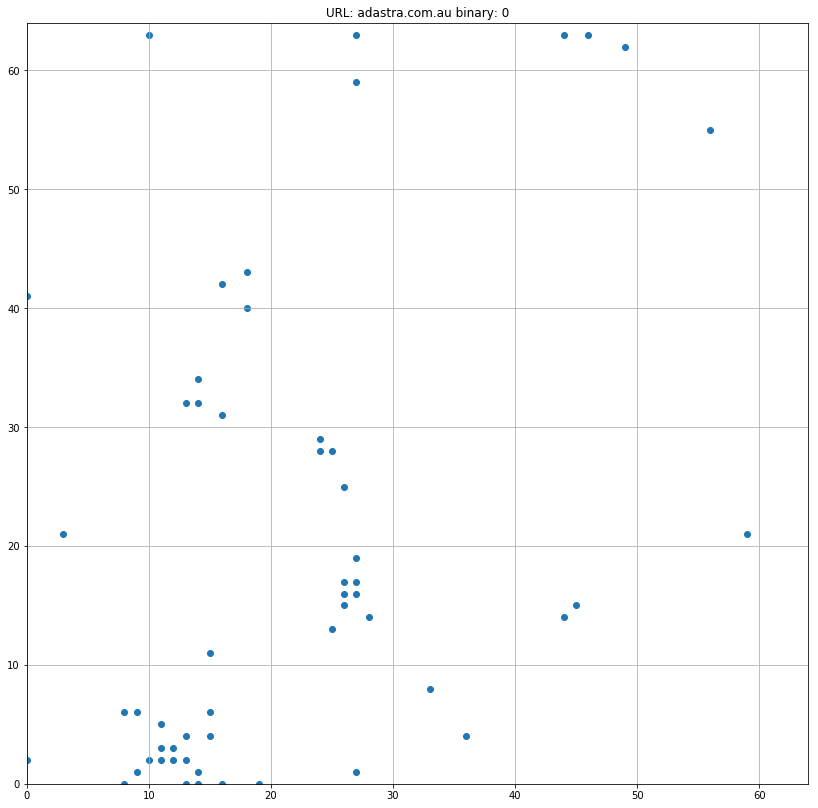

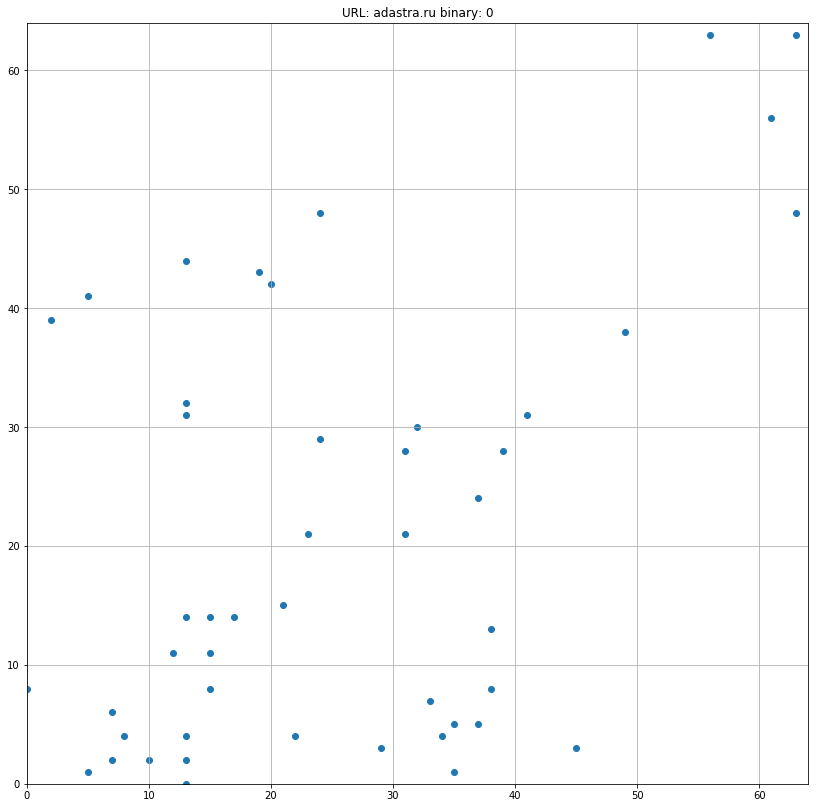

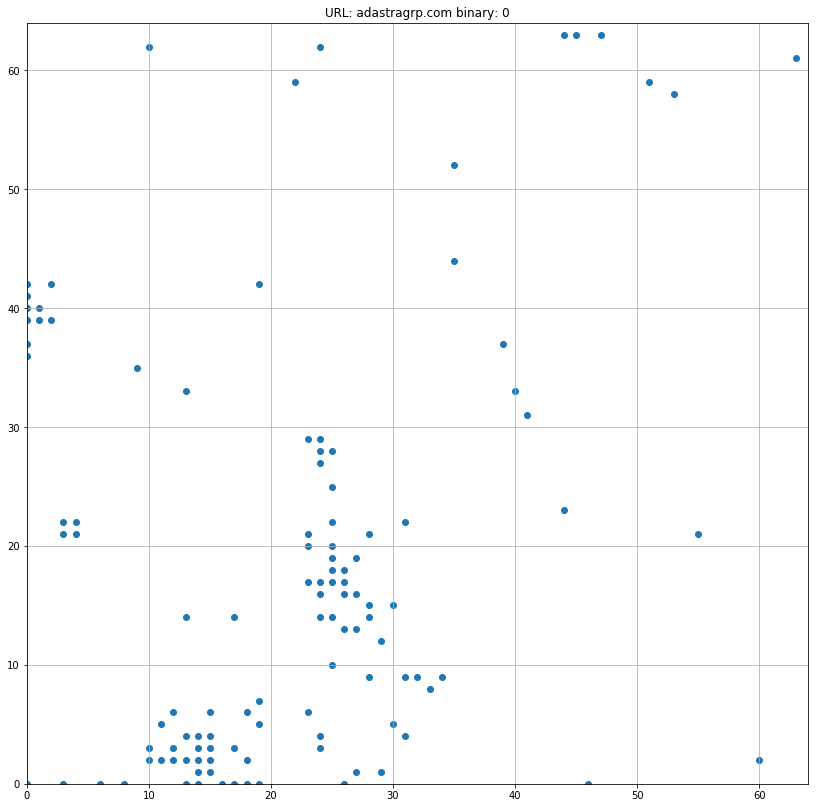

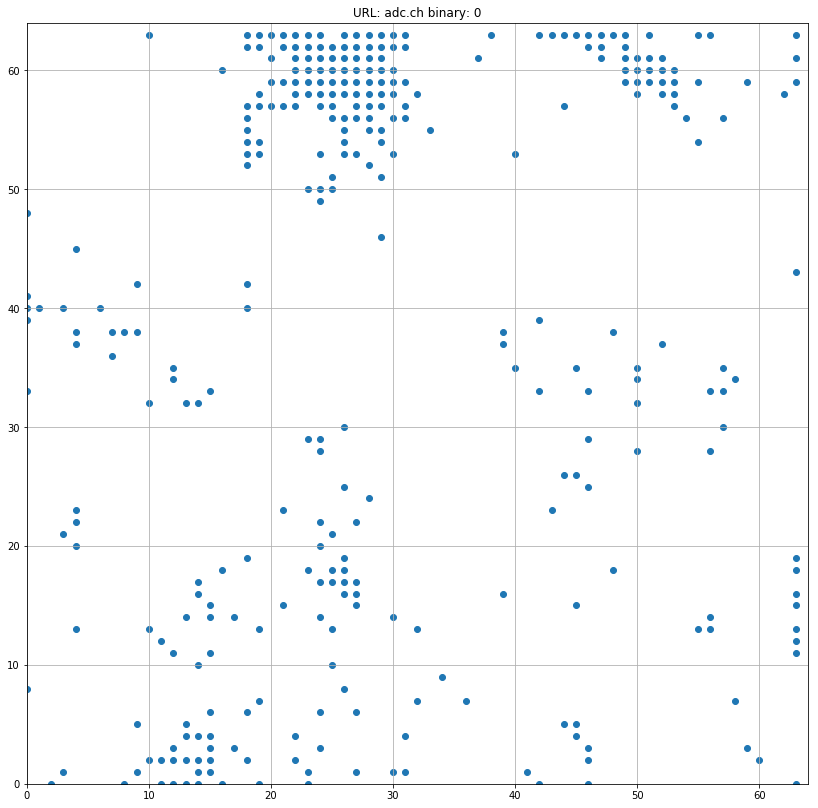

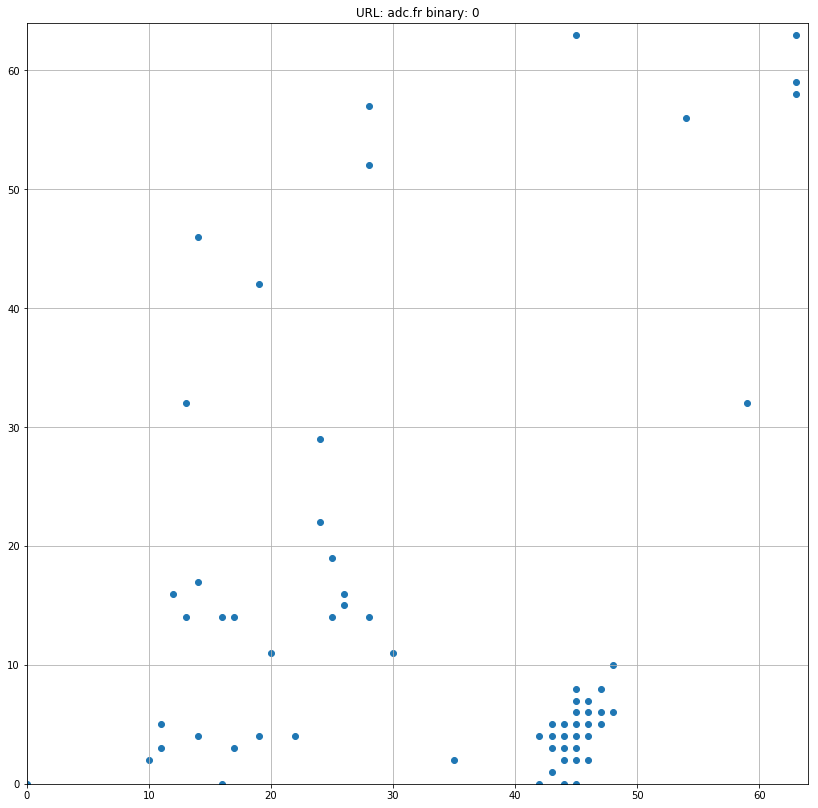

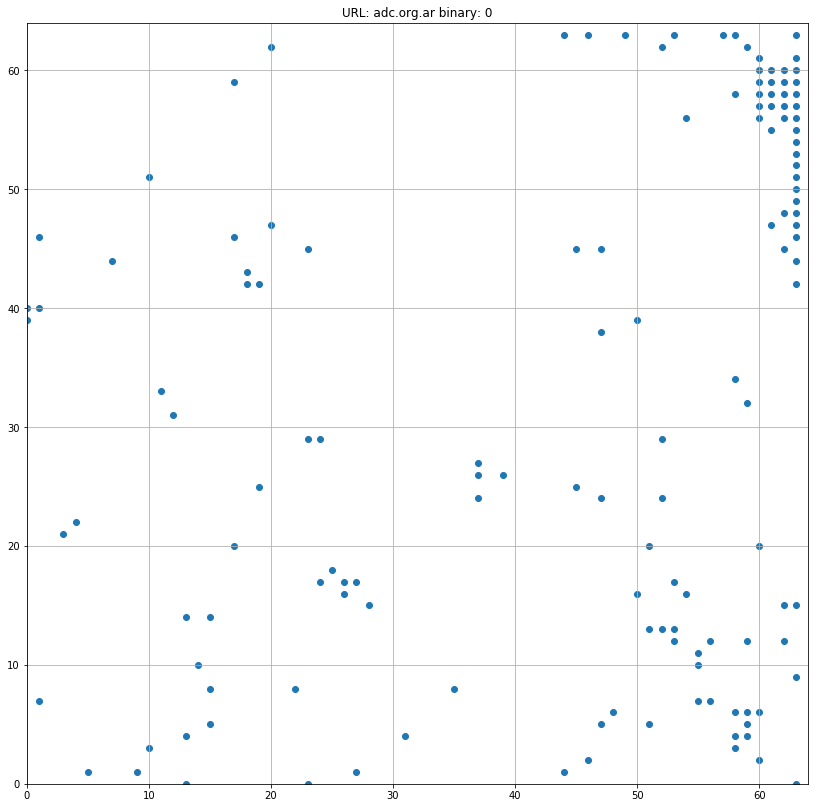

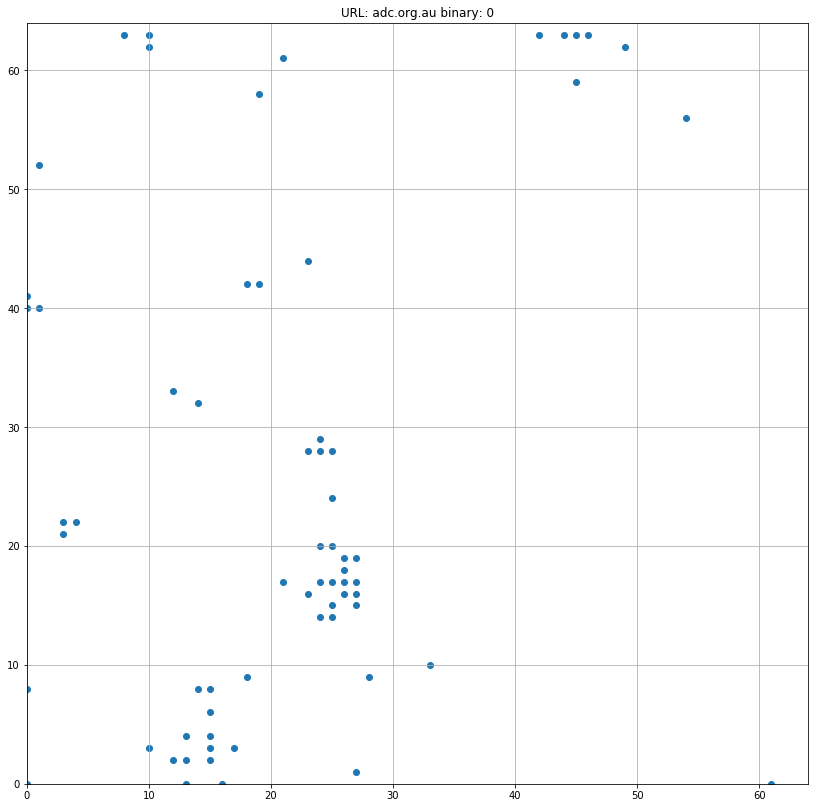

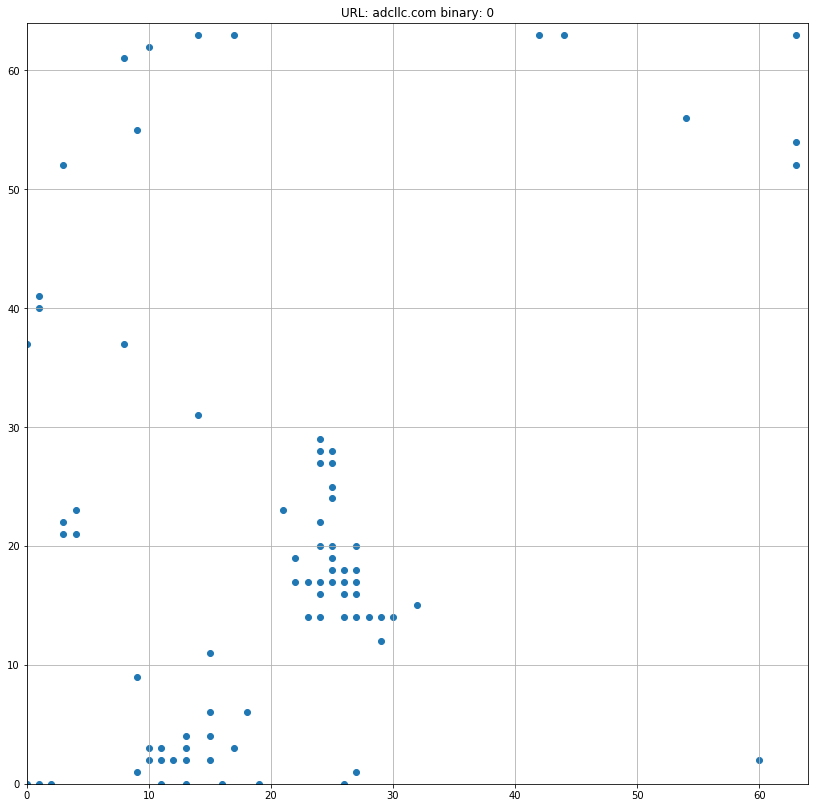

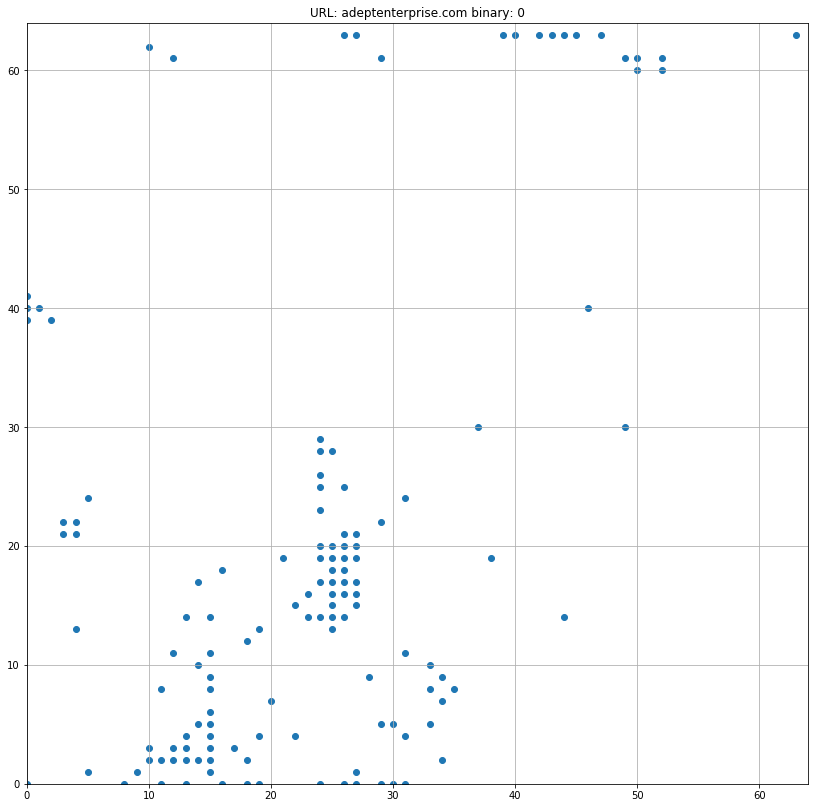

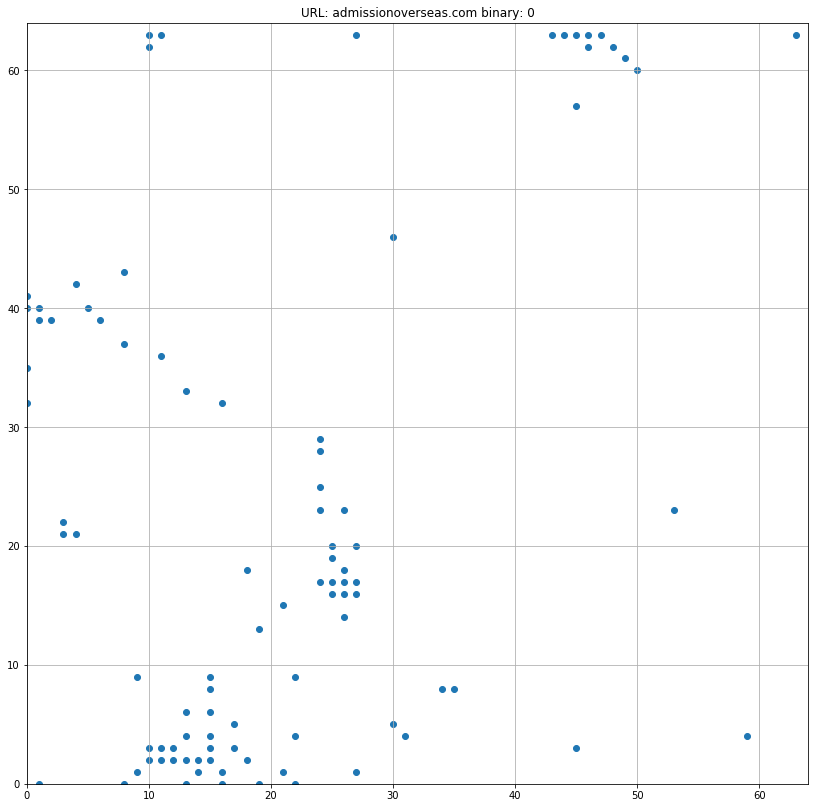

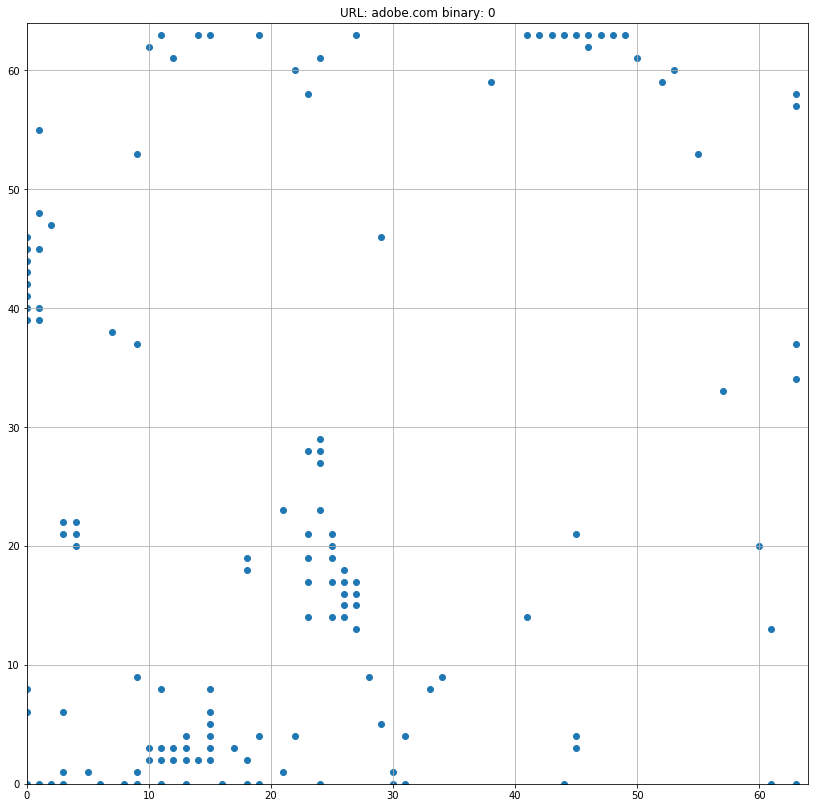

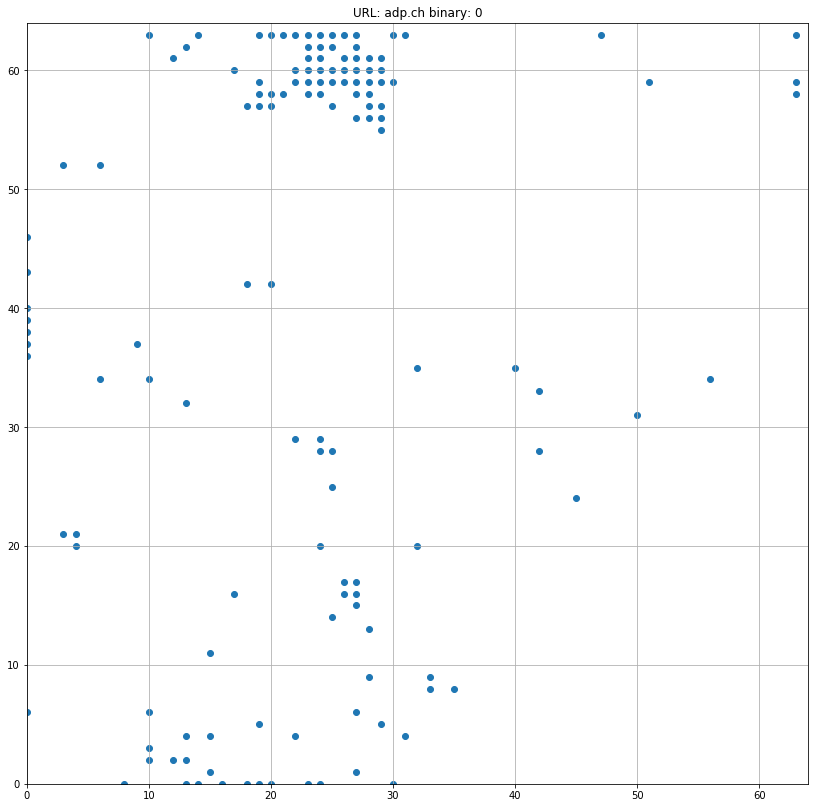

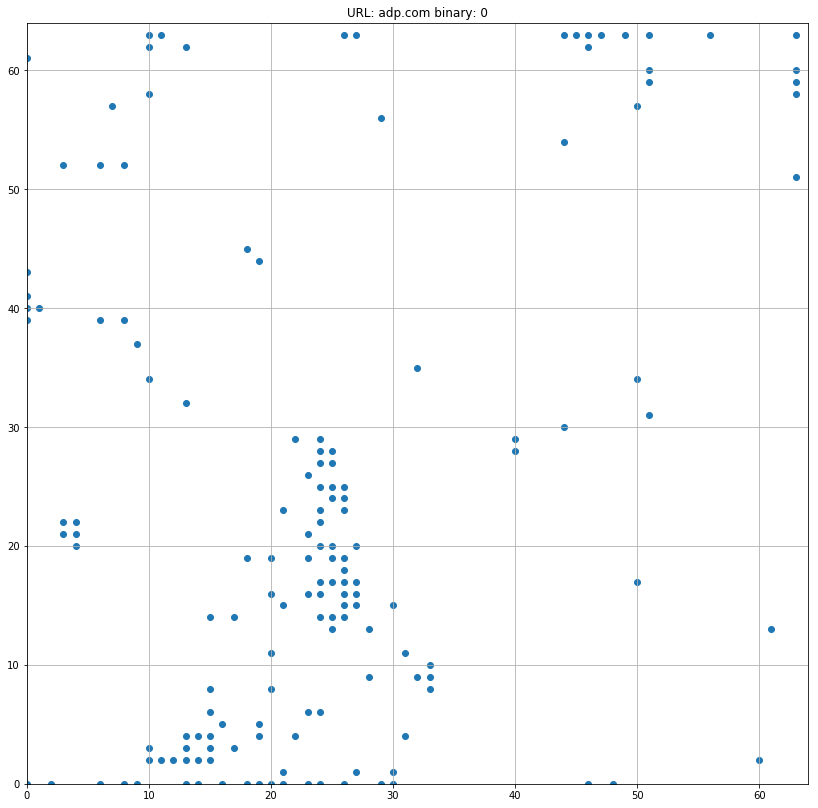

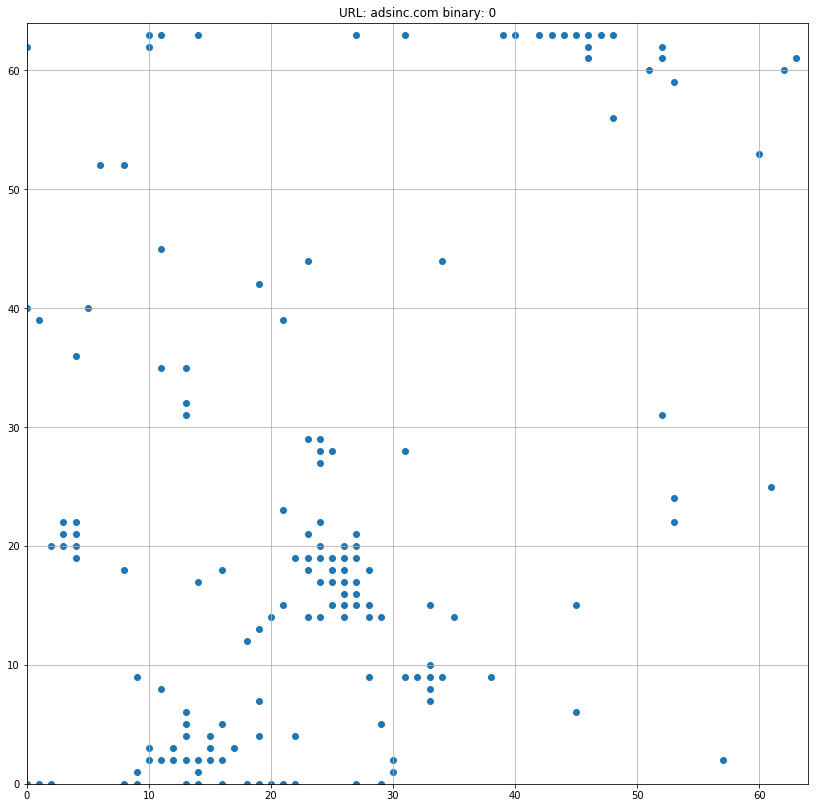

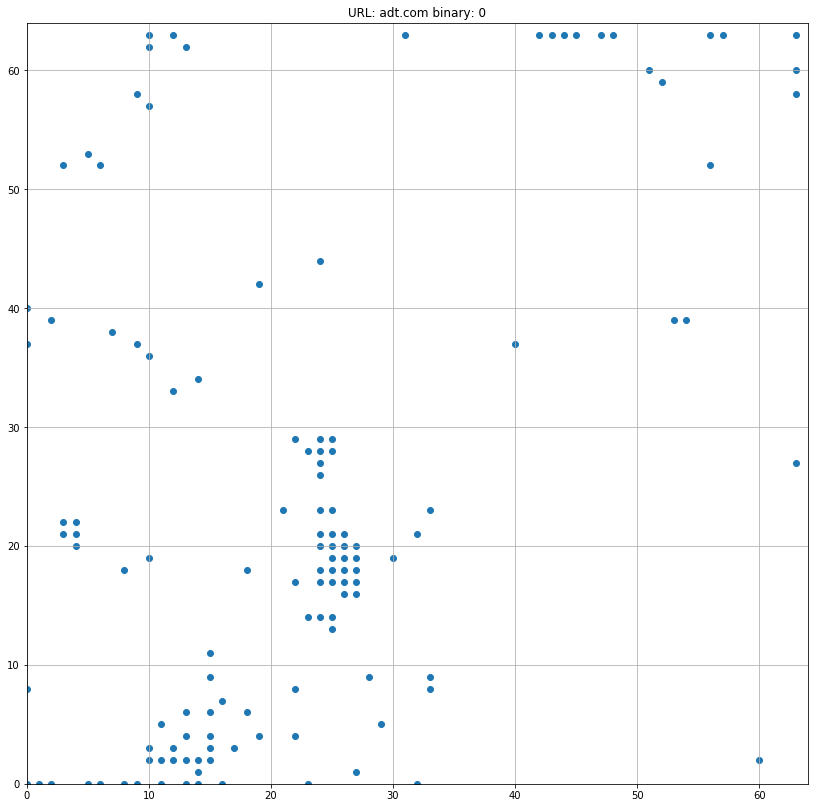

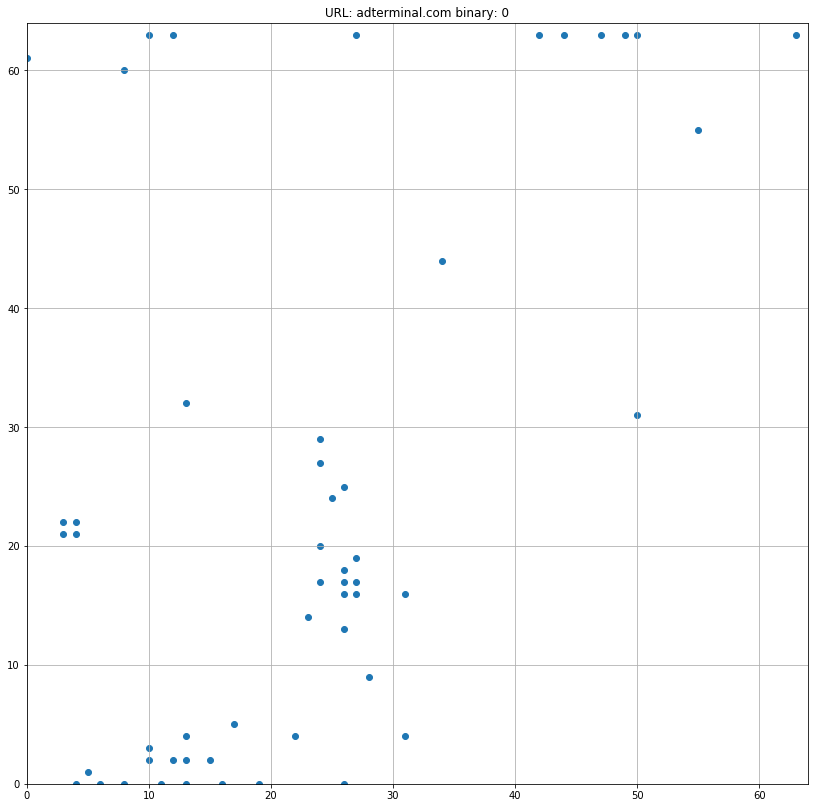

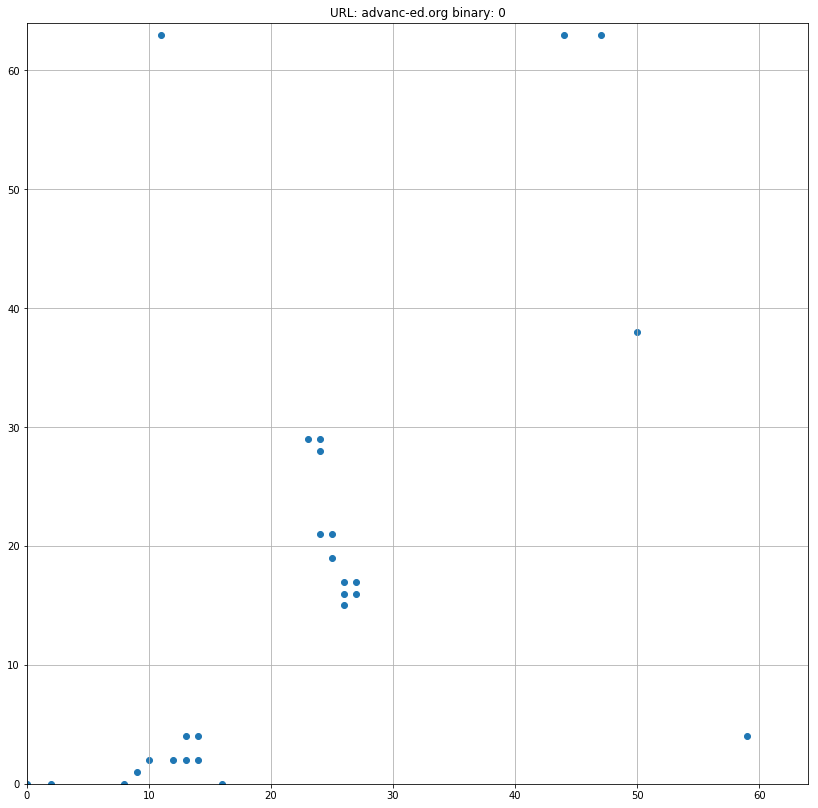

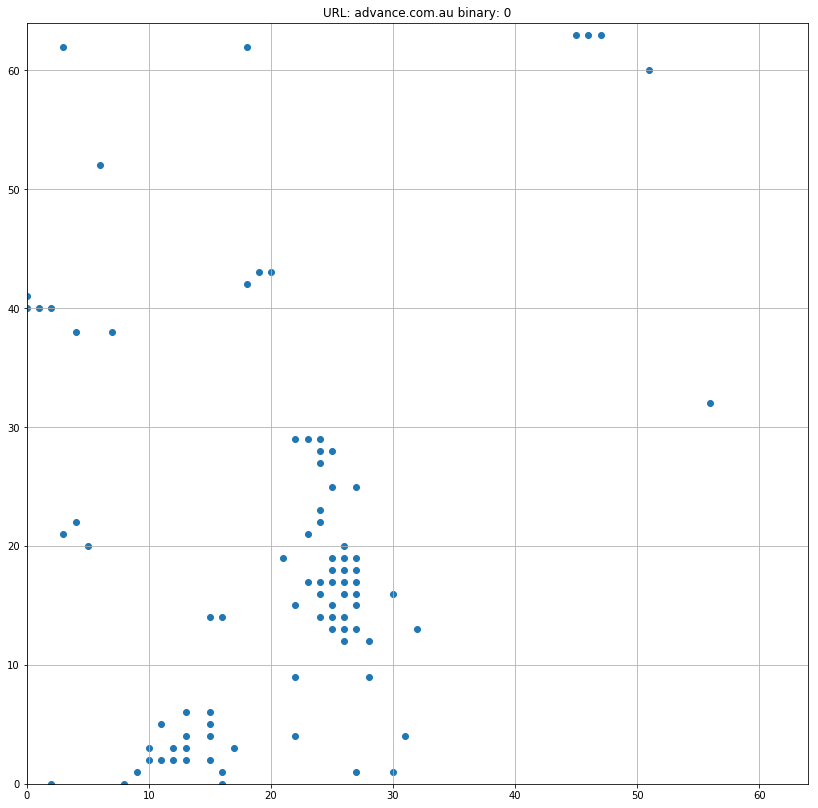

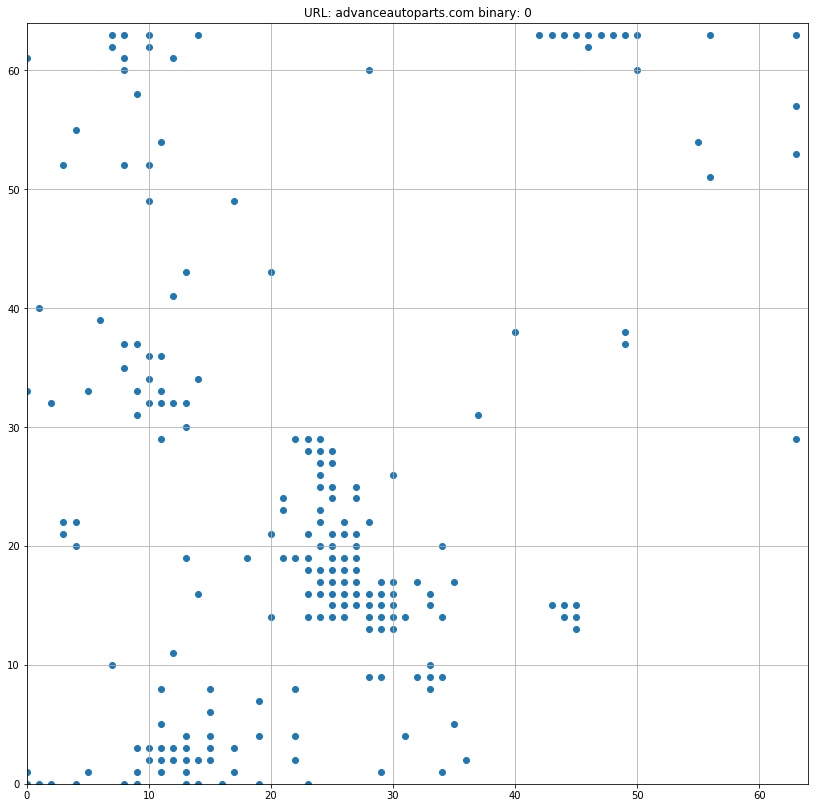

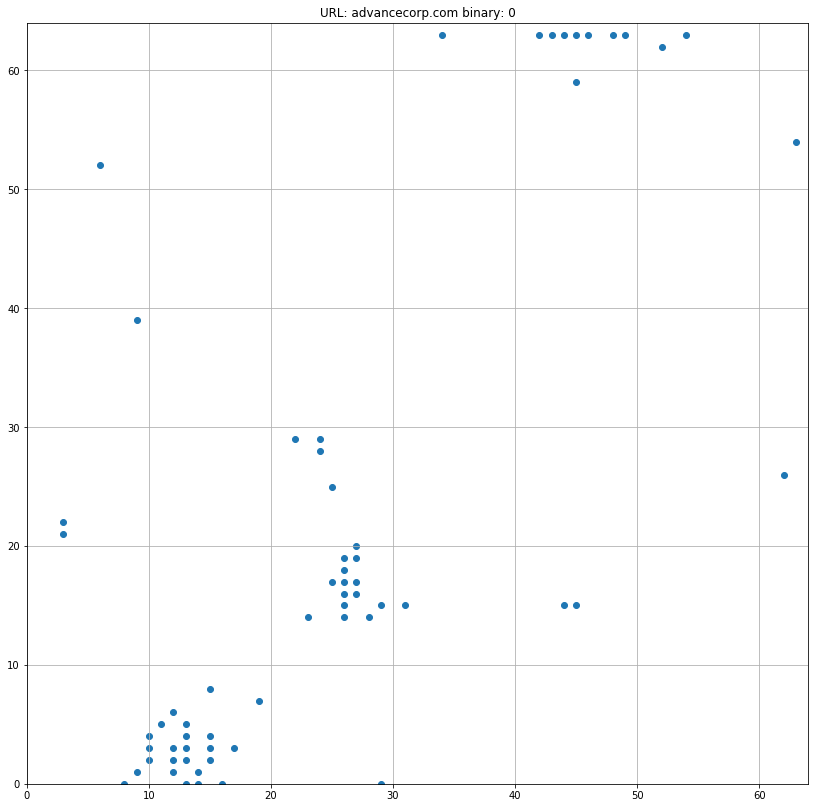

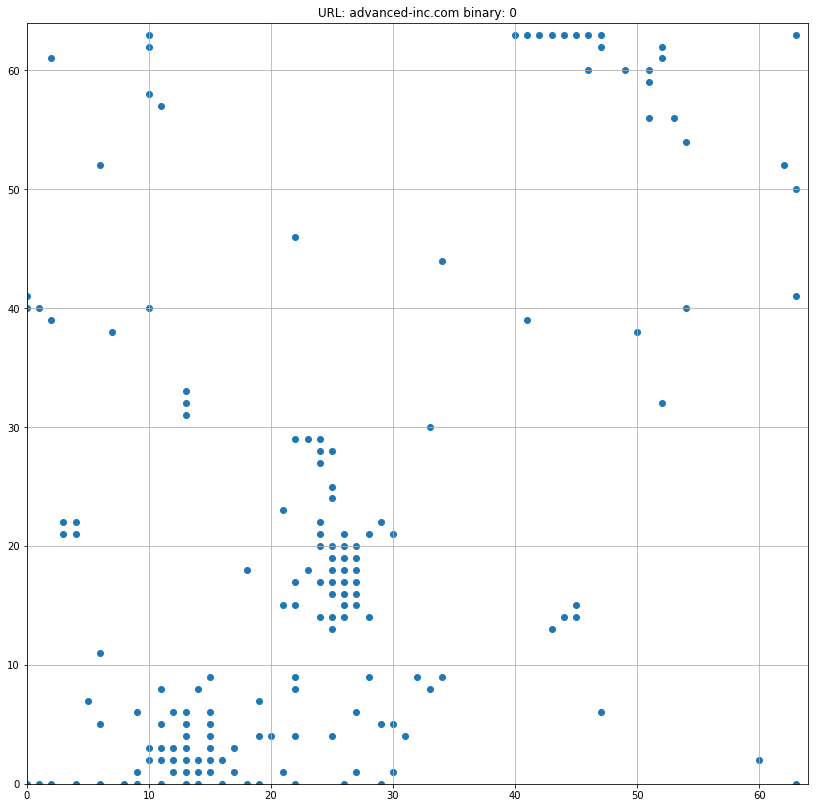

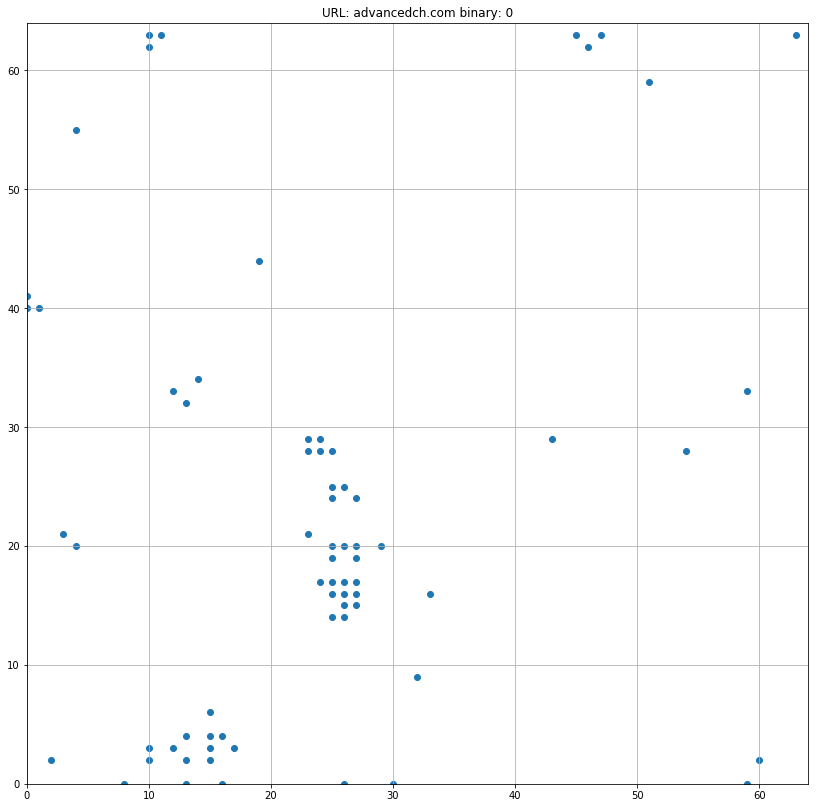

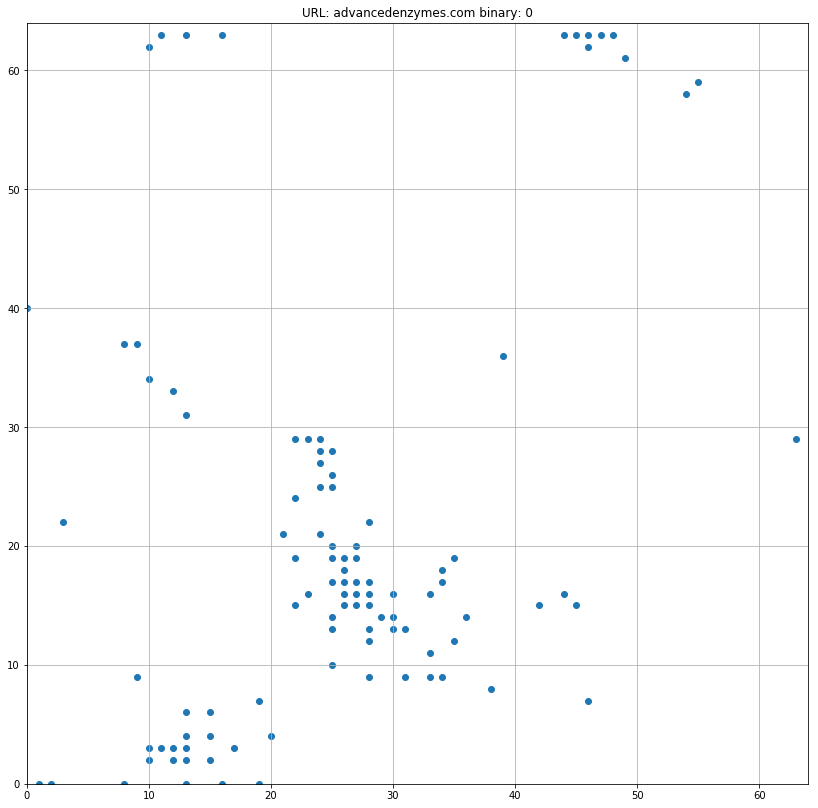

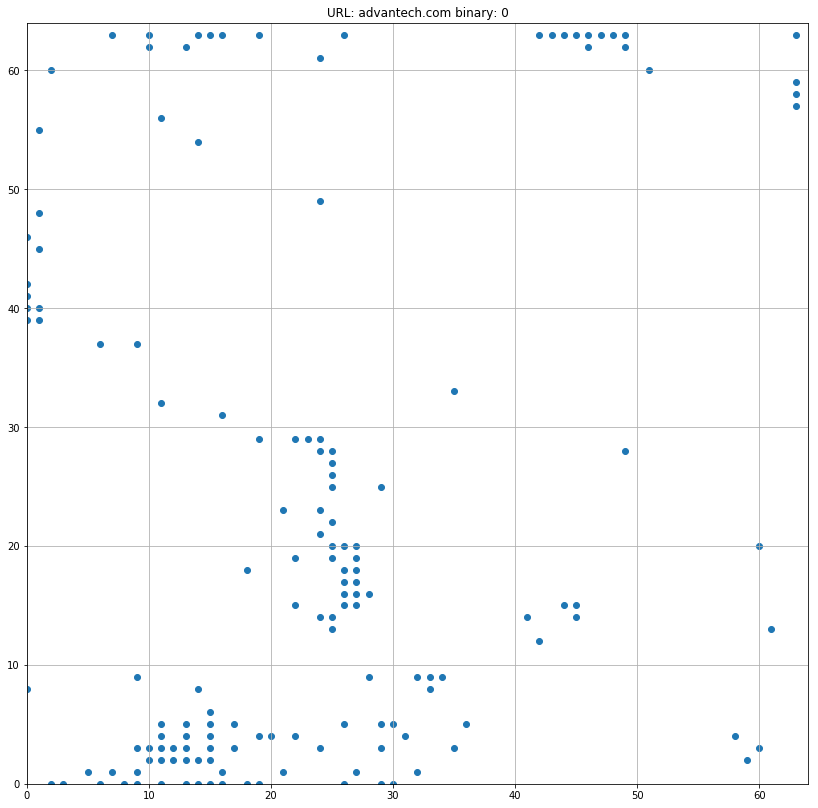

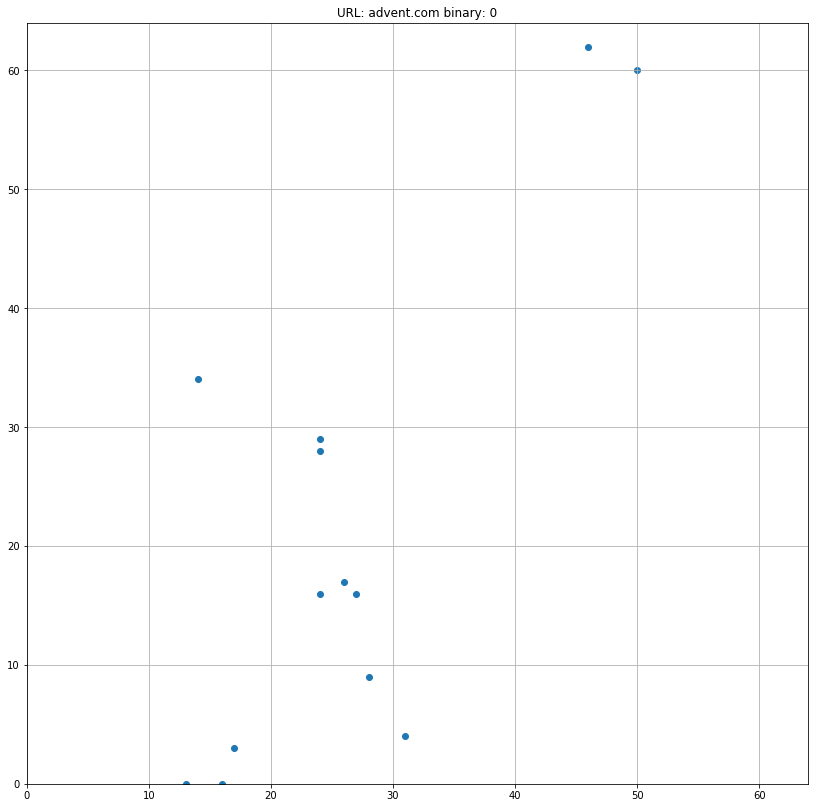

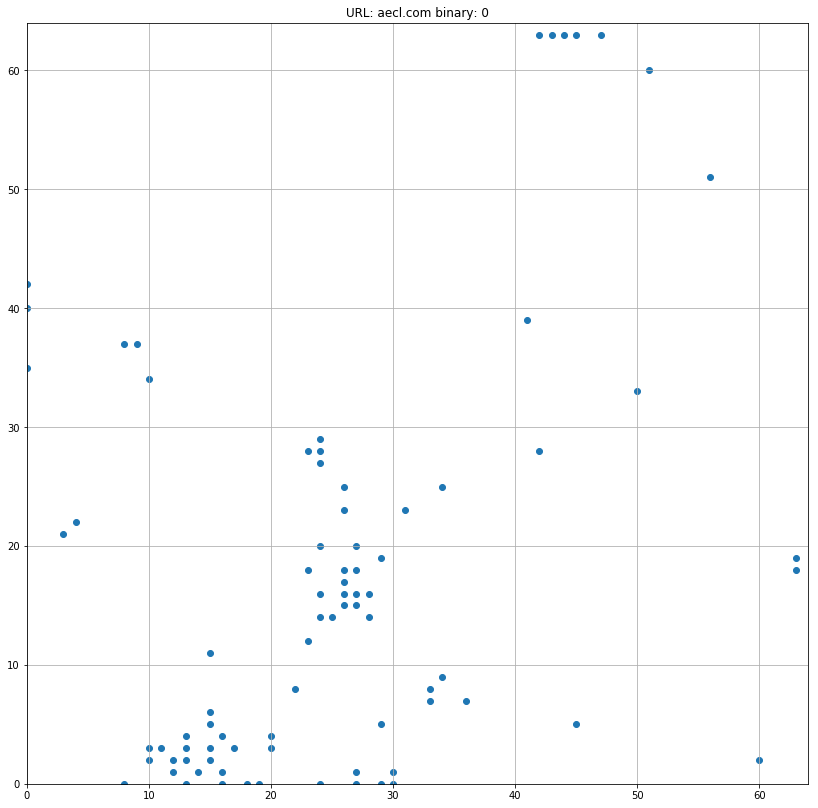

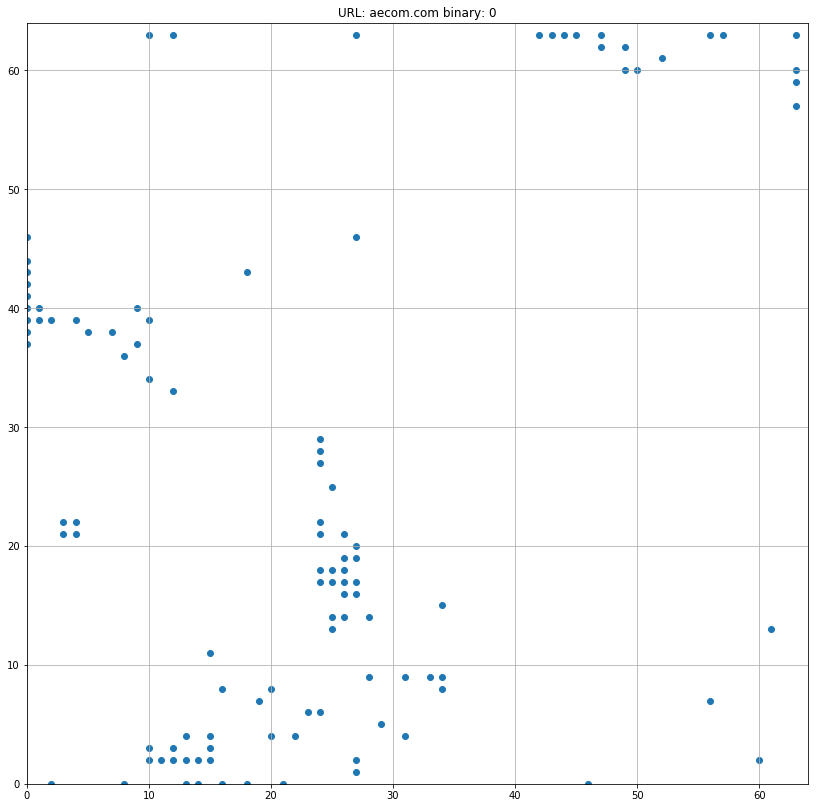

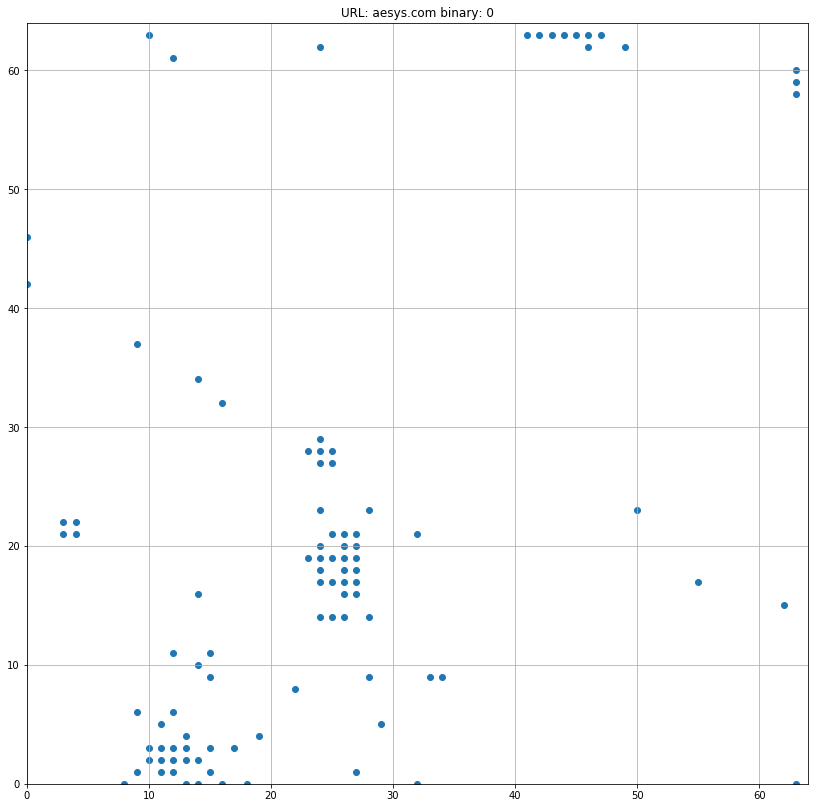

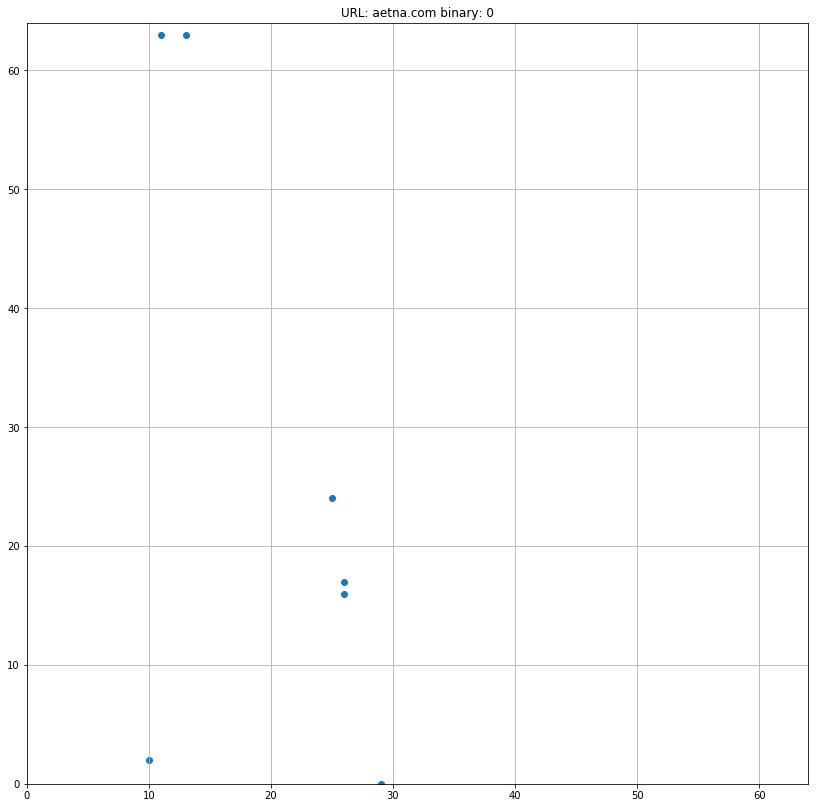

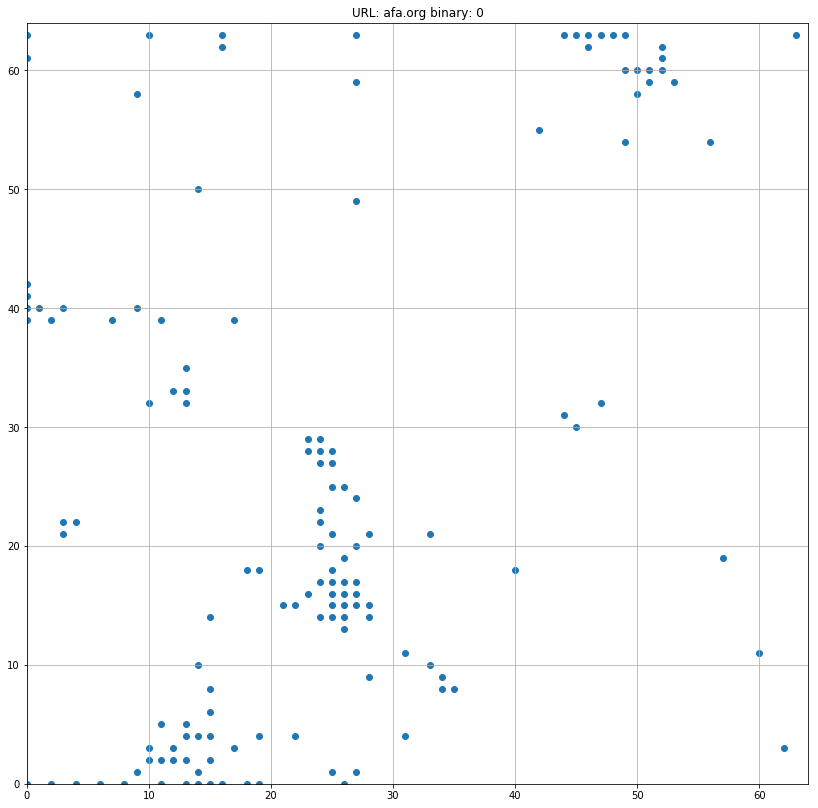

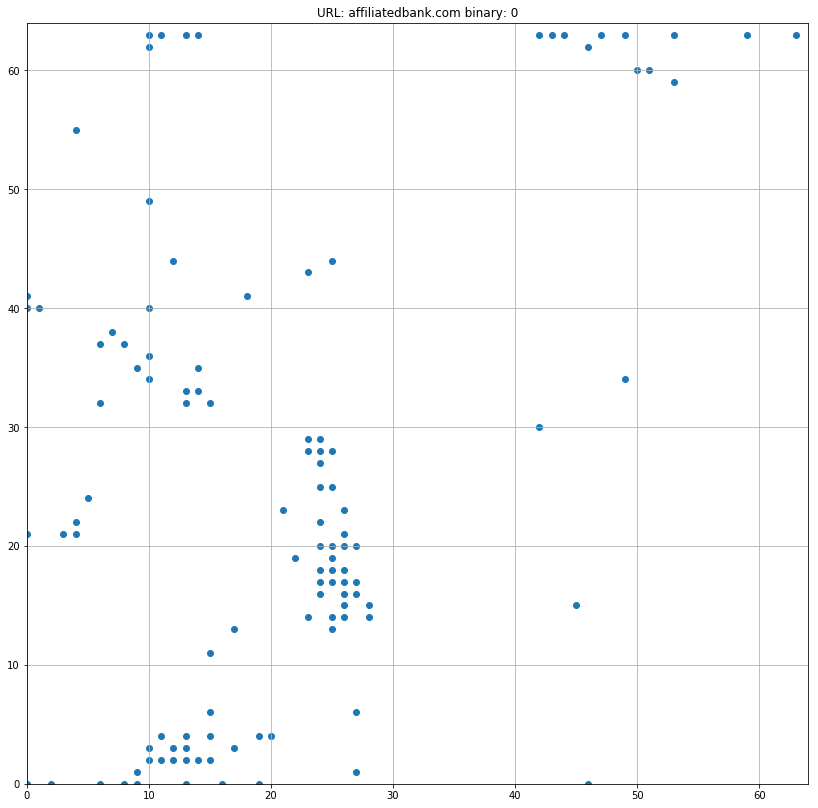

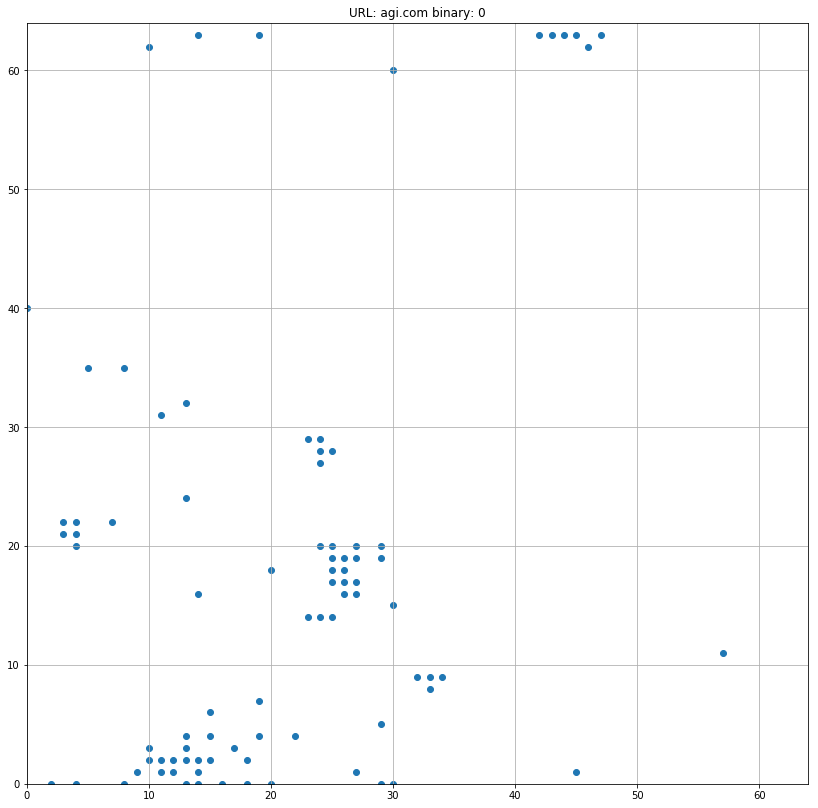

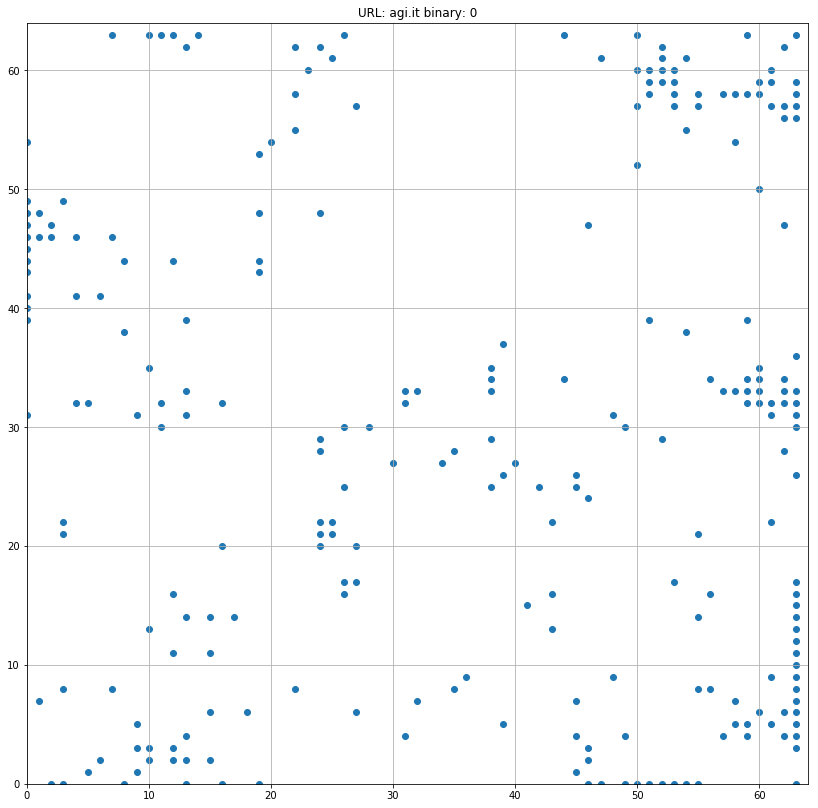

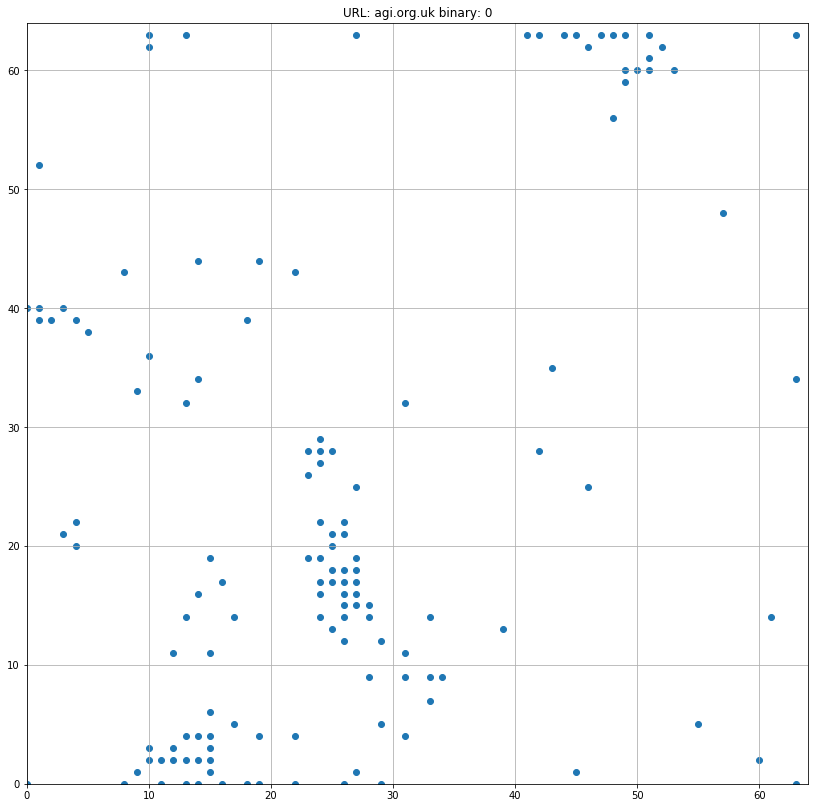

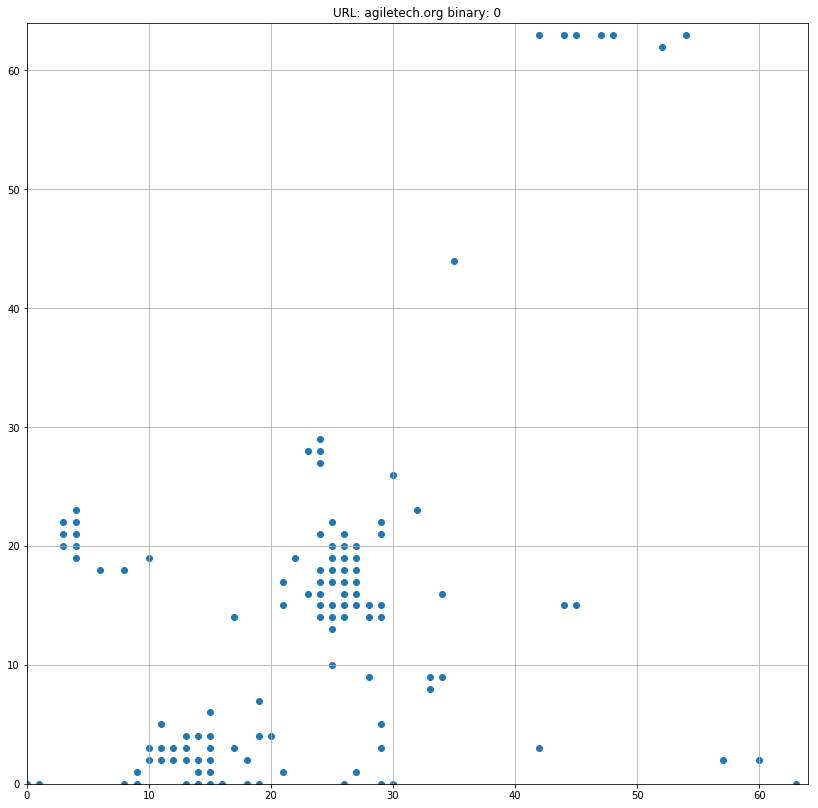

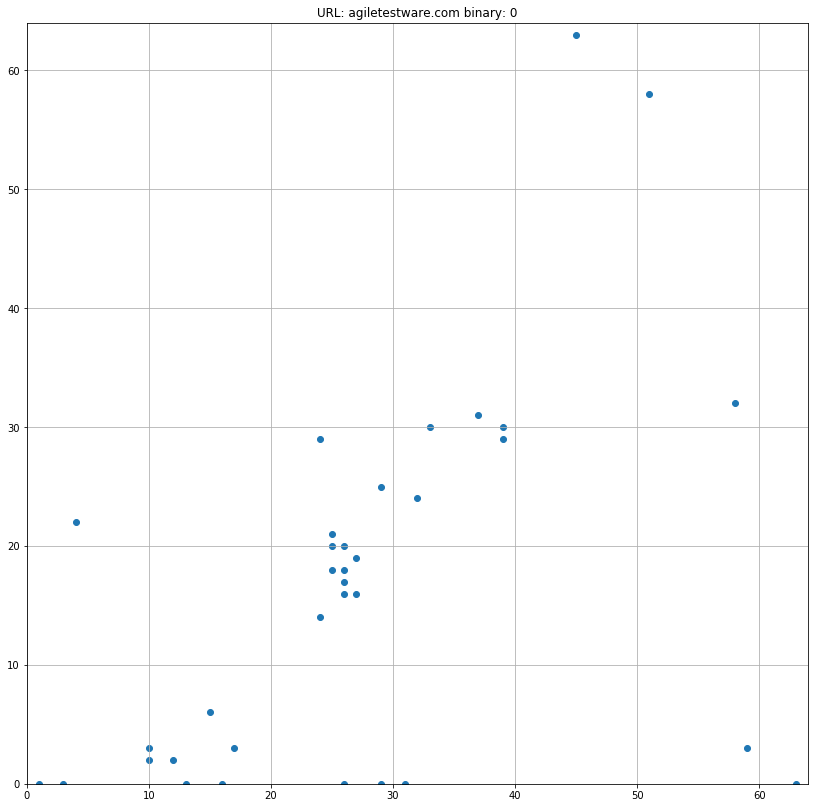

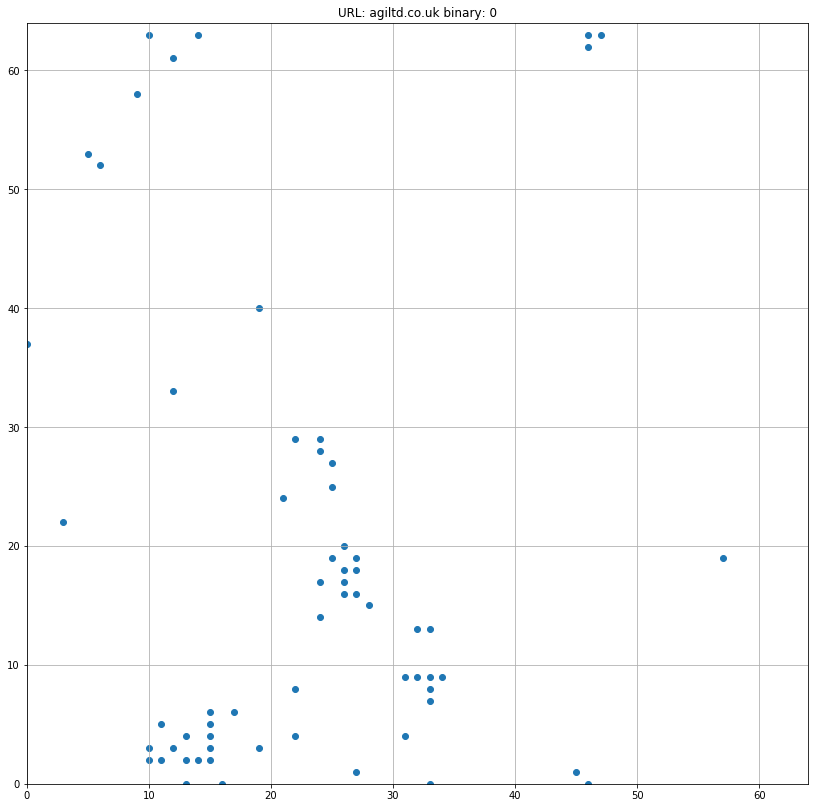

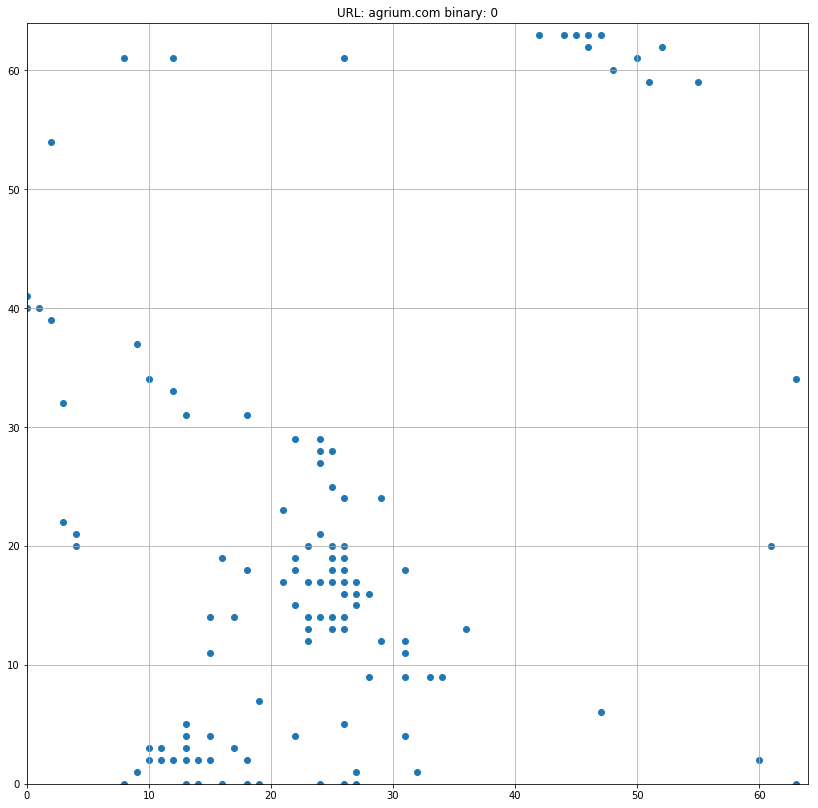

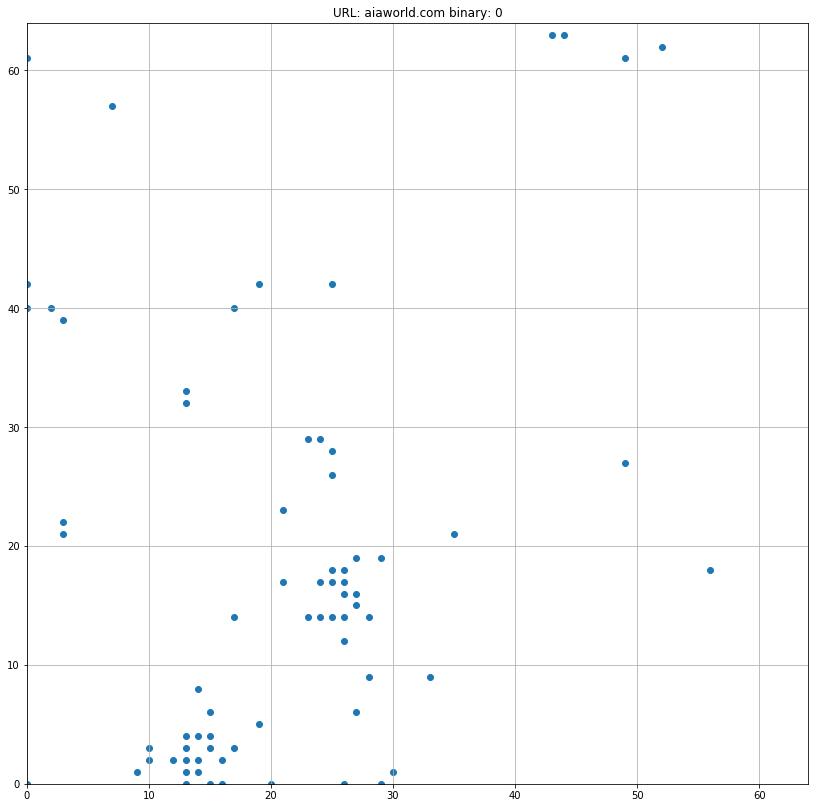

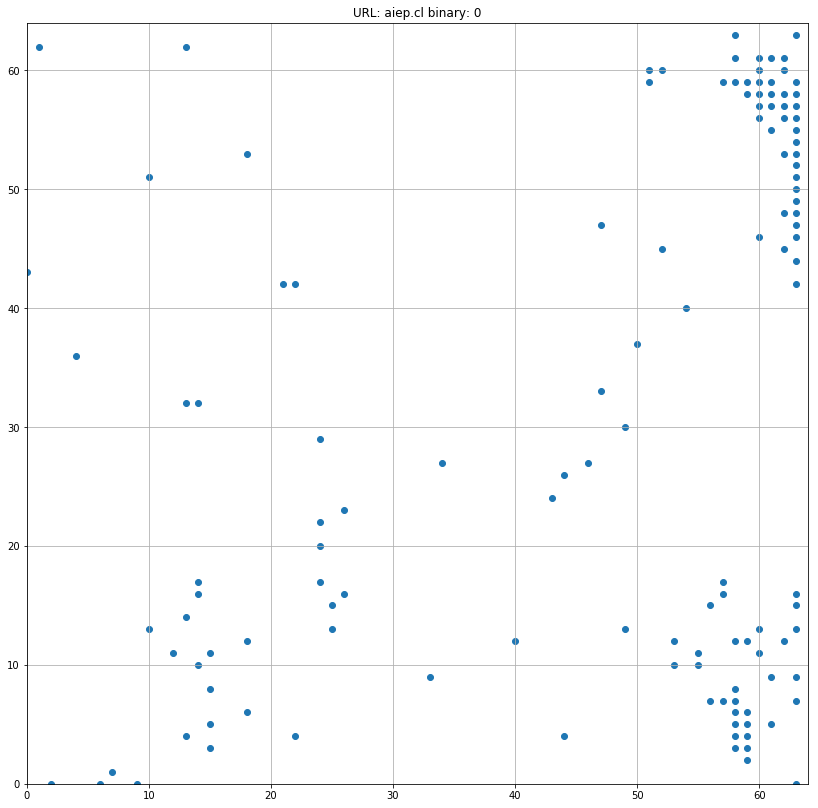

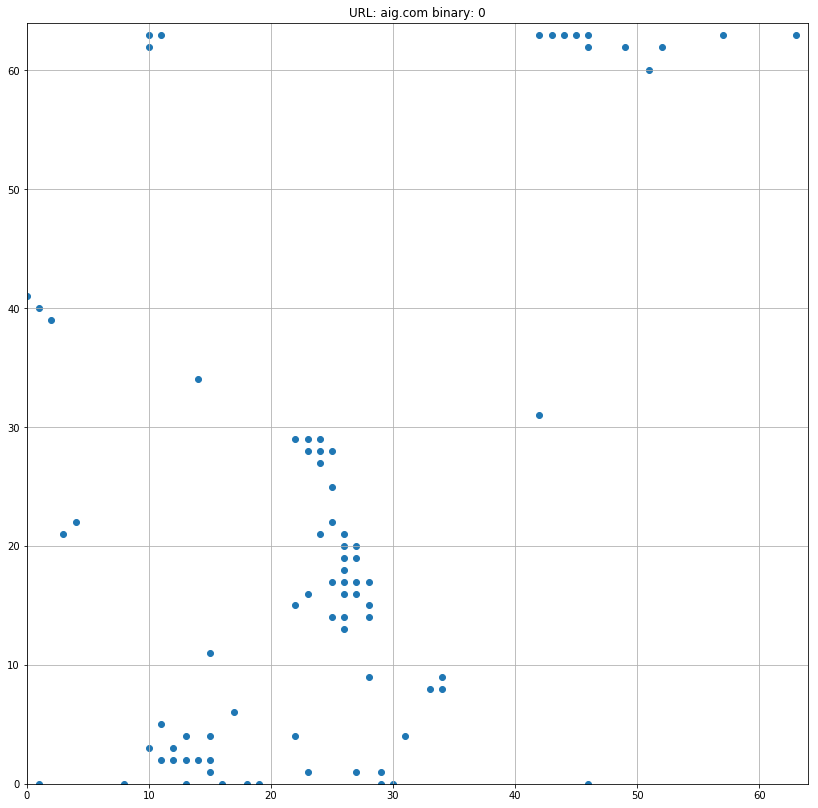

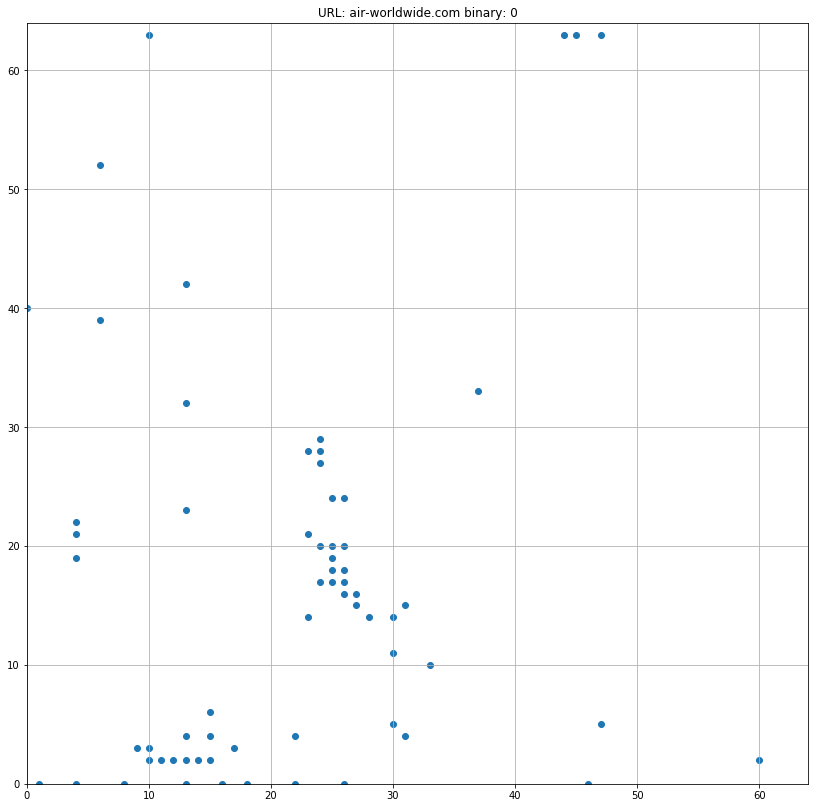

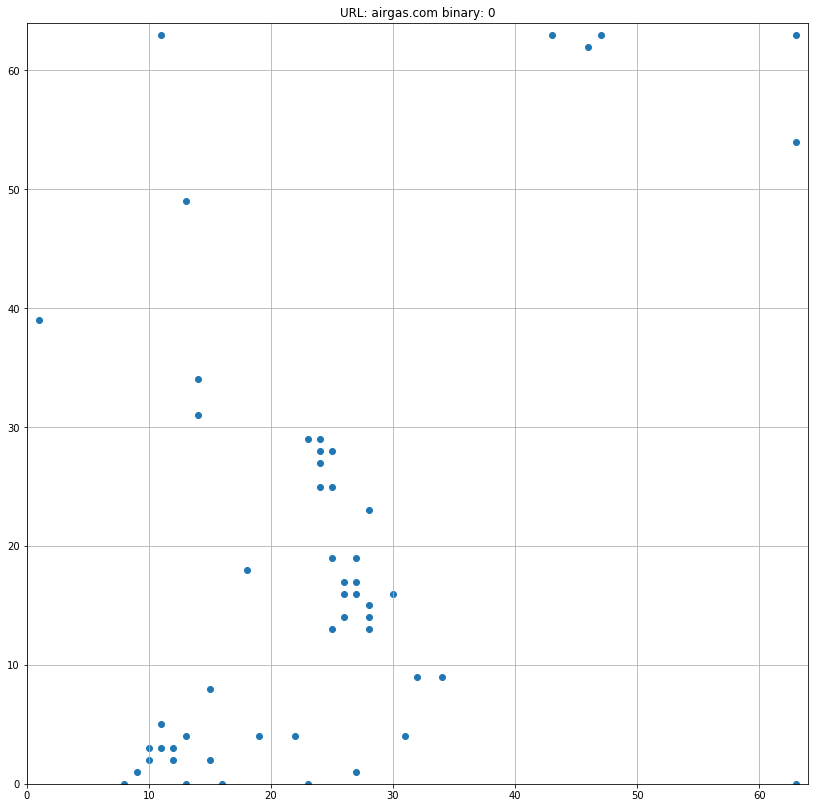

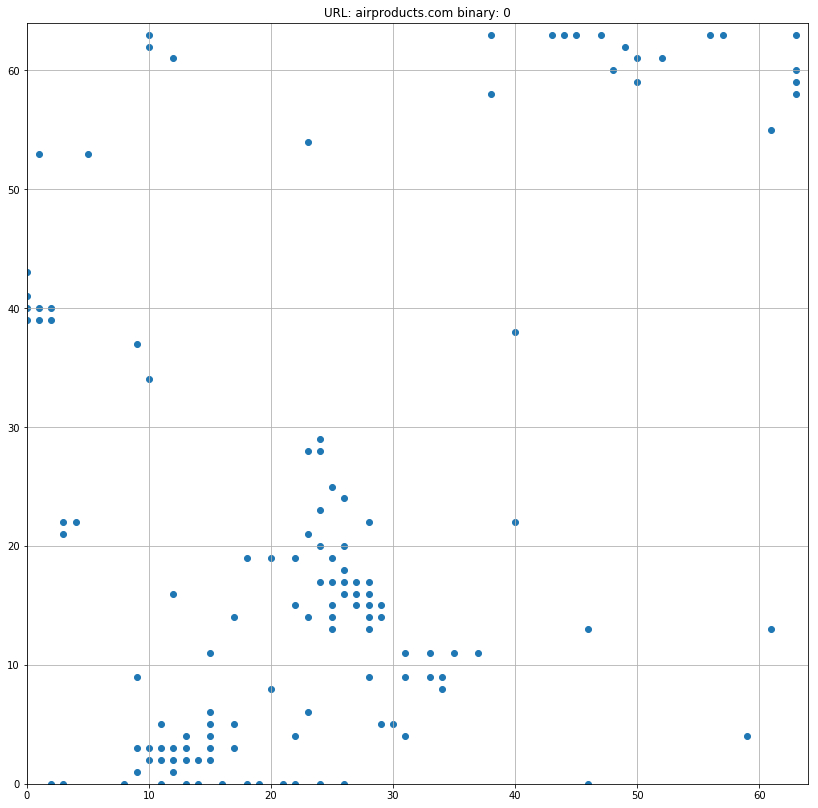

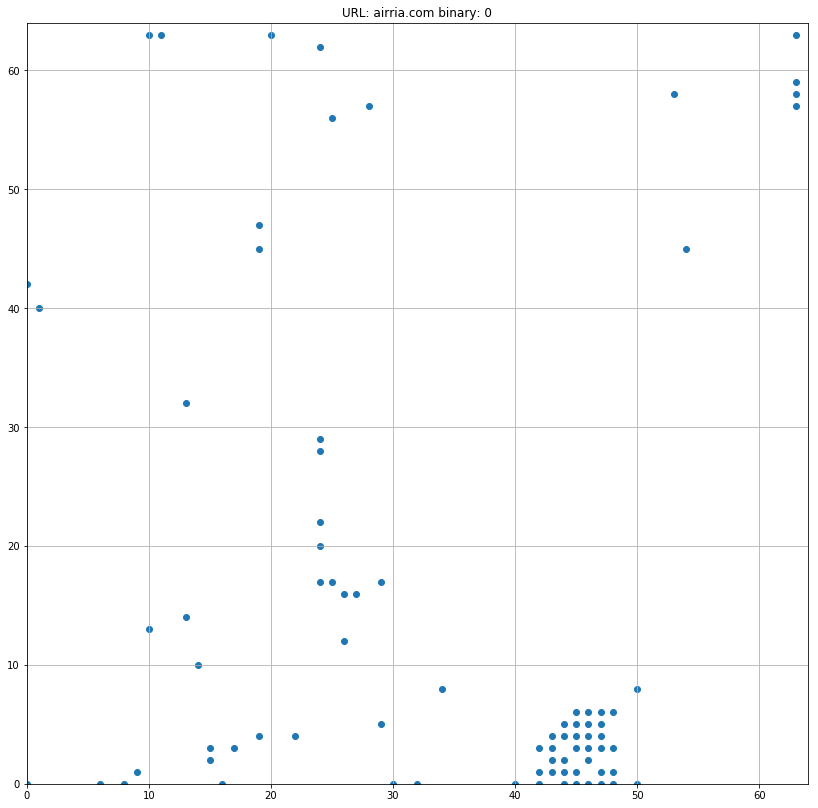

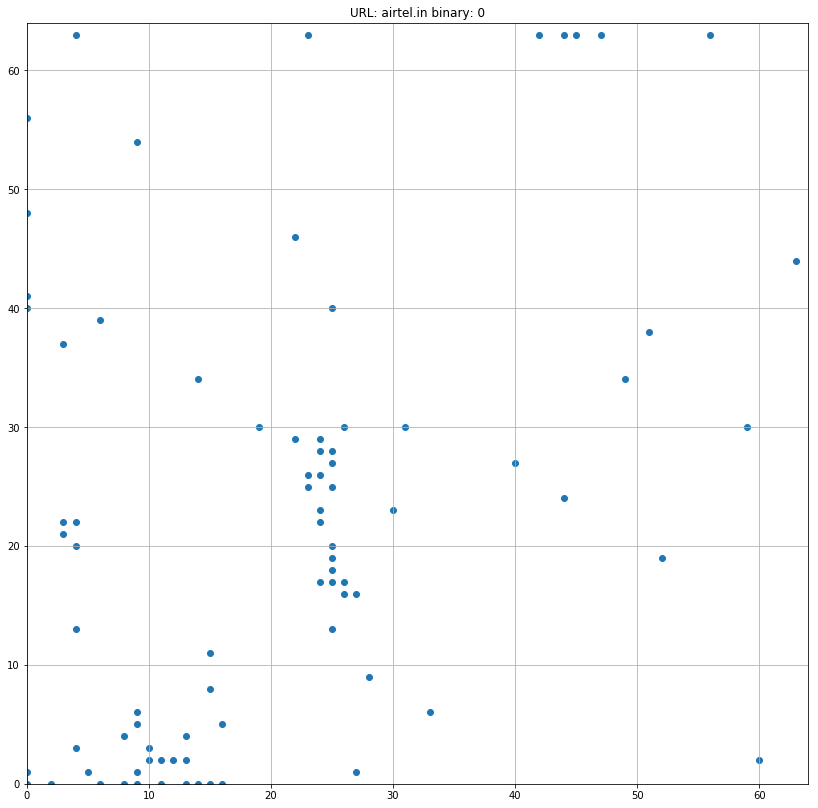

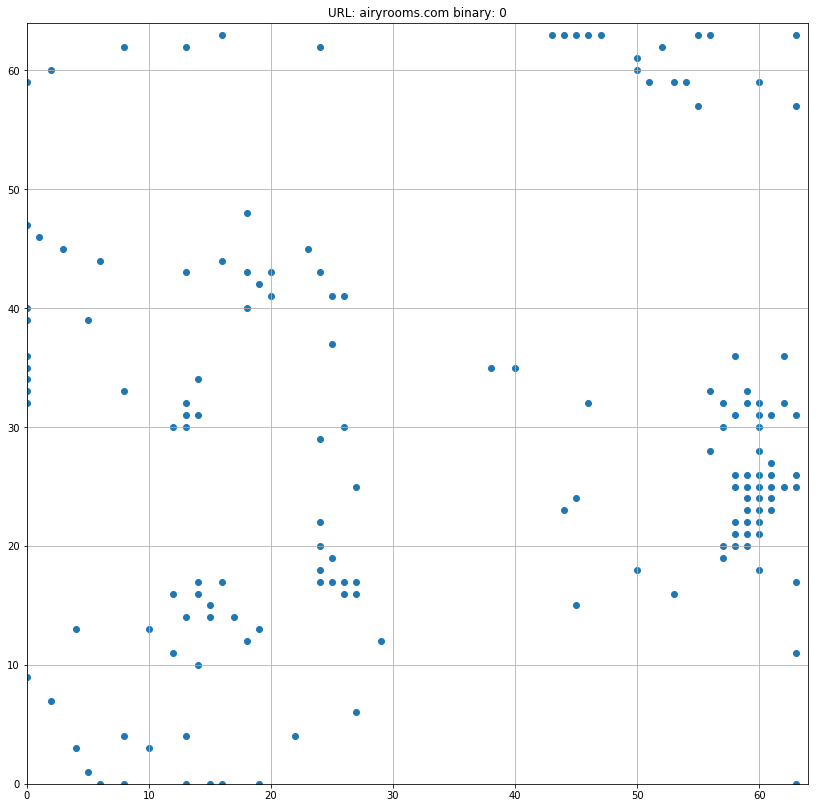

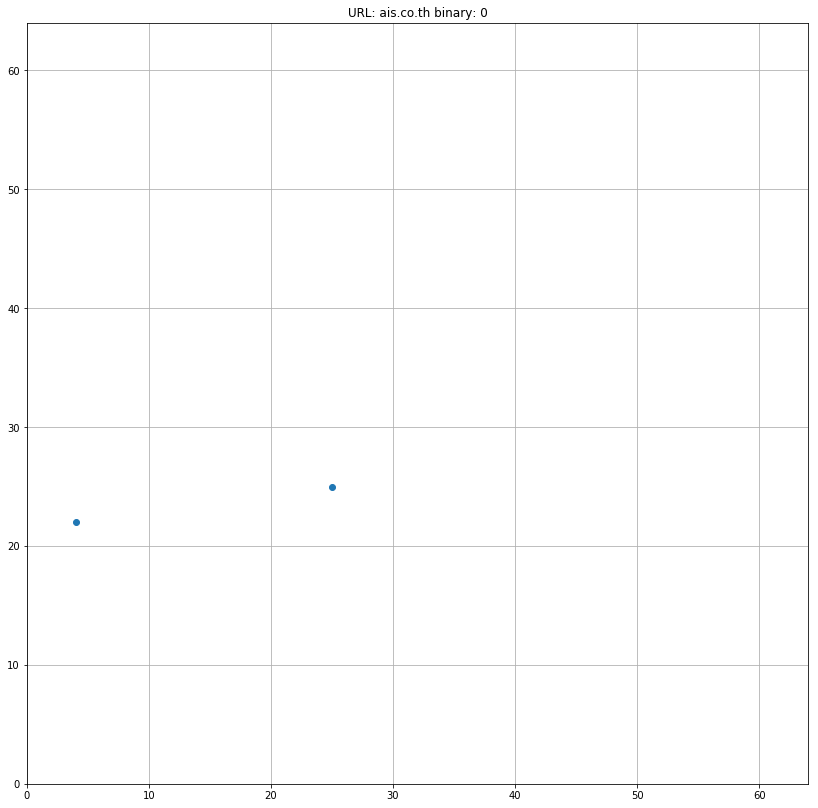

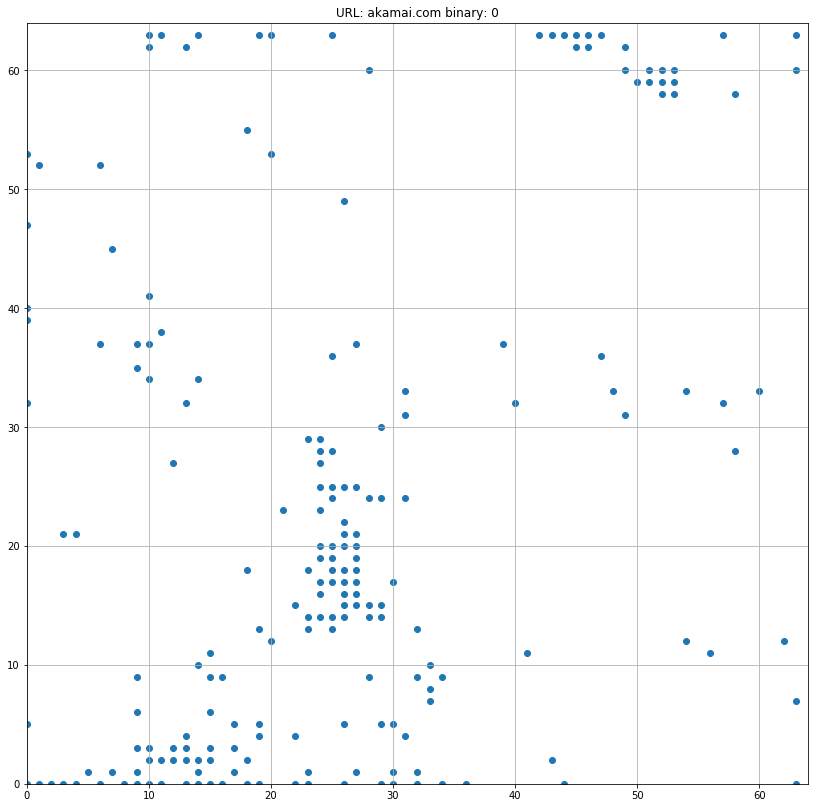

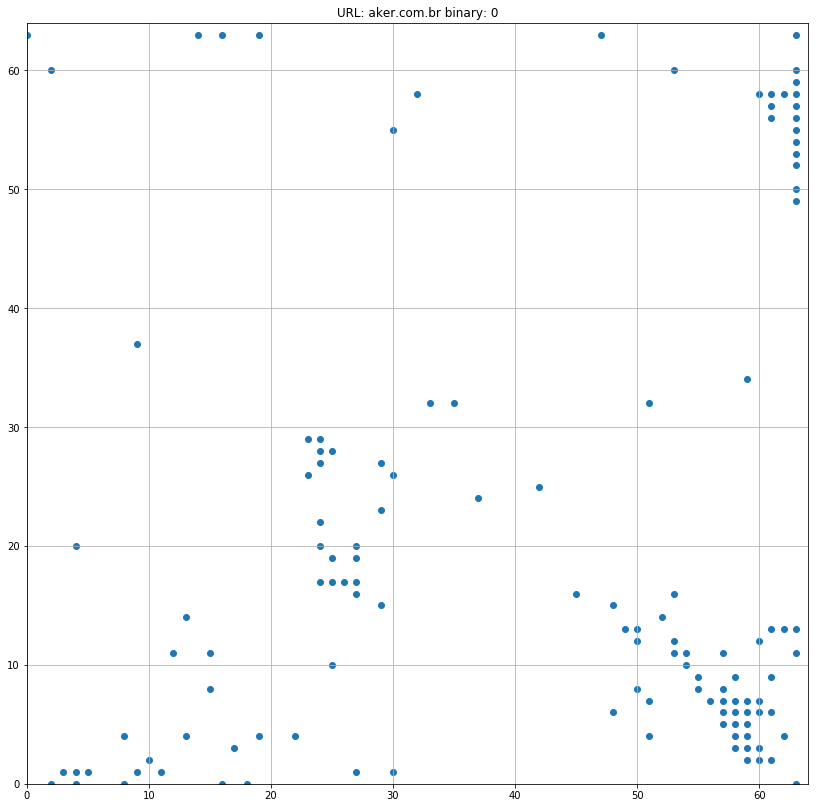

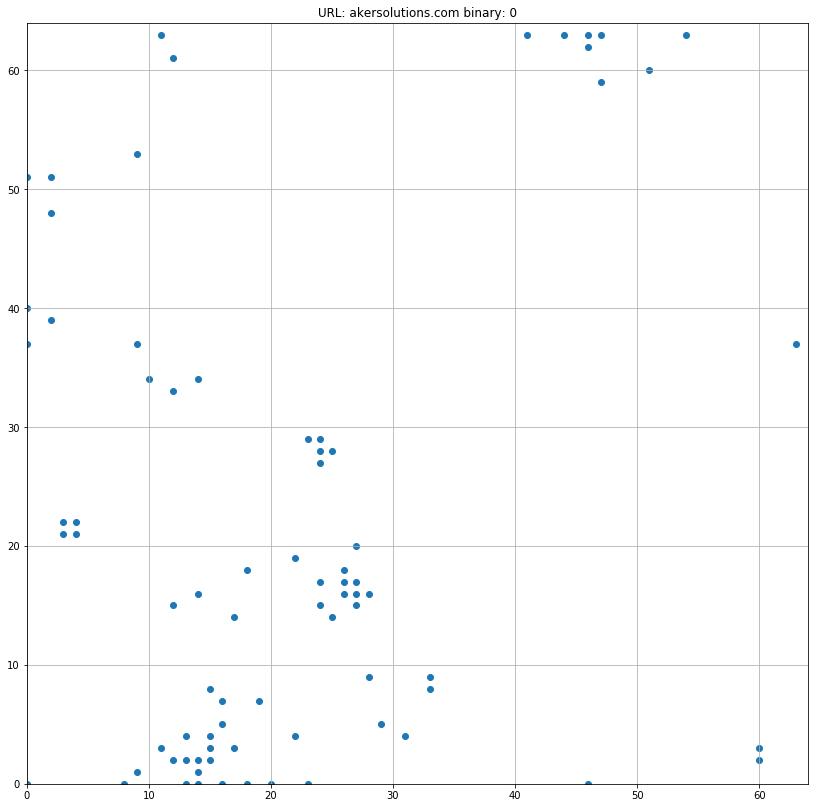

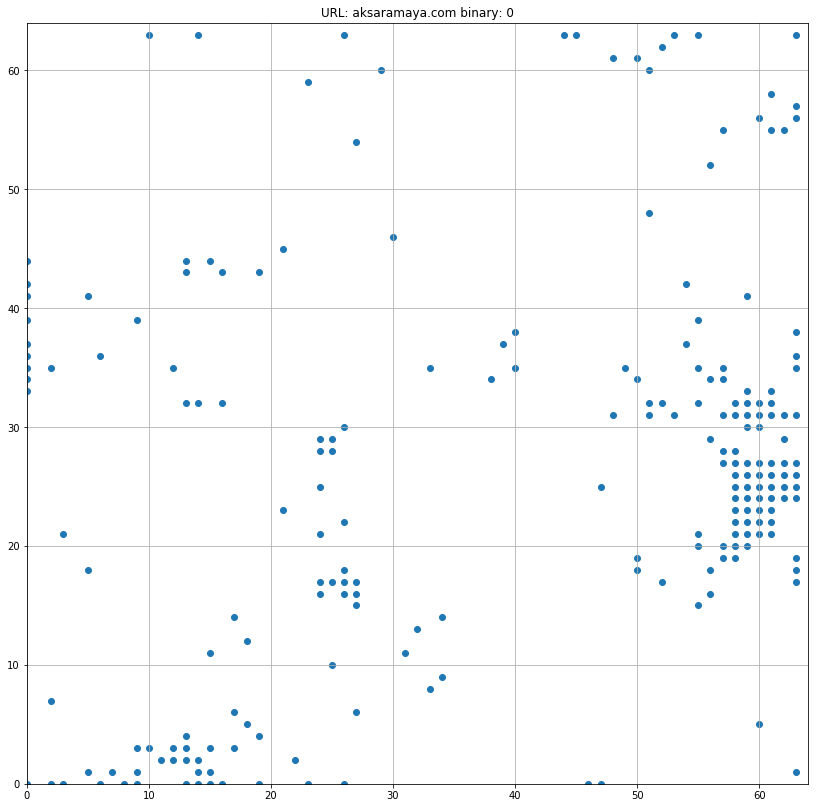

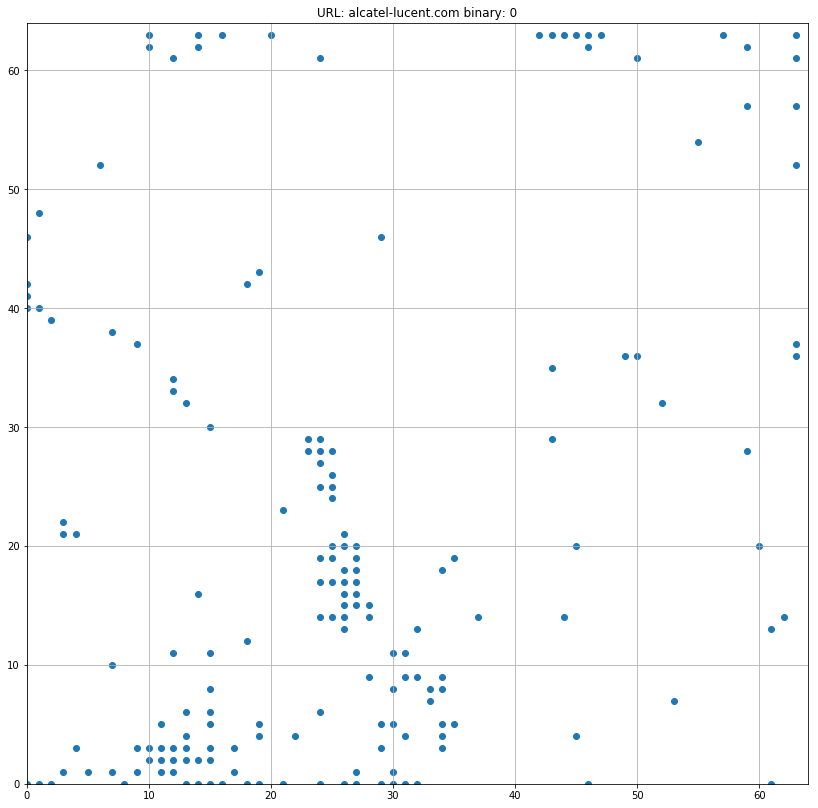

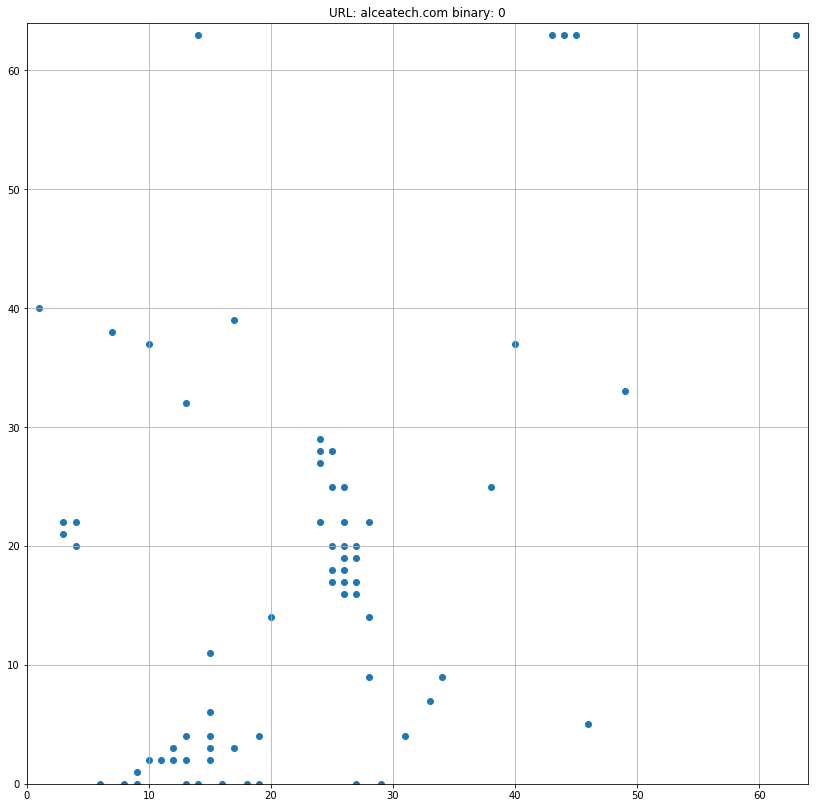

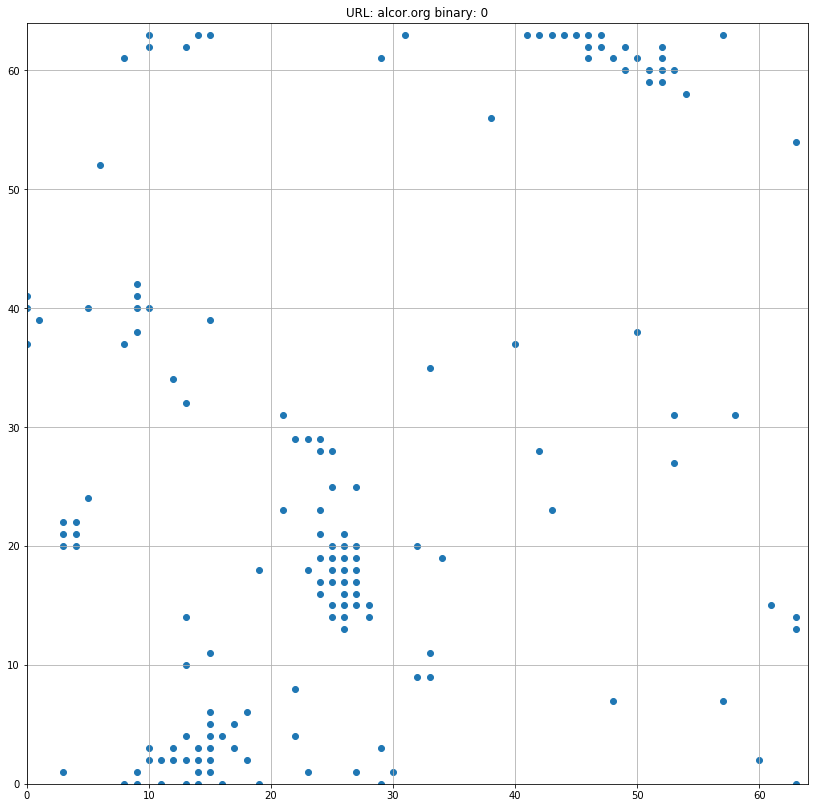

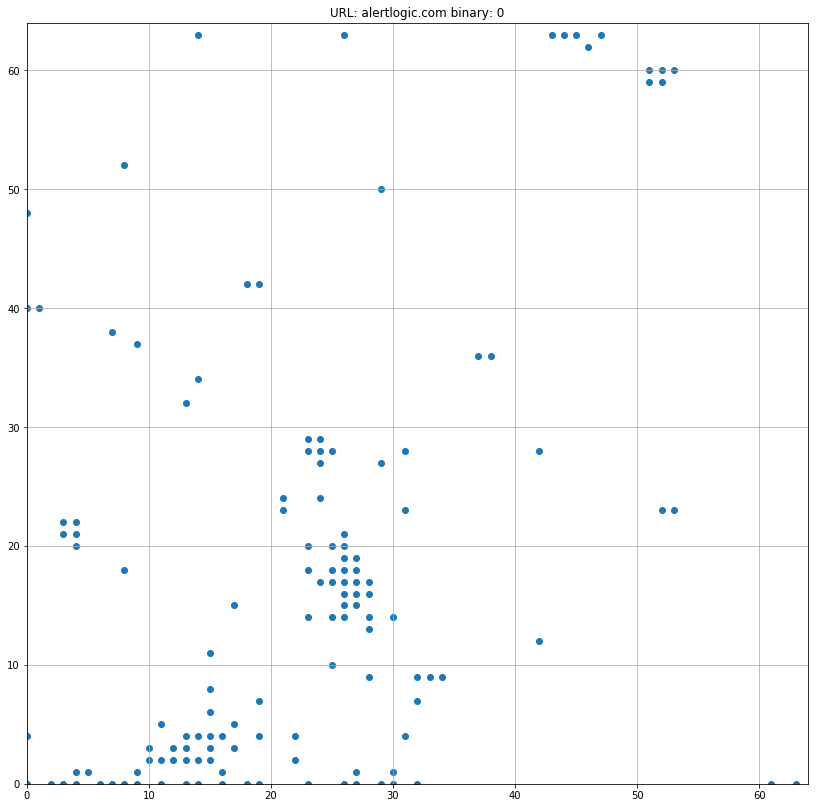

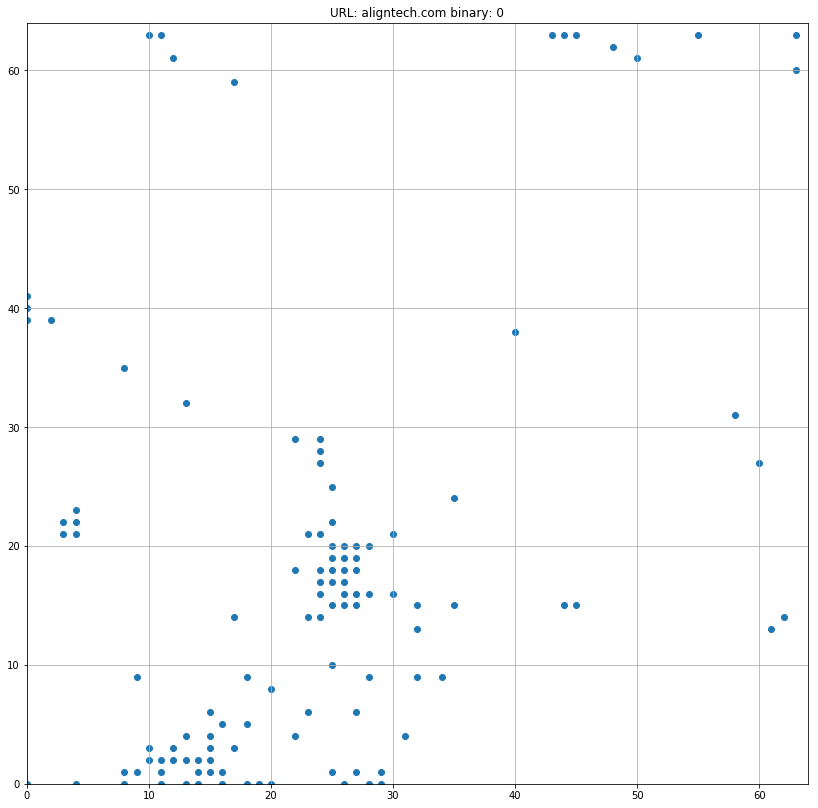

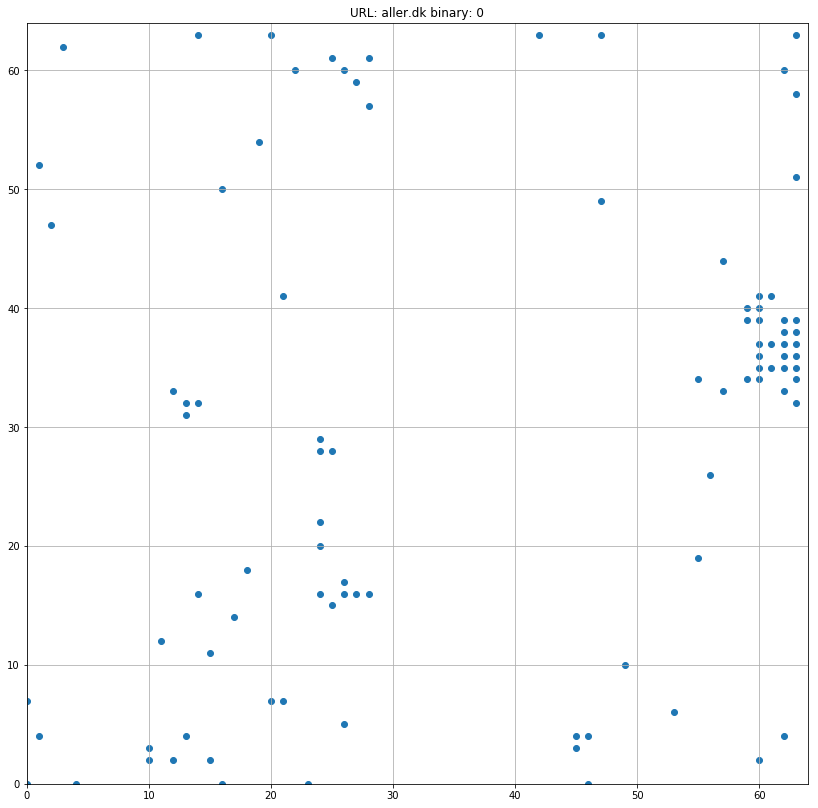

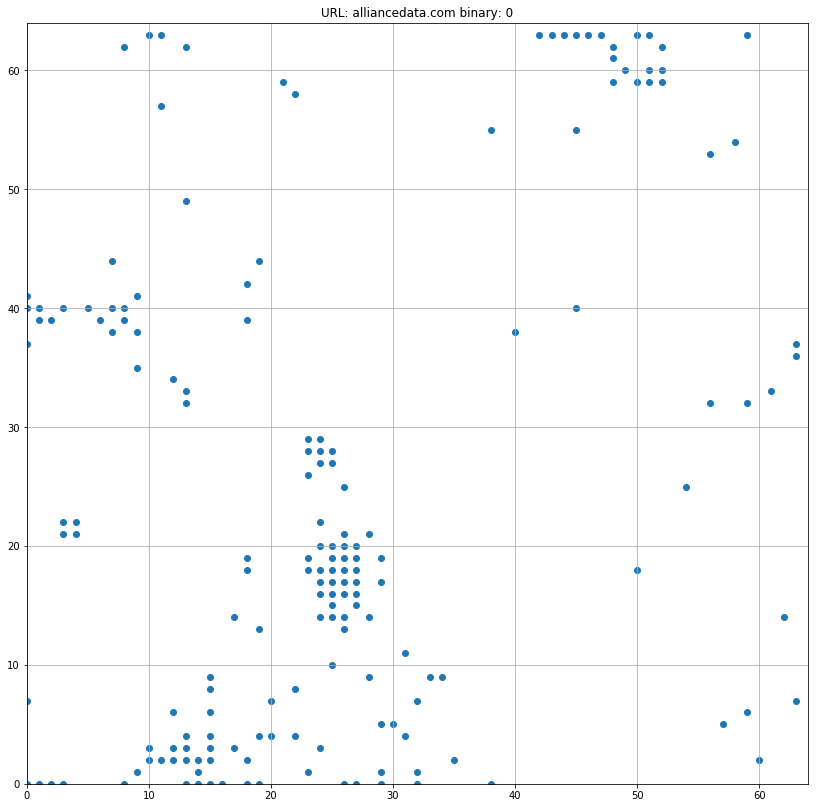

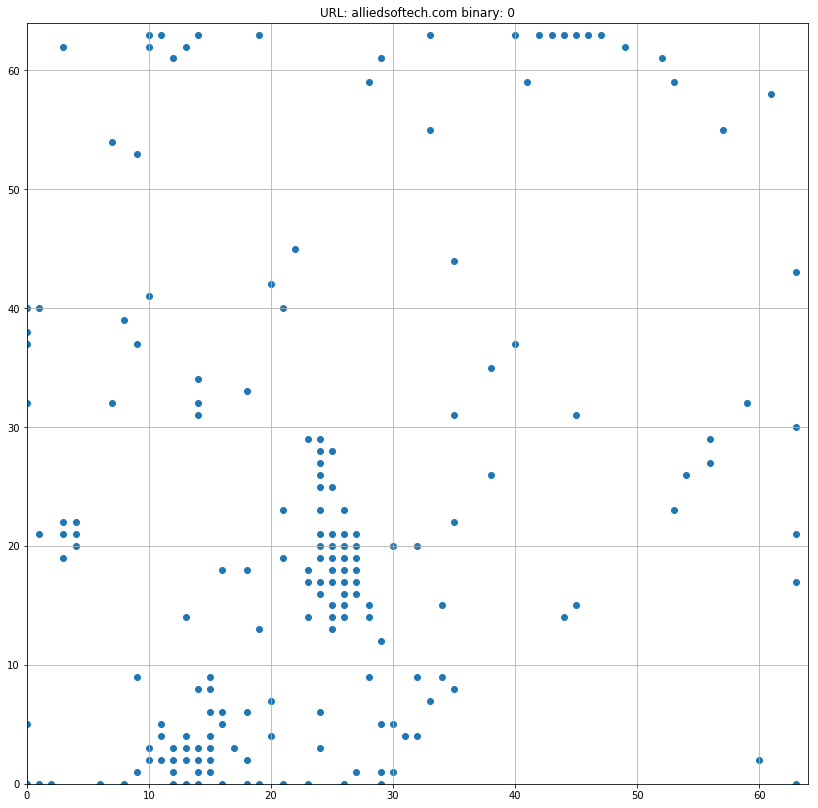

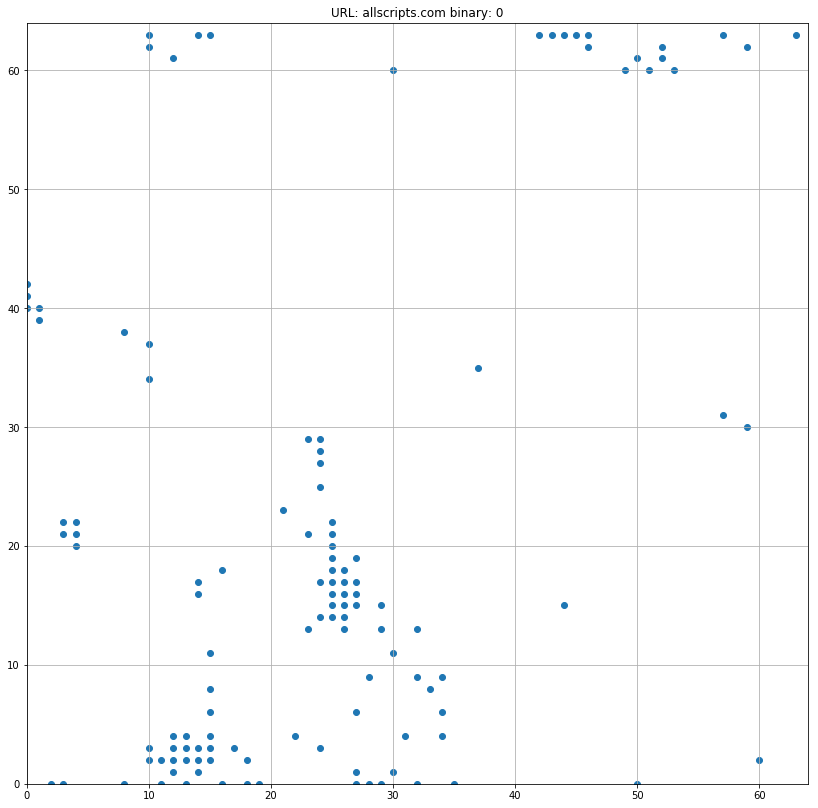

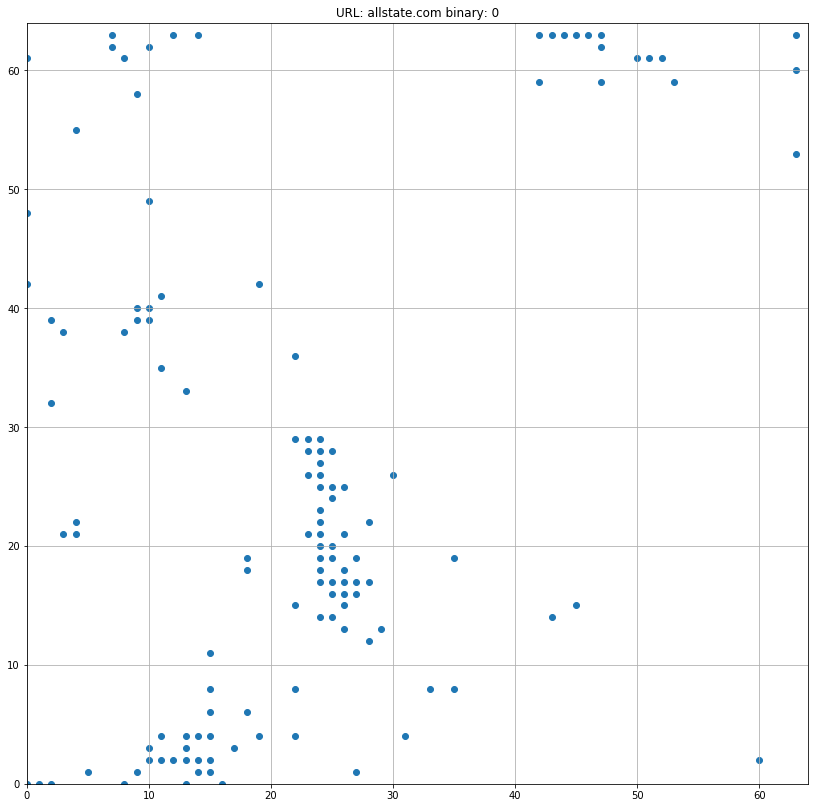

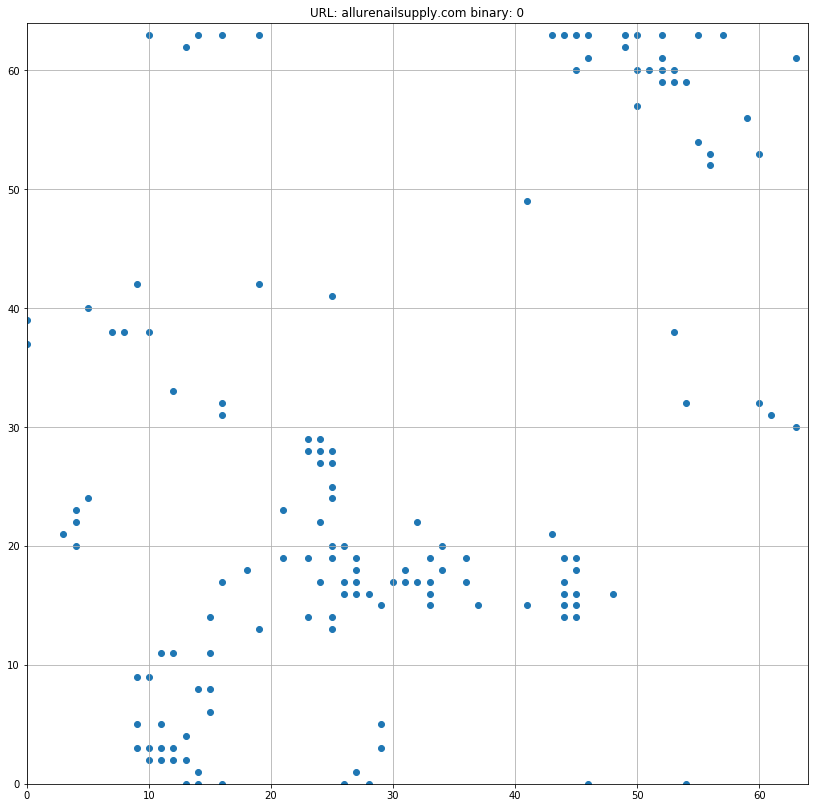

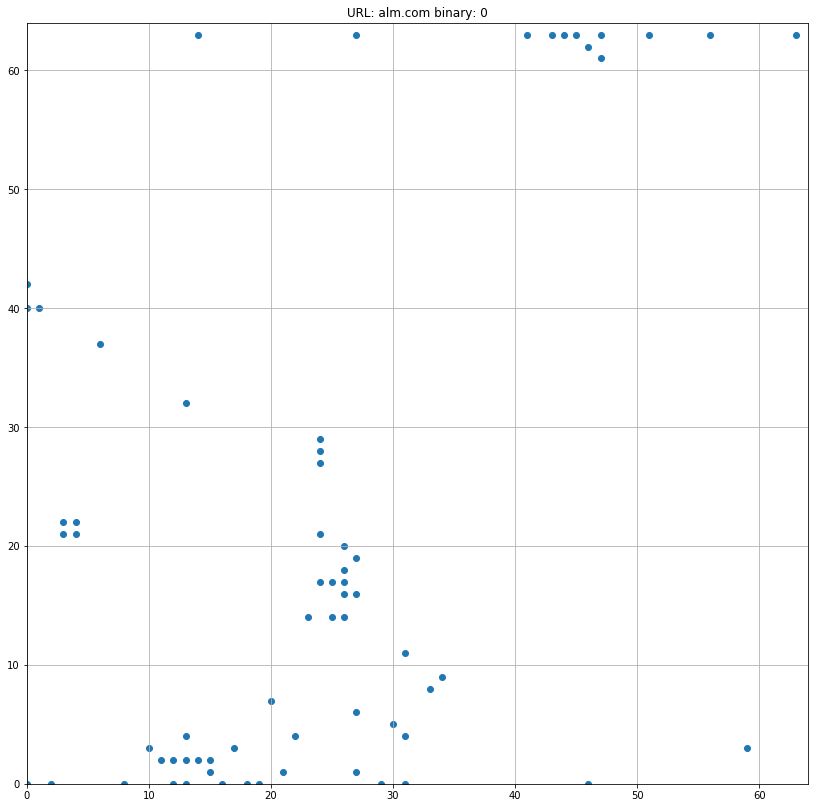

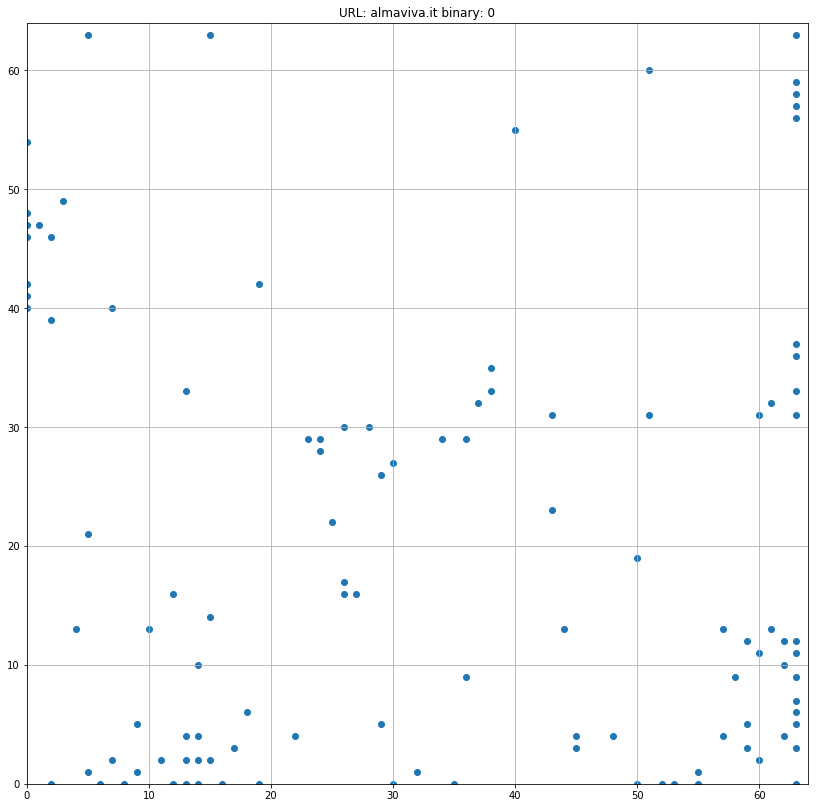

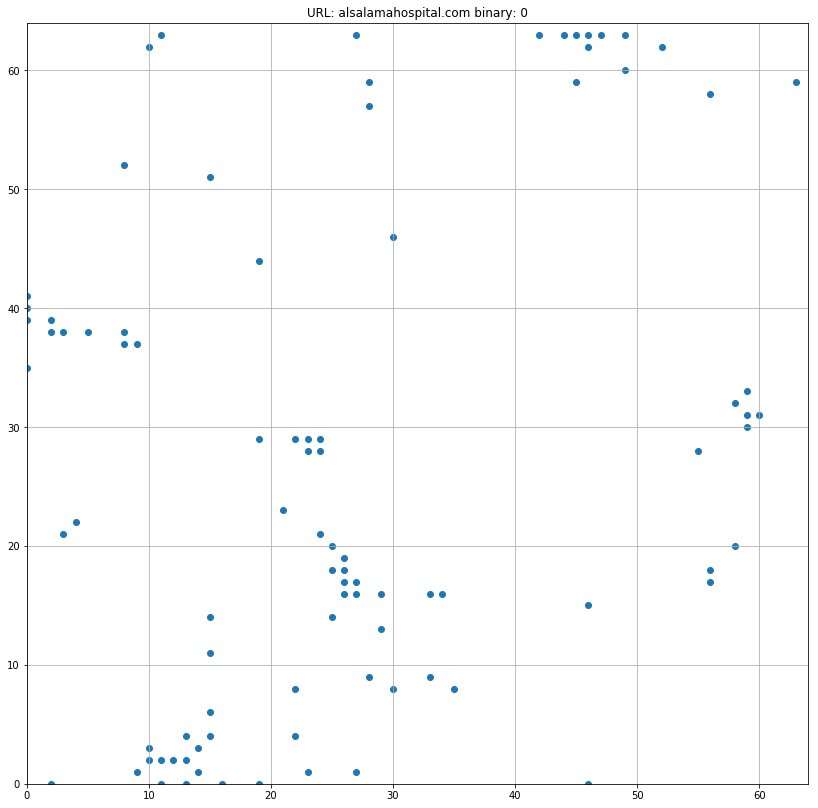

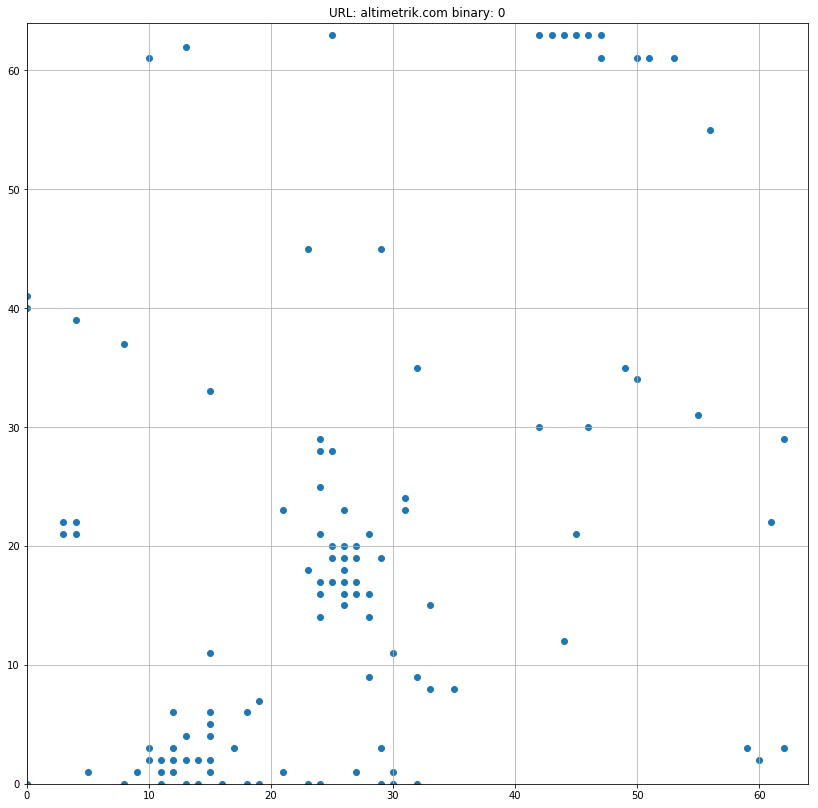

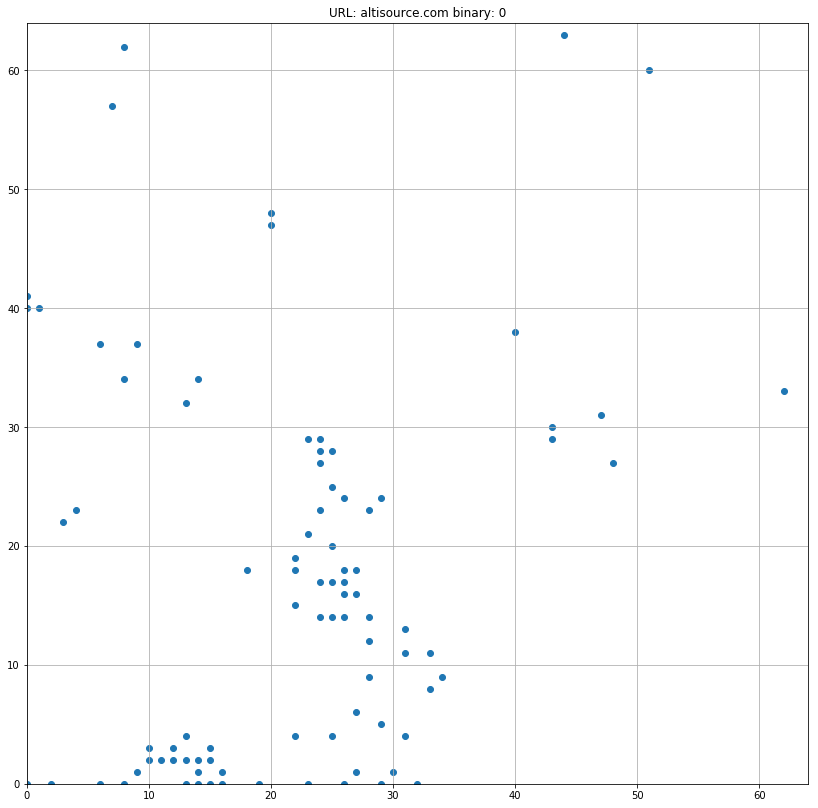

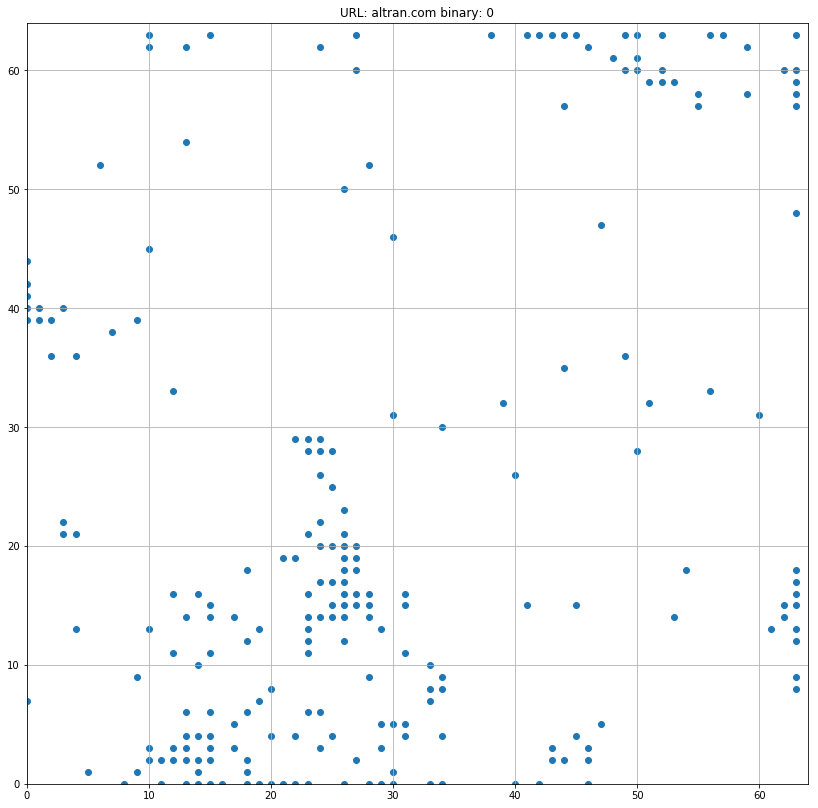

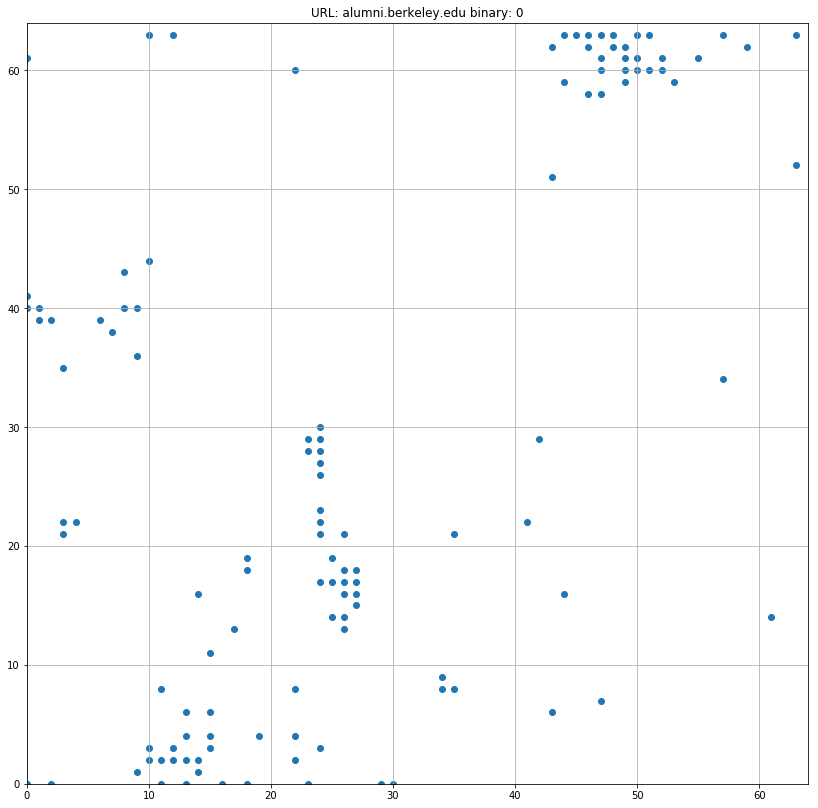

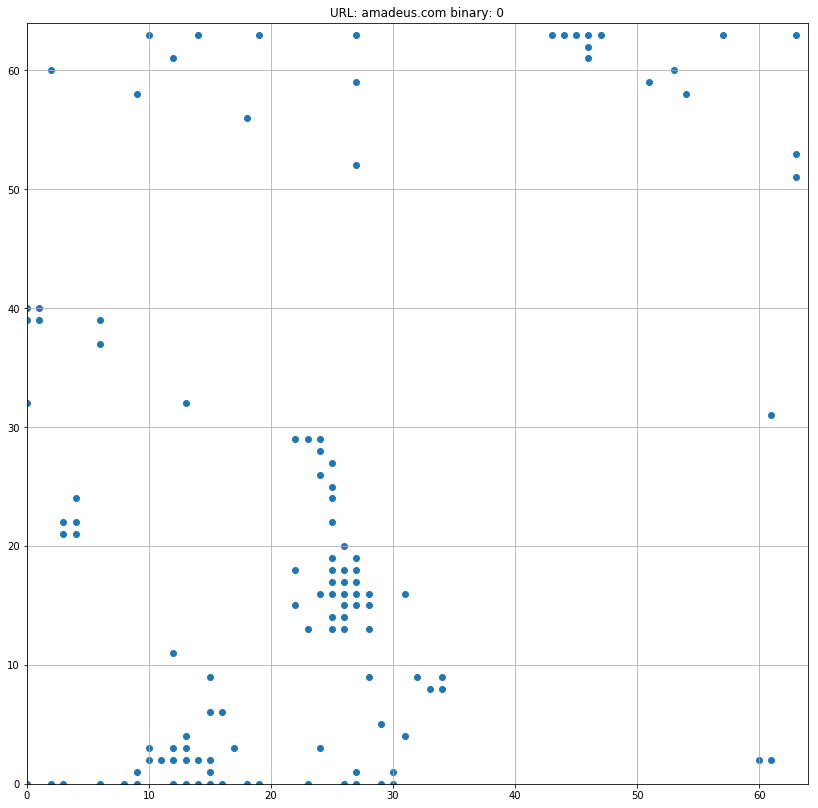

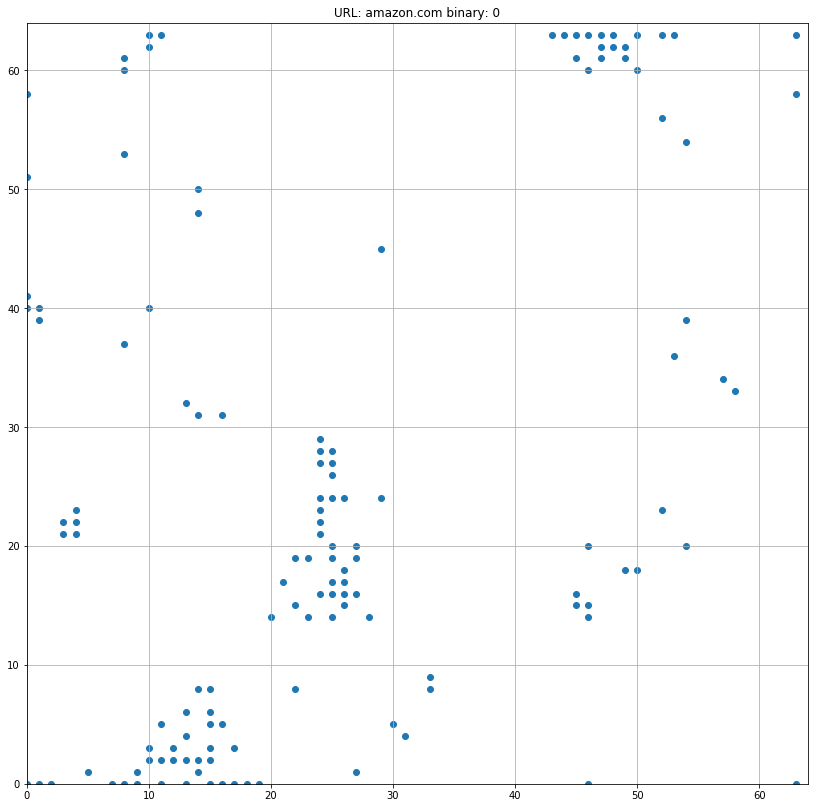

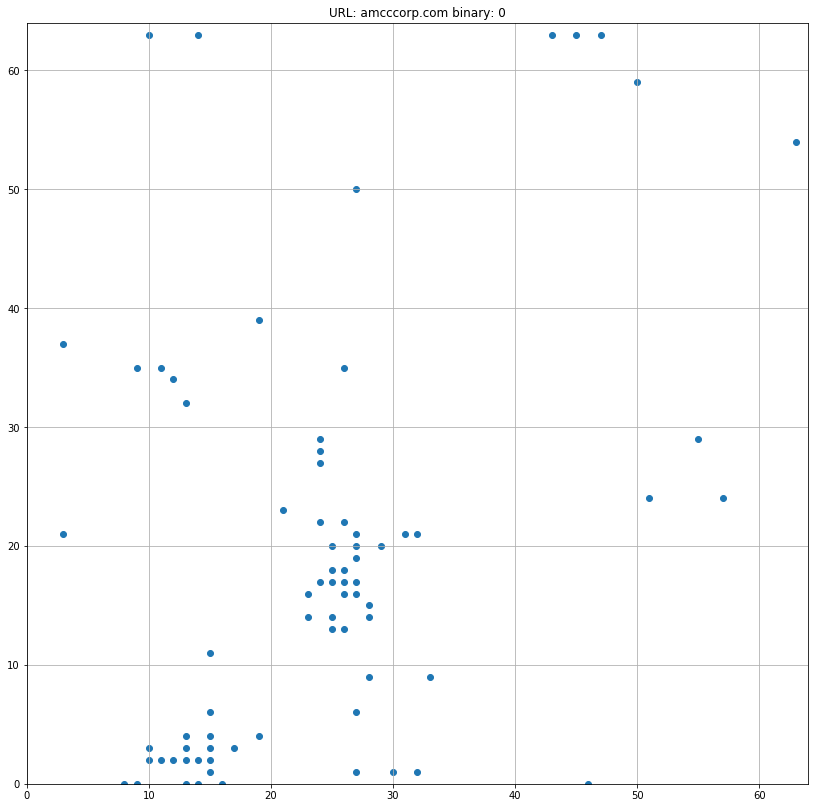

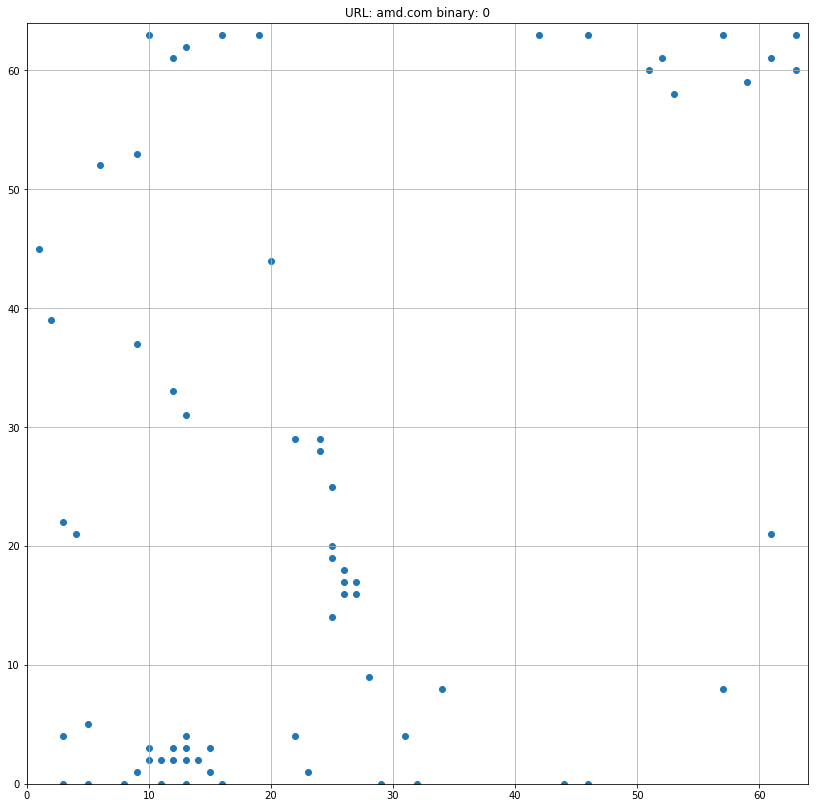

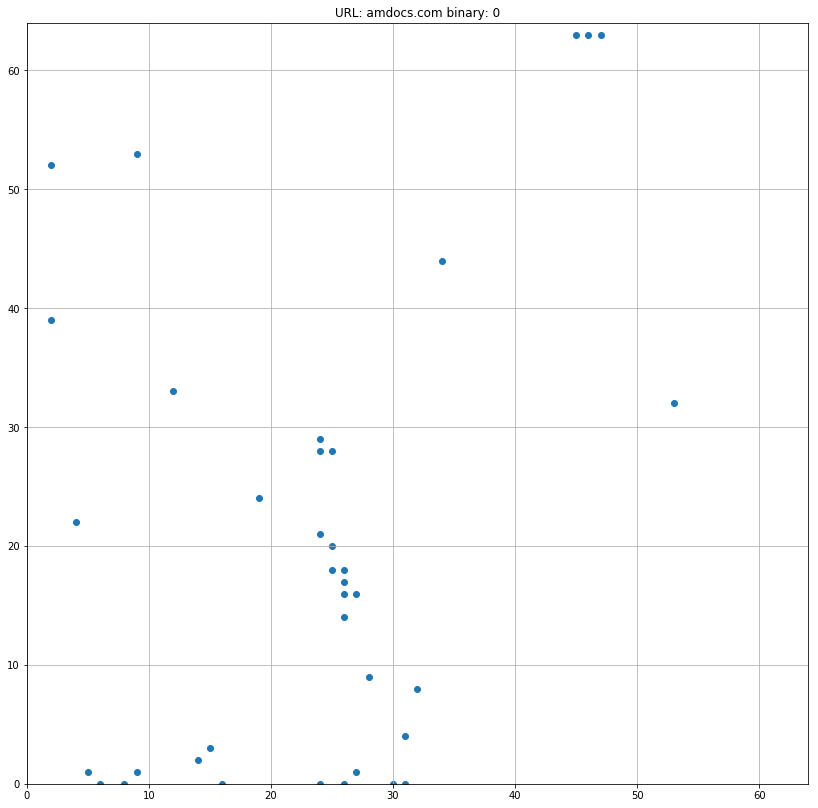

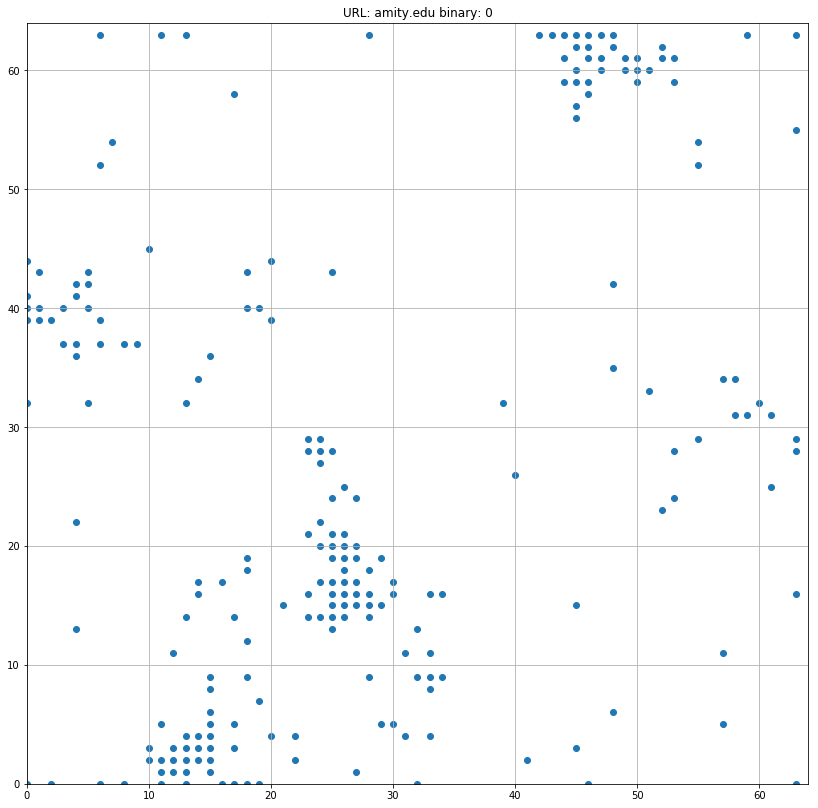

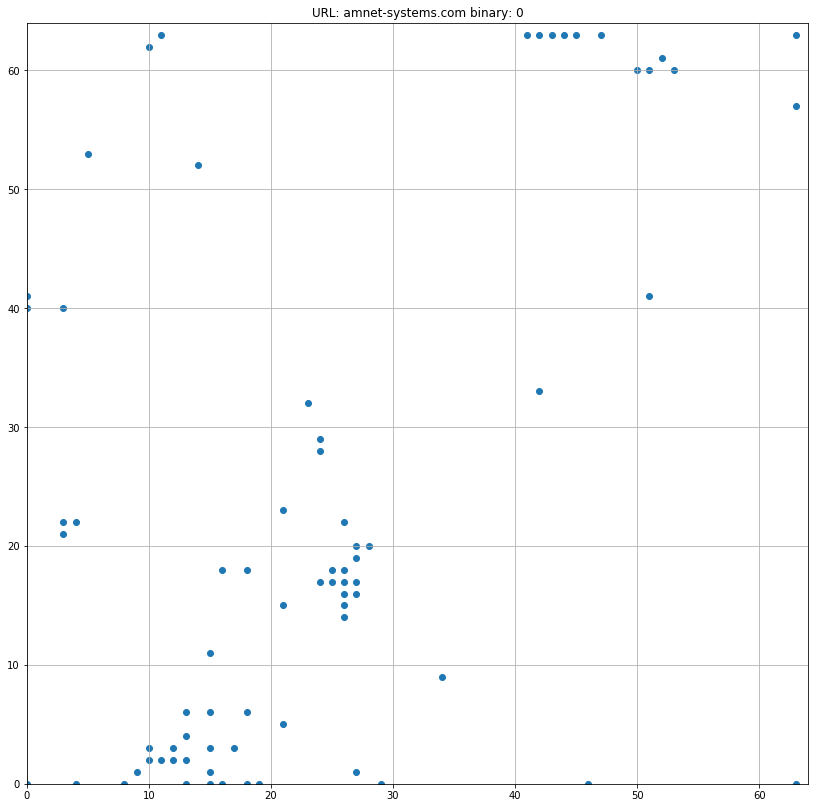

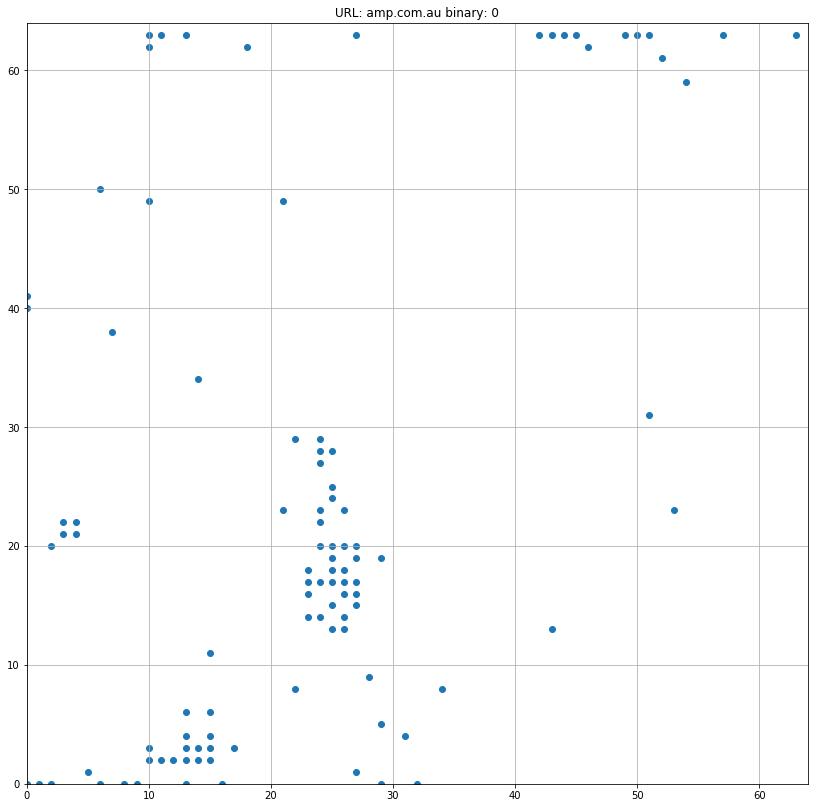

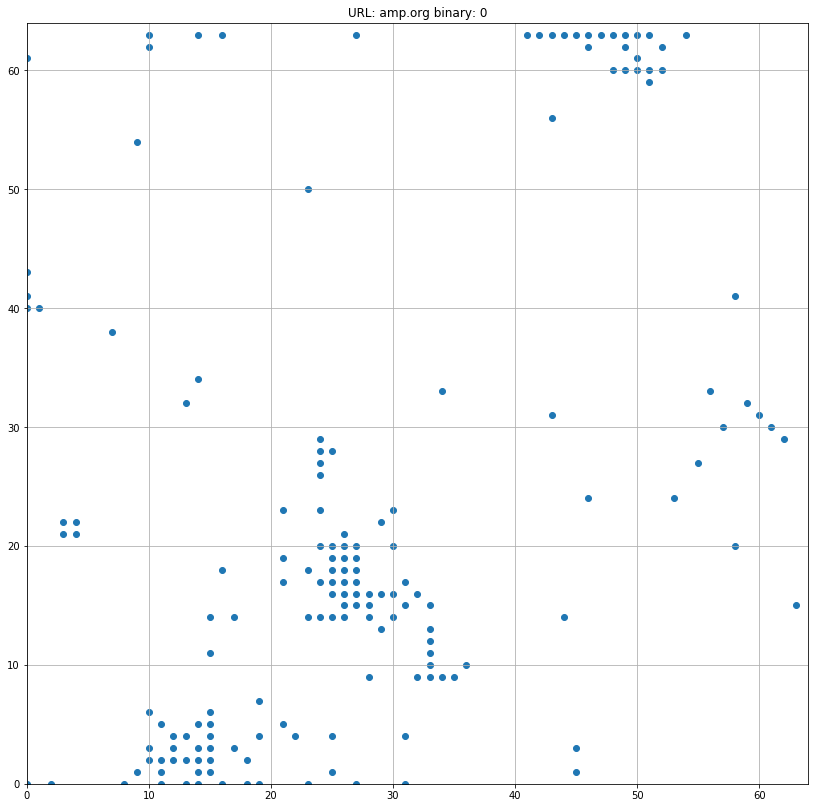

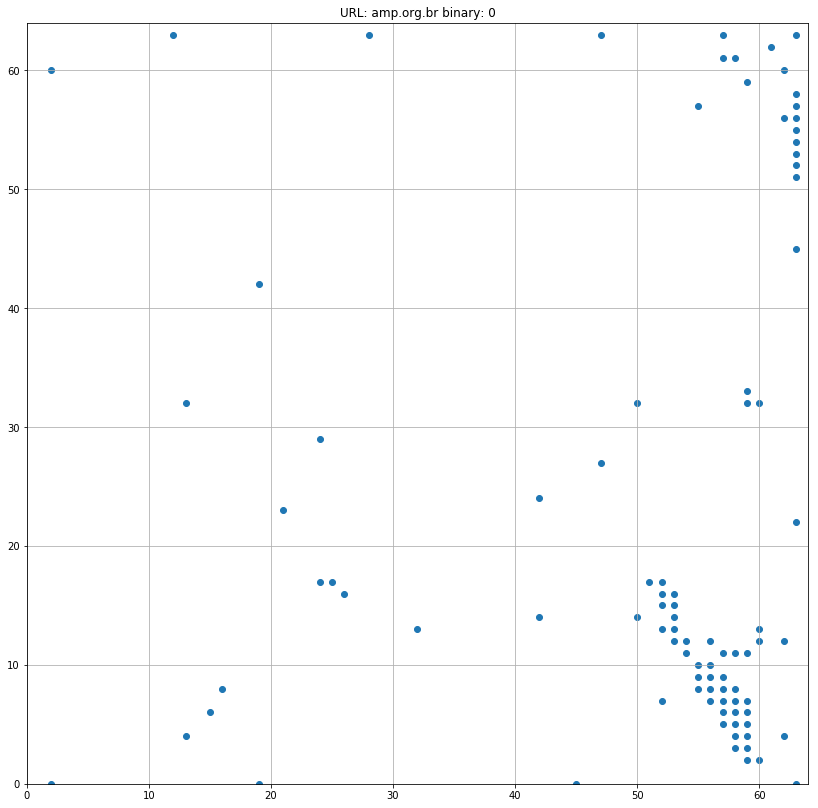

In [ ]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline
# given a tsv table of finterprints, create a png for each line item
fprintfile = 'data/fingerprint_all_good_tech_consult.tsv'

def create_png_images(fprintfile):
    with open(fprintfile, 'r') as source:
        count = 0
        for line in source:
            if count % 10000 == 0:
                print count
            count += 1
            cols = line.split('\t')
            
            binary = int(cols[0].strip())
            url = str(cols[1].strip())
            fingerprint = eval(cols[2])
            # uniquify for purposes of printing
            fingerprint = list(set(fingerprint))
            tupsx, tupsy = zip(*fingerprint)
            
            fig = plt.figure(figsize=(14,14))
            ax = fig.add_subplot(1,1,1)
            ax.scatter(list(tupsx),list(tupsy))
            plt.axis([0,x_width,0,y_width])
            plt.grid()
            plt.title("URL: {} binary: {}".format(url, binary))
            plt.savefig("fp170802/{}_{}.png".format(url, binary))

            
create_png_images(fprintfile)

In [2]:
# get full list of doc fingerprints
import matplotlib.pyplot as plt
%matplotlib inline


def save_doc_fingerprint(filepath, density, save_image=False, show_image=False):
    with open(filepath, 'r') as source:
        count = 0
        for row in source.readlines():
            if count % 10000 == 0:
                print count
            count += 1
            elems = row.split('\t')
            url = elems[0].strip()
            words = elems[1].split(' ')
            #print elems[0], "\t", len(words)
            
            #wrd = [word for word in words if word in unique_words]
            wrd = words
            #print "getting fingerprint"
            arrx, arry = retina.fingerprint_x_y(wrd, density=density)
            #print "saving to file"
            with open("fp170802_csv/{}_{}.csv".format(url, str(density)),'w') as target:
                for idx in range(len(arrx)):
                    target.write("{},{}\n".format(arrx[idx], arry[idx]))

            if save_image:

                wrd = list(set(wrd))

                arrx, arry = retina.fingerprint_x_y(wrd, density=density)

                fig = plt.figure(figsize=(14,14))
                ax = fig.add_subplot(1,1,1)
                ax.scatter(arrx,arry)
                plt.axis([0,x_width,0,y_width])
                plt.grid()
                plt.title("URL: {}".format("{} density: {}".format(url, str(density))))
                plt.savefig("fp170802/{}.png".format("{}_density_{}".format(url,str(density))))
                if show_image:            
                    plt.show()

save_doc_fingerprint('data/urls_all_good_tech_consult.tsv', 0, save_image=True, show_image=False)


0


NameError: global name 'retina' is not defined

In [63]:
# quick filter function to see if we can isolate language

         #x_0, y_0, x_1, y_1
filter = [30,40,40,50]

def get_count_in_box(fname, filter):
    count = 0
    total = 0
    with open(fname, 'r') as source:
        for line in source.readlines():
            total += 1
            if ',' in line:
                coords = line.split(',')
                x = int(coords[0].strip())
                y = int(coords[1].strip())
                #print x, y
                if x > filter[0] and x < filter[1] and y > filter[2] and y < filter[3]:
                    count += 1
    return count/float(total)

rootpath = 'fp170802_csv/'

tups = []
for fname in os.listdir(rootpath):
    tups.append( (get_count_in_box("{}/{}".format(rootpath,fname), filter), fname ))
    

print "Total number of files processed:",len(tups)
sortedtups =  sorted(tups, key=lambda x: x[0])
for tup in reversed(sortedtups):
    print tup[0], tup[1].replace('fprint_', '').replace('_1.csv','')

Total number of files processed: 208
1.0 suple.com.ar
0.462009803922 hralliance.com.mx
0.434034416826 talentum.com.es
0.428838951311 netcheck.es
0.410557184751 g2talentum.es
0.39367816092 soltec.cl
0.372641509434 dichtomatik.mx
0.333333333333 globalweb.com.br
0.17770767613 st.cl
0.117403314917 insol.org
0.0856443719413 cgd.pt
0.0719921104536 ativy.com
0.0686046511628 fps.edu.br
0.0652173913043 mindshare.co.jp
0.0588235294118 synchro.com.br
0.0574712643678 altec.com.br
0.0555555555556 rockcode.com.br
0.0550161812298 enova.com
0.049356223176 makeafuture.ca
0.0487959442332 edenbrookpartners.com
0.0470588235294 walkerandersen.com
0.0438765670203 groupeperspective.com
0.041519434629 fondation-abbe-pierre.fr
0.031914893617 burr.com
0.0304761904762 landisgyr.com
0.0294659300184 apside.com
0.0284653465347 chronicleindia.in
0.0263157894737 nbs.rs
0.0257966616085 multinet.com.tr
0.0241046831956 datapool.nl
0.0238095238095 diebold.com
0.0224867724868 fixedtoday.nl
0.0213414634146 pilotthomas.com


Length of row for  agendize.fr is 647
Length of unique words in text 233
rcompenses (72, 66)
aussi (72, 66)
blanche (72, 66)
marque (72, 69)
conseiller (69, 66)
le (72, 66)
choisi (72, 69)
formulaires (72, 66)
ressources (68, 64)
lemploi (66, 61)
fonctionnalits (72, 69)
quune (70, 65)
vives (67, 77)
reconnues (73, 68)
outils (68, 69)
enrichissez (62, 72)
connecteurs (66, 61)
essai (68, 69)
sant (66, 62)
sans (70, 65)
dintgration (68, 69)
leur (69, 67)
semaine (69, 68)
pleinement (74, 68)
habitudes (72, 61)
faites (73, 66)
autre (72, 66)
pme (68, 69)
et (69, 67)
sommes (68, 69)
depuis (64, 64)
dutilisation (69, 66)
seule (72, 67)
confidentialit (68, 69)
chaque (72, 66)
offre (68, 64)
notre (68, 69)
confiance (68, 69)
sur (68, 69)
grce (69, 67)
possibilits (72, 71)
prestations (73, 69)
paiements (73, 71)
disposition (69, 67)
qui (72, 66)
facilement (73, 67)
calendrier (68, 69)
rdv (66, 61)
intgr (69, 67)
tous (68, 69)
partenaires (68, 64)
politique (68, 69)
collectivits (68, 69)
seccion 

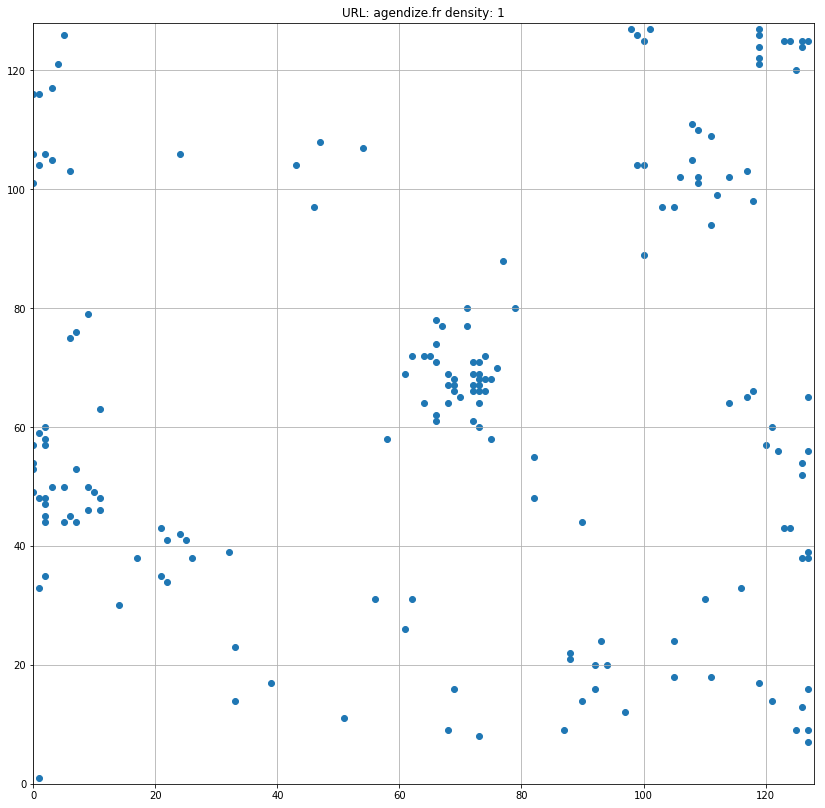

In [112]:
# Word list with xy subsector
import matplotlib.pyplot as plt
%matplotlib inline

# terasys.it 40-60 100-120 italian
# agendize.fr 60-80 60-80
# biztech.com 40-120 0-20 some cloud words, tech
# bdo.com 40-70 10-30  lots of business talk, no foreign language, but no tech either
#url = 'biztech.com'; left_x = 40; right_x = 120; bottom_y = 0; top_y = 20
#url = 'terasys.it'; left_x = 40; right_x = 60; bottom_y = 101; top_y = 120
url = 'agendize.fr'; left_x = 60; right_x = 80; bottom_y = 60; top_y = 80
#url = 'bdo.com'; left_x = 40; right_x = 70; bottom_y = 10; top_y = 30

density = 1

with open('data/raw_data_good_bad.tsv', 'r') as source:
    for row in source.readlines():
        elems = row.split('\t')
        if elems[0].startswith(url):
            print "Length of row for ", elems[0], "is", len(elems[1].split(' '))
            words = elems[1].split(' ')
            url = elems[0]

wrd = list(set([word for word in words if word in unique_words]))
print "Length of unique words in text", len(wrd)
#print wrd
for word in wrd:
    x, y = som.winner(word_vectors[word])
    if x > left_x and x < right_x:
        if y < top_y and y > bottom_y:
            print word, som.winner(word_vectors[word])

arrx, arry = retina.fingerprint_x_y(wrd, density=density)
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1,1,1)
ax.scatter(arrx,arry)
plt.axis([0,x_width,0,y_width])
plt.grid()
plt.title("URL: {}".format("{} density: {}".format(url, str(density))))
plt.savefig("fp170802/{}.png".format("{}_density_{}".format(url,str(density))))
plt.show()



In [99]:
word_list = ['staffing', 'consulting', 'recruiting']
for word in word_list:
    print word, som.winner(word_vectors[word])

staffing (126, 41)
consulting (79, 14)
recruiting (0, 45)
